In [49]:
# import stuff based on the provided assignments

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select
from pprint import pprint

In [39]:
"""function for testing frequencies and different strikes for all worksheets"""

def read_data(xls,worksheet):
    return pd.read_excel(xls, worksheet)
    

def format_data(df,expiry):
    """Convert into correct format"""
    df.rename(dict(zip(np.append(np.array(df.columns[0]), df.columns[-3:]), ['T', 'S', 'r', 'date'])), axis='columns', inplace=True)
    df = df.melt(id_vars=['T', 'r', 'S', 'date'], var_name="E").dropna()
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['name'] = df['E'].astype('str') + '-' + expiry
    
    df.rename({'value':'Cobs'}, axis='columns', inplace=True)
    df = df  >> mutate(r = f.r/100, Mat = f.T, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)
    df['Mat'] = df['Mat'].astype('int')
    
    return df
    
def calculate_bs_greeks(row):
    """Calculate IV and using that as volatility find delta and vega"""
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    
    starting_vol = .2
    bsm = BSM(S, E, T, r, starting_vol)
    iv = bsm.implied_vol(Cobs, precision=1.0e-6)
    
    bsm_iv = BSM(S, E, T, r, iv)
    
    delta = bsm_iv.delta()
    vega = bsm_iv.vega()
    
    return iv, delta, vega
    
def simulate_portfolio(df_data, strike, frequency):
    """
    Simulate portfolio of long 1 call, short delta*stock
    with given strike and rebalancing frequency.
    Returns array of errors, average stock price for data and how many observations there were
    """
    n = 0
    p_o = df_data[df_data['E'] == strike].iloc[0]['Cobs']
    p_s = {
        'price':df_data[df_data['E'] == strike].iloc[0]['S'],
        'delta':df_data[df_data['E'] == strike].iloc[0]['delta']
    }
    error_arr = np.array([])

    for index, data in df_data[df_data['E'] == strike].reset_index(drop=True).iterrows():
        T,r,S,date,E,cobs,name,mat,iv,delta,vega = data

        if n == frequency:
            p_o, p_s, error = hedge(p_o, p_s, cobs, S, delta)
            error_arr = np.append(error_arr, error)
            n = 0
        n += 1
    return error_arr,df_data[df_data['E'] == strike]['S'].mean(),df_data[df_data['E'] == strike]['S'].median(),len(df_data[df_data['E'] == strike])

def hedge(p_o, p_s, cobs, S, delta):
    option_gain = cobs - p_o
    stock_gain = -delta * (S - p_s['price'])
    error = option_gain + stock_gain
    
    return cobs, {'price':S, 'delta':delta}, error**2

def calculate_sheet_greeks(excel, sheet_name, sheetnr):
    day = str(sheet_name[3:5])
    month = str(sheet_name[5:7])
    year = str(sheet_name[7:11])
    expiry=year+month+day

    
    df = format_data(read_data(xls, sheet_name), expiry)
    greeks = df.apply(calculate_bs_greeks, axis=1, result_type='expand')
    df[['iv', 'delta', 'vega']] = greeks
    df = df >> filter(0 < f.iv < 0.9)
    
    return df



In [40]:
xls = pd.ExcelFile('data/isx2010C.xls')
sheets = xls.sheet_names

sheet_order = [0,1,11,10,9,8,7,6,5,4,3,2]

all_sheets = []

for i in sheet_order:
    df = calculate_sheet_greeks(xls, sheets[i], i)
    all_sheets.append(df)

all_data = pd.concat(all_sheets)


/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


In [41]:
def find_vega_hedges(data, date, option_mat):
    ok_hedges = data[(data['date'] == date) & (data['Mat'] > int(option_mat))]
    if len(ok_hedges) > 0:
        return 1
    return 0

def find_hedgable_options(all_data):
    all_options = all_data['name'].unique()
    fully_hedgable = []
    for option in all_options:

        days_hedged = 0
        # data for the chosen option that will be hedged
        initial_option_data = all_data[all_data['name'] == option]
        option_E = initial_option_data['E'].unique()[0]

        # options with same strike but not same
        available_hedges = all_data[(all_data['E'] == option_E) & (all_data['name'] != option)]

        # loop over days for the option
        for index, row in initial_option_data.iterrows():
            T,r,S,date,E,cobs,name, mat,iv,delta,vega = row

            has_hedge = find_vega_hedges(available_hedges, date, mat)

            days_hedged += has_hedge

        if days_hedged == len(initial_option_data):

            fully_hedgable.append(option)
    return fully_hedgable

find_hedgable_options(all_data)

['340-20100115',
 '360-20100115',
 '380-20100115',
 '400-20100115',
 '420-20100115',
 '440-20100115',
 '460-20100115',
 '480-20100115',
 '500-20100115',
 '520-20100115',
 '540-20100115',
 '400-20100219',
 '420-20100219',
 '440-20100219',
 '460-20100219',
 '480-20100219',
 '500-20100219',
 '520-20100219',
 '540-20100219',
 '340-20100416',
 '380-20100416',
 '400-20100416',
 '420-20100416',
 '460-20100416',
 '480-20100416',
 '500-20100416',
 '520-20100416',
 '540-20100416',
 '555-20100416',
 '560-20100416',
 '380-20100521',
 '400-20100521',
 '420-20100521',
 '440-20100521',
 '460-20100521',
 '480-20100521',
 '500-20100521',
 '520-20100521',
 '540-20100521',
 '560-20100521',
 '380-20100716',
 '400-20100716',
 '420-20100716',
 '440-20100716',
 '460-20100716',
 '465-20100716',
 '475-20100716',
 '480-20100716',
 '500-20100716',
 '520-20100716',
 '540-20100716',
 '560-20100716',
 '340-20100820',
 '360-20100820',
 '380-20100820',
 '400-20100820',
 '420-20100820',
 '440-20100820',
 '460-20100820

In [50]:
def delta_vega_hedge(data, date, maturity, cobs, delta, vega, stock, portfolio=None, init=False):
    """
    option_p = Portfolio is 1x short option with maturity T_1
    Hedge is long option, option_h, with same strike and maturity T_2, T_2 > T_1 and long stock, stock_h
    
    option_h amount = option_p vega / option_h vega
    where vega of short option is negative
    
    stock_h amount = option_p delta - (option_p vega / option_h vega) * option_h delta
    where delta and vega of short option is negative
    """
    if not init:
        # profit on short is -(price(t) - (-price(t-1))) = -price(t) + price(t-1)
        short_option_profit = - (cobs - portfolio['portfolio_option_price'])

        # profit on hedge option is amount*price(t) - amount*price(t-1) = amount (price(t) - price(t-1))
        old_hedge_current_price = data[(data['date'] == date) & (data['name'] == portfolio['hedge_option_name'])]['Cobs']
        hedge_option_profit = portfolio['hedge_option_amount']* (old_hedge_current_price - portfolio['hedge_option_price'])

        # stock profit = amount * (price(t) - price(t-1))
        stock_profit = portfolio['hedge_stock_amount'] * (stock - portfolio['hedge_stock_price'])
        hedge_error = short_option_profit - (hedge_option_profit + stock_profit)
        
    
    try:
        ok_hedges = data[(data['date'] == date) & (data['Mat'] > int(maturity))]
        selected_hedge = ok_hedges[ok_hedges['Mat'] == ok_hedges['Mat'].max()]


        hedge_option_name, hedge_option_price, hedge_option_delta, hedge_option_vega = selected_hedge[['name', 'Cobs', 'delta','vega']].values[0]
        hedge_option_amount = -vega/hedge_option_vega
        hedge_stock_amount = -delta - hedge_option_amount * hedge_option_delta
        print(hedge_option_amount, hedge_stock_amount)
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        try:
            ok_hedges = data[(data['date'] == date) & (data['Mat'] > int(maturity))]
            selected_hedge = ok_hedges[ok_hedges['Mat'] == ok_hedges['Mat'].min()]


            hedge_option_name, hedge_option_price, hedge_option_delta, hedge_option_vega = selected_hedge[['name', 'Cobs', 'delta','vega']].values[0]

            hedge_option_amount = -vega/hedge_option_vega
            hedge_stock_amount = -delta - hedge_option_amount * hedge_option_delta
        except:
            raise ValueError('Failed all options')
            
    
    
    new_portfolio = {
        'portfolio_option_price':cobs,
        'hedge_option_name':hedge_option_name,
        'hedge_option_price':hedge_option_price,
        'hedge_option_amount':hedge_option_amount,
        'hedge_stock_price':stock,
        'hedge_stock_amount':hedge_stock_amount
    }
    
    if init:
        return new_portfolio

    
    return hedge_error, new_portfolio

def hedge_option_lifetime(all_data, option, frequency):
    try:
        n = 0
        total_error = np.array([])

        days_hedged = 0
        # data for the chosen option that will be hedged
        initial_option_data = all_data[all_data['name'] == option]
        option_E = initial_option_data['E'].unique()[0]

        # options with same strike but not same
        available_hedges = all_data[(all_data['E'] == option_E) & (all_data['name'] != option)]

        first_row = all_data[all_data['name'] == option].iloc[0]
        portfolio = delta_vega_hedge(available_hedges, first_row['date'], first_row['Mat'], first_row['Cobs'], first_row['delta'], first_row['vega'], first_row['S'], init=True)
        
        # loop over days for the optio
        for index, row in initial_option_data.iterrows():
            T,r,S,date,E,cobs,name, mat,iv,delta,vega = row

            if n == frequency:
                error_term, portfolio = delta_vega_hedge(available_hedges, date, mat, cobs, delta, vega, S, portfolio=portfolio)
                pprint(portfolio)
                total_error = np.append(total_error, error_term)
                n = 0
            n += 1
        return [((total_error**2).mean()),  option_E, first_row['S'], initial_option_data['S'].iloc[-1], initial_option_data['S'].mean()]
    except BaseException as err:
        # some scenarios have vega = 0 for hedge option
        print(f"Unexpected {err=}, {type(err)=}")
        
        
obs_dict = {
    'mse',
    'strike',
    'price_0',
    'price_end',
    'price_avg'
}

min_freq = 1
max_freq = 6
all_observations = []

for frequency in range(min_freq, max_freq):

    for option in fully_hedgeable:
        observation = hedge_option_lifetime(all_data, option, frequency)
        
        if observation:
            observation += [frequency, option]
            all_observations.append(observation)


{'hedge_option_amount': -0.6320617442464189,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.1554,
 'hedge_stock_amount': -0.3654270558979609,
 'hedge_stock_price': 0.49435,
 'portfolio_option_price': 0.15505000000000002}
{'hedge_option_amount': -0.7810264072272747,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.15259999999999999,
 'hedge_stock_amount': -0.21168169316595709,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.1524}
{'hedge_option_amount': -0.6876698011017838,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.14605,
 'hedge_stock_amount': -0.3070592067604101,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.14555}
{'hedge_option_amount': -0.7668364884331484,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.15294999999999997,
 'hedge_stock_amount': -0.22847543574698204,
 'hedge_stock_price': 0.49169,
 'portfolio_option_price': 0.15280000000000002}
{'hedge_option_amount': -2.742640170

{'hedge_option_amount': -0.38576365908311666,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1766,
 'hedge_stock_amount': -0.6099024807530766,
 'hedge_stock_price': 0.516,
 'portfolio_option_price': 0.17635}
{'hedge_option_amount': -0.41194437307915,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1762,
 'hedge_stock_amount': -0.5846897991437943,
 'hedge_stock_price': 0.5157999999999999,
 'portfolio_option_price': 0.17605}
{'hedge_option_amount': -0.48981583248303917,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1778,
 'hedge_stock_amount': -0.5034659831975598,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.1777}
{'hedge_option_amount': -0.48516065541144265,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1778,
 'hedge_stock_amount': -0.5080472792053317,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.1777}
{'hedge_option_amount': -0.22661824250120208,
 'hedge_option_name': '3

{'hedge_option_amount': -0.6527403486877027,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.1367,
 'hedge_stock_amount': -0.3384724038520016,
 'hedge_stock_price': 0.49421,
 'portfolio_option_price': 0.13605}
{'hedge_option_amount': -0.5198373583313906,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.13535,
 'hedge_stock_amount': -0.4766474034702476,
 'hedge_stock_price': 0.49416000000000004,
 'portfolio_option_price': 0.1348}
{'hedge_option_amount': -0.38657367150482114,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.12795,
 'hedge_stock_amount': -0.6111432006746641,
 'hedge_stock_price': 0.4865,
 'portfolio_option_price': 0.127}
{'hedge_option_amount': -0.48024791539871264,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.12425,
 'hedge_stock_amount': -0.5151359395511301,
 'hedge_stock_price': 0.48231,
 'portfolio_option_price': 0.1232}
{'hedge_option_amount': -0.4056966686624761,
 'hedge_option_name': '360-20100319',
 'hed

{'hedge_option_amount': -0.5907674693577755,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.115,
 'hedge_stock_amount': -0.4033304479636952,
 'hedge_stock_price': 0.49169,
 'portfolio_option_price': 0.1135}
{'hedge_option_amount': -0.4890934080601705,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11259999999999999,
 'hedge_stock_amount': -0.5079297727137911,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.11125}
{'hedge_option_amount': -0.5413716023978606,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.1135,
 'hedge_stock_amount': -0.4532153143744069,
 'hedge_stock_price': 0.48835,
 'portfolio_option_price': 0.11059999999999999}
{'hedge_option_amount': -0.6486771443950907,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.10255,
 'hedge_stock_amount': -0.33985899298747535,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.10025}
{'hedge_option_amount': -0.6498590308984797,
 'hedge_option_nam

{'hedge_option_amount': -0.2893784591922141,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12994999999999998,
 'hedge_stock_amount': -0.684665885699147,
 'hedge_stock_price': 0.50571,
 'portfolio_option_price': 0.1277}
{'hedge_option_amount': -0.2471619395630206,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13119999999999998,
 'hedge_stock_amount': -0.7373172780002252,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.12969999999999998}
{'hedge_option_amount': -0.18392157955831587,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13505,
 'hedge_stock_amount': -0.8097773443487222,
 'hedge_stock_price': 0.5139400000000001,
 'portfolio_option_price': 0.13425}
{'hedge_option_amount': -0.28770893442951695,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13685,
 'hedge_stock_amount': -0.6965508173688906,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.1361}
{'hedge_option_amount': -0.24223726952559305,
 'he

 'hedge_option_price': 0.1102,
 'hedge_stock_amount': -0.46673469556848735,
 'hedge_stock_price': 0.50727,
 'portfolio_option_price': 0.1088}
{'hedge_option_amount': -0.4278940774472412,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.11220000000000001,
 'hedge_stock_amount': -0.5667379932928832,
 'hedge_stock_price': 0.50992,
 'portfolio_option_price': 0.1108}
{'hedge_option_amount': -0.5089459012945665,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.11,
 'hedge_stock_amount': -0.47965831402124603,
 'hedge_stock_price': 0.50545,
 'portfolio_option_price': 0.1076}
{'hedge_option_amount': -0.4085581956014532,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.11065000000000001,
 'hedge_stock_amount': -0.5859342961652145,
 'hedge_stock_price': 0.50808,
 'portfolio_option_price': 0.109}
{'hedge_option_amount': -0.31014654069127623,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.1167,
 'hedge_stock_amount': -0.6872927299160896,
 'h

{'hedge_option_amount': -0.6412319883721422,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.07775,
 'hedge_stock_amount': -0.3463278812635532,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.07425}
{'hedge_option_amount': -0.6782743785018076,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.07705,
 'hedge_stock_amount': -0.304664804063581,
 'hedge_stock_price': 0.48835,
 'portfolio_option_price': 0.07354999999999999}
{'hedge_option_amount': -0.7213719064770128,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0686,
 'hedge_stock_amount': -0.25239562425918516,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.06455}
{'hedge_option_amount': -0.715051385832674,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.06725,
 'hedge_stock_amount': -0.259143767211534,
 'hedge_stock_price': 0.47548,
 'portfolio_option_price': 0.06305}
{'hedge_option_amount': -0.6792441593413827,
 'hedge_option_name': '420-201

{'hedge_option_amount': -0.20626300180747986,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.09885,
 'hedge_stock_amount': -0.772241786183871,
 'hedge_stock_price': 0.51213,
 'portfolio_option_price': 0.09345}
{'hedge_option_amount': -0.23147623630336497,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.09834999999999999,
 'hedge_stock_amount': -0.7421488834703371,
 'hedge_stock_price': 0.51197,
 'portfolio_option_price': 0.09359999999999999}
{'hedge_option_amount': -0.24322848325097043,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.09375,
 'hedge_stock_amount': -0.7230041029965135,
 'hedge_stock_price': 0.50571,
 'portfolio_option_price': 0.08785}
{'hedge_option_amount': -0.18334572616097,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.0947,
 'hedge_stock_amount': -0.7965481348390773,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.08979999999999999}
{'hedge_option_amount': -0.09370087460236441,
 'hedge_option_

{'hedge_option_amount': -0.6592956915256234,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.05705,
 'hedge_stock_amount': -0.3059641981419906,
 'hedge_stock_price': 0.48514999999999997,
 'portfolio_option_price': 0.05195}
{'hedge_option_amount': -0.6533201091750085,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.0569,
 'hedge_stock_amount': -0.31204664673631916,
 'hedge_stock_price': 0.4849,
 'portfolio_option_price': 0.0516}
{'hedge_option_amount': -0.6700873881118128,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.05855,
 'hedge_stock_amount': -0.2894619519543776,
 'hedge_stock_price': 0.48583,
 'portfolio_option_price': 0.053700000000000005}
{'hedge_option_amount': -0.5922421049977048,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.0636,
 'hedge_stock_amount': -0.3846926252046842,
 'hedge_stock_price': 0.49463,
 'portfolio_option_price': 0.05895}
{'hedge_option_amount': -0.5751990777445217,
 'hedge_option_name': '440-20

{'hedge_option_amount': -0.0757938737892991,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0916,
 'hedge_stock_amount': -0.9018098724313656,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.08855}
{'hedge_option_amount': -0.060030590249116,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.09305,
 'hedge_stock_amount': -0.9200900504966474,
 'hedge_stock_price': 0.52959,
 'portfolio_option_price': 0.0901}
{'hedge_option_amount': -0.7691740292711363,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.05065,
 'hedge_stock_amount': -0.19364105662639375,
 'hedge_stock_price': 0.49435,
 'portfolio_option_price': 0.045450000000000004}
{'hedge_option_amount': -0.7800655590225127,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.04875,
 'hedge_stock_amount': -0.17594151818914272,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.0434}
{'hedge_option_amount': -0.7784235104522288,
 'hedge_option_name': '460-20

{'hedge_option_amount': -0.2668933562722247,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06985,
 'hedge_stock_amount': -0.7079633940756922,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.059}
{'hedge_option_amount': -0.2643898598790014,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06985,
 'hedge_stock_amount': -0.7098887840204031,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.059}
{'hedge_option_amount': -0.3283012151745128,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06470000000000001,
 'hedge_stock_amount': -0.6272097086799079,
 'hedge_stock_price': 0.50898,
 'portfolio_option_price': 0.0522}
{'hedge_option_amount': -0.4236466078790784,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06565,
 'hedge_stock_amount': -0.4938835559879873,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.0579}
{'hedge_option_amount': -0.2777478705061685,
 'hedge_option_name': '

 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.03535,
 'hedge_stock_amount': -0.1429369057870854,
 'hedge_stock_price': 0.49263,
 'portfolio_option_price': 0.0292}
{'hedge_option_amount': -0.7759888057861937,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.0358,
 'hedge_stock_amount': -0.15596667983922446,
 'hedge_stock_price': 0.49515,
 'portfolio_option_price': 0.02975}
{'hedge_option_amount': -0.7675078334143672,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.0368,
 'hedge_stock_amount': -0.17056200951927236,
 'hedge_stock_price': 0.49765,
 'portfolio_option_price': 0.03065}
{'hedge_option_amount': -0.7675253840506526,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.036,
 'hedge_stock_amount': -0.16756364576359917,
 'hedge_stock_price': 0.49643,
 'portfolio_option_price': 0.02975}
{'hedge_option_amount': -0.74509683926451,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.0416,
 'hedge_stock_amount': -0.20521

{'hedge_option_amount': -0.27288710088906515,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.05275,
 'hedge_stock_amount': -0.6747936379389365,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.03775}
{'hedge_option_amount': -0.3064820149353626,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0508,
 'hedge_stock_amount': -0.6210743006559863,
 'hedge_stock_price': 0.51213,
 'portfolio_option_price': 0.0355}
{'hedge_option_amount': -0.3016433175798347,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.05,
 'hedge_stock_amount': -0.6243017159159319,
 'hedge_stock_price': 0.51197,
 'portfolio_option_price': 0.0353}
{'hedge_option_amount': -0.3416223472434941,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0465,
 'hedge_stock_amount': -0.5492239425455732,
 'hedge_stock_price': 0.50571,
 'portfolio_option_price': 0.03075}
{'hedge_option_amount': -0.2838466201748628,
 'hedge_option_name': '480-20100618',
 'hedge_option_pric

{'hedge_option_amount': -0.7603011146878424,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0229,
 'hedge_stock_amount': -0.09722947667083398,
 'hedge_stock_price': 0.49421,
 'portfolio_option_price': 0.016}
{'hedge_option_amount': -0.757373577564239,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0222,
 'hedge_stock_amount': -0.09757036834052185,
 'hedge_stock_price': 0.49416000000000004,
 'portfolio_option_price': 0.0154}
{'hedge_option_amount': -0.7438396702643634,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0193,
 'hedge_stock_amount': -0.07766664811097779,
 'hedge_stock_price': 0.4865,
 'portfolio_option_price': 0.0129}
{'hedge_option_amount': -0.7534180572939595,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.023,
 'hedge_stock_amount': -0.10618365468767771,
 'hedge_stock_price': 0.49605,
 'portfolio_option_price': 0.01595}
{'hedge_option_amount': -0.7278454547786639,
 'hedge_option_name': '500-20100319',
 'hedge_

{'hedge_option_amount': -0.1603272259430335,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0402,
 'hedge_stock_amount': -0.7636824630041879,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.0258}
{'hedge_option_amount': -0.10730151961259403,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0375,
 'hedge_stock_amount': -0.8493556173739997,
 'hedge_stock_price': 0.52634,
 'portfolio_option_price': 0.027}
{'hedge_option_amount': -0.12173781300033702,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.042,
 'hedge_stock_amount': -0.8165190870638122,
 'hedge_stock_price': 0.52776,
 'portfolio_option_price': 0.02885}
{'hedge_option_amount': -0.11287318536221845,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0421,
 'hedge_stock_amount': -0.8236229080695442,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.0297}
{'hedge_option_amount': -0.11408780333753722,
 'hedge_option_name': '500-20100618',
 'hedge

 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.0188,
 'hedge_stock_amount': -0.0944486101569807,
 'hedge_stock_price': 0.51035,
 'portfolio_option_price': 0.010199999999999999}
{'hedge_option_amount': -0.6792767524450066,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.01795,
 'hedge_stock_amount': -0.08901052805795473,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.0095}
{'hedge_option_amount': -0.521129515789184,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02945,
 'hedge_stock_amount': -0.20017598038832257,
 'hedge_stock_price': 0.516,
 'portfolio_option_price': 0.0116}
{'hedge_option_amount': -0.5158449473540173,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.029,
 'hedge_stock_amount': -0.1989086194721208,
 'hedge_stock_price': 0.5157999999999999,
 'portfolio_option_price': 0.011}
{'hedge_option_amount': -0.5129640089912826,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0297,


 'hedge_stock_amount': -0.029502753245183144,
 'hedge_stock_price': 0.50992,
 'portfolio_option_price': 0.00466}
{'hedge_option_amount': -0.5891842238550044,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0104,
 'hedge_stock_amount': -0.027537356466945523,
 'hedge_stock_price': 0.50545,
 'portfolio_option_price': 0.0043}
{'hedge_option_amount': -0.587024864593887,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0107,
 'hedge_stock_amount': -0.027817030143554855,
 'hedge_stock_price': 0.50808,
 'portfolio_option_price': 0.00425}
{'hedge_option_amount': -0.6290063004065604,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0129,
 'hedge_stock_amount': -0.041686707531893574,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.00571}
{'hedge_option_amount': -0.6274639292304781,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0128,
 'hedge_stock_amount': -0.0434613090408115,
 'hedge_stock_price': 0.51609,
 'portfolio_option_

{'hedge_option_amount': -0.5889572269241572,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1684,
 'hedge_stock_amount': -0.39314824104089086,
 'hedge_stock_price': 0.50571,
 'portfolio_option_price': 0.1683}
{'hedge_option_amount': -0.5350948386521909,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1698,
 'hedge_stock_amount': -0.45686740497309486,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.1696}
{'hedge_option_amount': -2.4338434320817925,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.17405,
 'hedge_stock_amount': 1.4382134948992351,
 'hedge_stock_price': 0.5139400000000001,
 'portfolio_option_price': 0.17425}
{'hedge_option_amount': -0.5827370762981751,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.17625,
 'hedge_stock_amount': -0.4078872551634287,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.1762}
{'hedge_option_amount': -0.7567065073643509,
 'hedge_option_name': '340-20100618',
 'hedg

{'hedge_option_amount': -0.5022857501760967,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.15719999999999998,
 'hedge_stock_amount': -0.4838885868749241,
 'hedge_stock_price': 0.51389,
 'portfolio_option_price': 0.156}
{'hedge_option_amount': -0.42778541770527606,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.15485,
 'hedge_stock_amount': -0.5632844409604914,
 'hedge_stock_price': 0.5124500000000001,
 'portfolio_option_price': 0.15365}
{'hedge_option_amount': -0.03582204440960483,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.14875,
 'hedge_stock_amount': -0.9640804492848956,
 'hedge_stock_price': 0.50703,
 'portfolio_option_price': 0.14709999999999998}
{'hedge_option_amount': -0.305295693433075,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.15134999999999998,
 'hedge_stock_amount': -0.6897457220079128,
 'hedge_stock_price': 0.50933,
 'portfolio_option_price': 0.14995}
{'hedge_option_amount': -0.3595527891642128,
 'hed

 'hedge_stock_amount': -0.21850338048020146,
 'hedge_stock_price': 0.4849,
 'portfolio_option_price': 0.10729999999999999}
{'hedge_option_amount': -0.80562220969199,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11059999999999999,
 'hedge_stock_amount': -0.18814627338527212,
 'hedge_stock_price': 0.48583,
 'portfolio_option_price': 0.10959999999999999}
{'hedge_option_amount': -0.6848117159927634,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11675,
 'hedge_stock_amount': -0.31327312478872027,
 'hedge_stock_price': 0.49463,
 'portfolio_option_price': 0.11595}
{'hedge_option_amount': -0.732748198193213,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11805,
 'hedge_stock_amount': -0.2646659880160853,
 'hedge_stock_price': 0.49619,
 'portfolio_option_price': 0.1175}
{'hedge_option_amount': -0.766180429684824,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.1288,
 'hedge_stock_amount': -0.23061825524664703,
 'hedge_stock_price

 'hedge_option_price': 0.1456,
 'hedge_stock_amount': -0.5788004768032138,
 'hedge_stock_price': 0.52473,
 'portfolio_option_price': 0.1454}
{'hedge_option_amount': -0.3507376626899119,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1259,
 'hedge_stock_amount': -0.6220950744552305,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.1245}
{'hedge_option_amount': -0.22989334035292944,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12625,
 'hedge_stock_amount': -0.7602455012203204,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.1251}
{'hedge_option_amount': -0.09825945279791157,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12359999999999999,
 'hedge_stock_amount': -0.8993774328697027,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.12275}
{'hedge_option_amount': -0.32679885585002444,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12725,
 'hedge_stock_amount': -0.6557527175341111,

 'hedge_option_price': 0.1188,
 'hedge_stock_amount': -0.6094033662752698,
 'hedge_stock_price': 0.51366,
 'portfolio_option_price': 0.1155}
{'hedge_option_amount': -0.22186207970919955,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1191,
 'hedge_stock_amount': -0.7731377853224624,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.11595}
{'hedge_option_amount': -0.33285721549470987,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1167,
 'hedge_stock_amount': -0.6553859094062653,
 'hedge_stock_price': 0.51213,
 'portfolio_option_price': 0.1135}
{'hedge_option_amount': -0.37286223929305057,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1163,
 'hedge_stock_amount': -0.6126481864075378,
 'hedge_stock_price': 0.51197,
 'portfolio_option_price': 0.11359999999999999}
{'hedge_option_amount': -0.44143133904550436,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1115,
 'hedge_stock_amount': -0.5346062130538838,
 'hedge_sto

{'hedge_option_amount': -0.7822977943576258,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0799,
 'hedge_stock_amount': -0.2125368753558632,
 'hedge_stock_price': 0.49416000000000004,
 'portfolio_option_price': 0.07815000000000001}
{'hedge_option_amount': -0.8190310320933354,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0737,
 'hedge_stock_amount': -0.17255921274139874,
 'hedge_stock_price': 0.4865,
 'portfolio_option_price': 0.07195}
{'hedge_option_amount': -0.7712914538997766,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0809,
 'hedge_stock_amount': -0.22391734994897217,
 'hedge_stock_price': 0.49605,
 'portfolio_option_price': 0.07940000000000001}
{'hedge_option_amount': -0.8464226968694007,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0706,
 'hedge_stock_amount': -0.1412895735491524,
 'hedge_stock_price': 0.48231,
 'portfolio_option_price': 0.06915}
{'hedge_option_amount': -0.8197869594857816,
 'hedge_option_nam

{'hedge_option_amount': -0.3173187740896495,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.11040000000000001,
 'hedge_stock_amount': -0.6680610268663054,
 'hedge_stock_price': 0.52776,
 'portfolio_option_price': 0.1088}
{'hedge_option_amount': -0.29287588067851744,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.1108,
 'hedge_stock_amount': -0.6951543020918071,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.10940000000000001}
{'hedge_option_amount': -0.3419721730463894,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.1075,
 'hedge_stock_amount': -0.6379112083150664,
 'hedge_stock_price': 0.5242899999999999,
 'portfolio_option_price': 0.10575}
{'hedge_option_amount': -0.29038283814348764,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.11015000000000001,
 'hedge_stock_amount': -0.6967426810997961,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.10875}
{'hedge_option_amount': -0.339663582660

 'portfolio_option_price': 0.0785}
{'hedge_option_amount': -0.7349267423373791,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.08065,
 'hedge_stock_amount': -0.2598569019136169,
 'hedge_stock_price': 0.51609,
 'portfolio_option_price': 0.07905}
{'hedge_option_amount': -0.7480157464495361,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.08155,
 'hedge_stock_amount': -0.24578756420911263,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.0799}
{'hedge_option_amount': -0.7787647845929005,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.07654999999999999,
 'hedge_stock_amount': -0.21227798202310466,
 'hedge_stock_price': 0.51035,
 'portfolio_option_price': 0.07479999999999999}
{'hedge_option_amount': -0.7691405233359438,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.0745,
 'hedge_stock_amount': -0.22242148738331802,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.0728}
{'hedge_option_amount': -0

{'hedge_option_amount': -0.23292088671342484,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08815,
 'hedge_stock_amount': -0.7503942187615986,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.08505}
{'hedge_option_amount': -0.15995501007384,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.09284999999999999,
 'hedge_stock_amount': -0.832146492827316,
 'hedge_stock_price': 0.5302100000000001,
 'portfolio_option_price': 0.0906}
{'hedge_option_amount': -0.20601924557198978,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0882,
 'hedge_stock_amount': -0.7798298572763098,
 'hedge_stock_price': 0.52473,
 'portfolio_option_price': 0.08545}
{'hedge_option_amount': -0.3132680655039301,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.07145,
 'hedge_stock_amount': -0.6347463248723282,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.06555}
{'hedge_option_amount': -0.21819458974243822,
 'hedge_option_name

{'hedge_option_amount': -0.7838656835061638,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.0637,
 'hedge_stock_amount': -0.20679631302074075,
 'hedge_stock_price': 0.51609,
 'portfolio_option_price': 0.0613}
{'hedge_option_amount': -0.7897941037654506,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.0644,
 'hedge_stock_amount': -0.19980720427391407,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.062049999999999994}
{'hedge_option_amount': -0.8125789963308536,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.05965,
 'hedge_stock_amount': -0.17314286941607926,
 'hedge_stock_price': 0.51035,
 'portfolio_option_price': 0.05725}
{'hedge_option_amount': -0.8049831141878785,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.05765,
 'hedge_stock_amount': -0.1814054680412549,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.055200000000000006}
{'hedge_option_amount': -0.4866993799845719,
 'hedge_option

{'hedge_option_amount': -0.20048219549220472,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.052950000000000004,
 'hedge_stock_amount': -0.7697848823027242,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.0438}
{'hedge_option_amount': -0.22748318995521738,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.05535,
 'hedge_stock_amount': -0.7330996638557197,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.04715}
{'hedge_option_amount': -0.06826702925386048,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.04995,
 'hedge_stock_amount': -0.926402659774344,
 'hedge_stock_price': 0.49967,
 'portfolio_option_price': 0.03986}
{'hedge_option_amount': -0.19246649123984538,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.046950000000000006,
 'hedge_stock_amount': -0.7713874838001006,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.03625}
{'hedge_option_amount': -0.19321381176564045,
 'hedge_option_name': 

 'hedge_option_price': 0.054950000000000006,
 'hedge_stock_amount': -0.3904984763677428,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0442}
{'hedge_option_amount': -0.5535323729887076,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.054950000000000006,
 'hedge_stock_amount': -0.3922785069474676,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0442}
{'hedge_option_amount': -0.5929933064538473,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0505,
 'hedge_stock_amount': -0.32977264132650846,
 'hedge_stock_price': 0.50898,
 'portfolio_option_price': 0.038950000000000005}
{'hedge_option_amount': -0.5790705682379674,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0512,
 'hedge_stock_amount': -0.34966662327043835,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.039700000000000006}
{'hedge_option_amount': -0.5529680579769354,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0

{'hedge_option_amount': -0.09273904140381996,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039450000000000006,
 'hedge_stock_amount': -0.8952370949852753,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.02785}
{'hedge_option_amount': -0.2549067680192202,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039299999999999995,
 'hedge_stock_amount': -0.6597134165593822,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.0277}
{'hedge_option_amount': -0.33092697805426075,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.030699999999999998,
 'hedge_stock_amount': -0.4662336236319884,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.016149999999999998}
{'hedge_option_amount': -0.29231193630134805,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.03025,
 'hedge_stock_amount': -0.5496854985725359,
 'hedge_stock_price': 0.49134,
 'portfolio_option_price': 0.0148}
{'hedge_option_amount': -0.3112578988963937

{'hedge_option_amount': -0.6281635398188453,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.041350000000000005,
 'hedge_stock_amount': -0.2697495188690955,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.625278273119965,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.041350000000000005,
 'hedge_stock_amount': -0.2715193474650154,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.6414931161202398,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03785,
 'hedge_stock_amount': -0.22066137788467222,
 'hedge_stock_price': 0.50898,
 'portfolio_option_price': 0.0251}
{'hedge_option_amount': -0.6392684339238925,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.038700000000000005,
 'hedge_stock_amount': -0.22152093797570976,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.02942}
{'hedge_option_amount': -0.6188589295

 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.4116823505485541,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.0109}
{'hedge_option_amount': -0.3199544244026491,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0195,
 'hedge_stock_amount': -0.18044209538859732,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.0044}
{'hedge_option_amount': -0.3034832676725894,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.01905,
 'hedge_stock_amount': -0.1761119405067174,
 'hedge_stock_price': 0.49134,
 'portfolio_option_price': 0.0035}
{'hedge_option_amount': -0.2499241472082367,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.01795,
 'hedge_stock_amount': -0.12045053591916918,
 'hedge_stock_price': 0.48685,
 'portfolio_option_price': 0.00225}
{'hedge_option_amount': -0.28400217189892124,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.020050000000000002,
 'hedge_stock_amount': -0.2024389895343

{'hedge_option_amount': -0.6065799404537411,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0256,
 'hedge_stock_amount': -0.12619315175601525,
 'hedge_stock_price': 0.50933,
 'portfolio_option_price': 0.01173}
{'hedge_option_amount': -0.6097638065469155,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.026949999999999998,
 'hedge_stock_amount': -0.14379053704928602,
 'hedge_stock_price': 0.51188,
 'portfolio_option_price': 0.01337}
{'hedge_option_amount': -0.6086742010288152,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.027899999999999998,
 'hedge_stock_amount': -0.15313108404779613,
 'hedge_stock_price': 0.51366,
 'portfolio_option_price': 0.013730000000000001}
{'hedge_option_amount': -0.6070192098939784,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.027600000000000003,
 'hedge_stock_amount': -0.16484241494370788,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.014199999999999999}
{'hedge_option_amount': -0.5

{'hedge_option_amount': -0.8338266070497528,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.00965,
 'hedge_stock_amount': -0.013079470873573945,
 'hedge_stock_price': 0.50671,
 'portfolio_option_price': 0.007}
{'hedge_option_amount': -0.8360512935212692,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.009800000000000001,
 'hedge_stock_amount': -0.014340431224374617,
 'hedge_stock_price': 0.50727,
 'portfolio_option_price': 0.0072}
{'hedge_option_amount': -0.8428482857307399,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.01125,
 'hedge_stock_amount': -0.016358552868006304,
 'hedge_stock_price': 0.50992,
 'portfolio_option_price': 0.0083}
{'hedge_option_amount': -0.8340201933821899,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0104,
 'hedge_stock_amount': -0.015140041959101791,
 'hedge_stock_price': 0.50545,
 'portfolio_option_price': 0.0076500000000000005}
{'hedge_option_amount': -0.8337219928951994,
 'hedge_option_name':

{'hedge_option_amount': -0.44900362171505187,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0179,
 'hedge_stock_amount': -0.12764933955903116,
 'hedge_stock_price': 0.52959,
 'portfolio_option_price': 0.0047}
{'hedge_option_amount': -0.3812992968740352,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.015449999999999998,
 'hedge_stock_amount': -0.07722200890854353,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.0028}
{'hedge_option_amount': -0.3755856620011631,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.015449999999999998,
 'hedge_stock_amount': -0.07956100221511098,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.0028}
{'hedge_option_amount': -0.42035774441875123,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.017,
 'hedge_stock_amount': -0.12472329304154359,
 'hedge_stock_price': 0.5302100000000001,
 'portfolio_option_price': 0.0038}
{'hedge_option_amount': -0.3513565414148279,
 'hedge_option_

{'hedge_option_amount': -0.5074975635513608,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.17285,
 'hedge_stock_amount': -0.4813199436612505,
 'hedge_stock_price': 0.51177,
 'portfolio_option_price': 0.17275}
{'hedge_option_amount': -0.5848278557286565,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.1748,
 'hedge_stock_amount': -0.4063982936031356,
 'hedge_stock_price': 0.5141,
 'portfolio_option_price': 0.1748}
{'hedge_option_amount': -6.489637331116246,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.18059999999999998,
 'hedge_stock_amount': 5.492000102823088,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.18065}
{'hedge_option_amount': -0.8311385131015431,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.18084999999999998,
 'hedge_stock_amount': -0.16307384533015035,
 'hedge_stock_price': 0.52043,
 'portfolio_option_price': 0.18084999999999998}
{'hedge_option_amount': -0.5356342744973153,
 'hedge_o

{'hedge_option_amount': -0.6120498257041856,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13685,
 'hedge_stock_amount': -0.3838682977335761,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.1362}
{'hedge_option_amount': -0.48342431994005824,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1367,
 'hedge_stock_amount': -0.5146081231106767,
 'hedge_stock_price': 0.51544,
 'portfolio_option_price': 0.136}
{'hedge_option_amount': -0.5603885869310177,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1397,
 'hedge_stock_amount': -0.43642722786993526,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.139}
{'hedge_option_amount': -0.5557124121968744,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1397,
 'hedge_stock_amount': -0.44117528885479596,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.139}
{'hedge_option_amount': -0.5781786960156106,
 'hedge_option_name': '380-20100618',
 'hedge_option_price

{'hedge_option_amount': -0.3669996271761707,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1335,
 'hedge_stock_amount': -0.6195316297880293,
 'hedge_stock_price': 0.51177,
 'portfolio_option_price': 0.13275}
{'hedge_option_amount': -0.35466227687188107,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1354,
 'hedge_stock_amount': -0.634974778504623,
 'hedge_stock_price': 0.5141,
 'portfolio_option_price': 0.1348}
{'hedge_option_amount': -0.43043886476978205,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1409,
 'hedge_stock_amount': -0.5663932629694496,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.14065}
{'hedge_option_amount': -0.352348922246543,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.14135,
 'hedge_stock_amount': -0.6403305831754385,
 'hedge_stock_price': 0.52043,
 'portfolio_option_price': 0.1409}
{'hedge_option_amount': -0.46722526564738426,
 'hedge_option_name': '380-20100917',
 'hedge

{'hedge_option_amount': -0.513933428215445,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.10740000000000001,
 'hedge_stock_amount': -0.47912662032695974,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.10590000000000001}
{'hedge_option_amount': -0.36624464570852494,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.10495,
 'hedge_stock_amount': -0.6309714562733109,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.1033}
{'hedge_option_amount': -0.5661832449511229,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.10825,
 'hedge_stock_amount': -0.4249121548593392,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.1071}
{'hedge_option_amount': -0.24799367570855702,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.10155,
 'hedge_stock_amount': -0.7510883364246107,
 'hedge_stock_price': 0.49967,
 'portfolio_option_price': 0.1}
{'hedge_option_amount': -0.3660231527063297,
 'hedge_option_name': '400-2010

{'hedge_option_amount': -0.3154648884496859,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1435,
 'hedge_stock_amount': -0.6659771808170292,
 'hedge_stock_price': 0.5424800000000001,
 'portfolio_option_price': 0.1434}
{'hedge_option_amount': -0.222810455474853,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.14065,
 'hedge_stock_amount': -0.7632623746433165,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.1402}
{'hedge_option_amount': -0.5976009231945423,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.0997,
 'hedge_stock_amount': -0.3950599704421788,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.0975}
{'hedge_option_amount': -0.5495622870565635,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.0996,
 'hedge_stock_amount': -0.4450666236259398,
 'hedge_stock_price': 0.51544,
 'portfolio_option_price': 0.0973}
{'hedge_option_amount': -0.5729743680053834,
 'hedge_option_name': '420-20100618',
 'hedge_op

{'hedge_option_amount': -0.26633872932749475,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09090000000000001,
 'hedge_stock_amount': -0.7139148629984136,
 'hedge_stock_price': 0.5053,
 'portfolio_option_price': 0.0867}
{'hedge_option_amount': -0.294262066276525,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09175,
 'hedge_stock_amount': -0.6816708424908244,
 'hedge_stock_price': 0.50606,
 'portfolio_option_price': 0.0878}
{'hedge_option_amount': -0.1949824719414384,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09455,
 'hedge_stock_amount': -0.7939703353831329,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.09104999999999999}
{'hedge_option_amount': -0.2201782058279403,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09545000000000001,
 'hedge_stock_amount': -0.7661369116001692,
 'hedge_stock_price': 0.51127,
 'portfolio_option_price': 0.09215000000000001}
{'hedge_option_amount': -0.2709807845211065,
 'hedg

 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07440000000000001,
 'hedge_stock_amount': -0.4029141946645869,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.0714}
{'hedge_option_amount': -0.648890948538424,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07145,
 'hedge_stock_amount': -0.3322113806616698,
 'hedge_stock_price': 0.5242899999999999,
 'portfolio_option_price': 0.0685}
{'hedge_option_amount': -0.5891064545101922,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07375,
 'hedge_stock_amount': -0.39825285296785085,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.0708}
{'hedge_option_amount': -0.5968139089950522,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0751,
 'hedge_stock_amount': -0.3897875316195173,
 'hedge_stock_price': 0.52959,
 'portfolio_option_price': 0.07245}
{'hedge_option_amount': -0.601877957135418,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0703

{'hedge_option_amount': -0.2173215424014119,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.07659999999999999,
 'hedge_stock_amount': -0.755300834605203,
 'hedge_stock_price': 0.52997,
 'portfolio_option_price': 0.07135}
{'hedge_option_amount': -0.08072039121851336,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.07795,
 'hedge_stock_amount': -0.9133152095598188,
 'hedge_stock_price': 0.53251,
 'portfolio_option_price': 0.0728}
{'hedge_option_amount': -0.1462493323723722,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.0785,
 'hedge_stock_amount': -0.838680775803087,
 'hedge_stock_price': 0.53303,
 'portfolio_option_price': 0.0737}
{'hedge_option_amount': -0.19035737689101923,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.07695,
 'hedge_stock_amount': -0.7841985882394021,
 'hedge_stock_price': 0.53053,
 'portfolio_option_price': 0.0717}
{'hedge_option_amount': -0.20569962908987383,
 'hedge_option_name': '460-20100917',
 'he

{'hedge_option_amount': -0.7229646158929799,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0399,
 'hedge_stock_amount': -0.2183481334505708,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.0348}
{'hedge_option_amount': -0.7216937393295941,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.038149999999999996,
 'hedge_stock_amount': -0.2173887319346821,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.032850000000000004}
{'hedge_option_amount': -0.7131075574362524,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.040299999999999996,
 'hedge_stock_amount': -0.22947233098289416,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.0352}
{'hedge_option_amount': -0.7194212101693308,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0355,
 'hedge_stock_amount': -0.2148370490318709,
 'hedge_stock_price': 0.49967,
 'portfolio_option_price': 0.0299}
{'hedge_option_amount': -0.7285075072194227,
 'hedge_option_n

{'hedge_option_amount': -0.13029106068286977,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.06445000000000001,
 'hedge_stock_amount': -0.8461999642623093,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.05785}
{'hedge_option_amount': -0.1422060428664453,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.0643,
 'hedge_stock_amount': -0.8287792016426069,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.05775}
{'hedge_option_amount': -0.2024833455797827,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.06355,
 'hedge_stock_amount': -0.7403641978130195,
 'hedge_stock_price': 0.53491,
 'portfolio_option_price': 0.0571}
{'hedge_option_amount': -0.12710255180844668,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.0655,
 'hedge_stock_amount': -0.8448288464265041,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.05925}
{'hedge_option_amount': -0.12233708571206359,
 'hedge_option_nam

{'hedge_option_amount': -0.7110523365103092,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.01795,
 'hedge_stock_amount': -0.08829726686797679,
 'hedge_stock_price': 0.48685,
 'portfolio_option_price': 0.011699999999999999}
{'hedge_option_amount': -0.7177925028684381,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.020050000000000002,
 'hedge_stock_amount': -0.10882201823779825,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.01345}
{'hedge_option_amount': -0.7130055020730284,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0188,
 'hedge_stock_amount': -0.10773055358657324,
 'hedge_stock_price': 0.49229,
 'portfolio_option_price': 0.01275}
{'hedge_option_amount': -0.7141602947579498,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.02125,
 'hedge_stock_amount': -0.12642578125720544,
 'hedge_stock_price': 0.49657999999999997,
 'portfolio_option_price': 0.01465}
{'hedge_option_amount': -0.7092359417955213

{'hedge_option_amount': -0.0022353728657308882,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.060149999999999995,
 'hedge_stock_amount': -0.9951544641764439,
 'hedge_stock_price': 0.5446799999999999,
 'portfolio_option_price': 0.044700000000000004}
{'hedge_option_amount': -0.8063687106949355,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0255,
 'hedge_stock_amount': -0.0819120026427908,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.019}
{'hedge_option_amount': -0.804717109775997,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0249,
 'hedge_stock_amount': -0.08305054094536757,
 'hedge_stock_price': 0.51544,
 'portfolio_option_price': 0.0185}
{'hedge_option_amount': -0.8040719245112311,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02605,
 'hedge_stock_amount': -0.09115037669565967,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.0195}
{'hedge_option_amount': -0.802341197166512,
 'hedge_option_na

{'hedge_option_amount': -0.4727341174947242,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0201,
 'hedge_stock_amount': -0.13435676824906218,
 'hedge_stock_price': 0.5075299999999999,
 'portfolio_option_price': 0.006549999999999999}
{'hedge_option_amount': -0.45249162727012465,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.019350000000000003,
 'hedge_stock_amount': -0.11739761589299069,
 'hedge_stock_price': 0.5053,
 'portfolio_option_price': 0.0056}
{'hedge_option_amount': -0.44862684421032767,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.01955,
 'hedge_stock_amount': -0.11966341172261605,
 'hedge_stock_price': 0.50606,
 'portfolio_option_price': 0.00546}
{'hedge_option_amount': -0.46691712209164543,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.02075,
 'hedge_stock_amount': -0.15310416520095535,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.0066}
{'hedge_option_amount': -0.46655505871740094,
 'hedge_op

{'hedge_option_amount': -0.7672662602555188,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0175,
 'hedge_stock_amount': -0.05383783494775035,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.01128}
{'hedge_option_amount': -0.7684397040169378,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0177,
 'hedge_stock_amount': -0.05709503940907523,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.0114}
{'hedge_option_amount': -0.7654971701587979,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.01715,
 'hedge_stock_amount': -0.05732187241738668,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.0111}
{'hedge_option_amount': -0.7620385205953649,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0175,
 'hedge_stock_amount': -0.05461458154582555,
 'hedge_stock_price': 0.52634,
 'portfolio_option_price': 0.0103}
{'hedge_option_amount': -0.7688963649633838,
 'hedge_option_name': '540-2010

{'hedge_option_amount': -0.8669255544299489,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1854,
 'hedge_stock_amount': -0.1318149215178982,
 'hedge_stock_price': 0.52473,
 'portfolio_option_price': 0.18535}
{'hedge_option_amount': -0.8933536048653675,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.16465000000000002,
 'hedge_stock_amount': -0.10267839143922264,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.1646}
{'hedge_option_amount': -0.821106358196828,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.16525,
 'hedge_stock_amount': -0.17760007348191353,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.16515000000000002}
{'hedge_option_amount': -0.8550605040089877,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1667,
 'hedge_stock_amount': -0.14276041081689705,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.1666}
{'hedge_option_amount': -0.8771542933725547,
 'hedge_option_nam

{'hedge_option_amount': -0.5931195218079806,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1591,
 'hedge_stock_amount': -0.4004000766190029,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.15894999999999998}
{'hedge_option_amount': -0.6369608700526365,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.16225,
 'hedge_stock_amount': -0.3563806474231618,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.16215000000000002}
{'hedge_option_amount': -0.602274965537718,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1635,
 'hedge_stock_amount': -0.3871369762929635,
 'hedge_stock_price': 0.5424800000000001,
 'portfolio_option_price': 0.16344999999999998}
{'hedge_option_amount': -0.5326028488551562,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.16040000000000001,
 'hedge_stock_amount': -0.46010547638120125,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.16019999999999998}
{'hedge_option_amount': -0.5

 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.09584999999999999,
 'hedge_stock_amount': -0.2757894807488839,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.09490000000000001}
{'hedge_option_amount': -0.6775809950147367,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.09490000000000001,
 'hedge_stock_amount': -0.32011456635699975,
 'hedge_stock_price': 0.49229,
 'portfolio_option_price': 0.09384999999999999}
{'hedge_option_amount': -0.7632052786714264,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.0993,
 'hedge_stock_amount': -0.2322910322644407,
 'hedge_stock_price': 0.49657999999999997,
 'portfolio_option_price': 0.0986}
{'hedge_option_amount': -0.8379708840000067,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1001,
 'hedge_stock_amount': -0.1522443023536515,
 'hedge_stock_price': 0.49489999999999995,
 'portfolio_option_price': 0.09945}
{'hedge_option_amount': -0.8366799459257833,
 'hedge_option

{'hedge_option_amount': -0.45840848196709527,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1477,
 'hedge_stock_amount': -0.5344564446142266,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.1474}
{'hedge_option_amount': -0.2126253045337816,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.15444999999999998,
 'hedge_stock_amount': -0.7807120258762563,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.15344999999999998}
{'hedge_option_amount': -0.5577496015543537,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.15494999999999998,
 'hedge_stock_amount': -0.42933076349504895,
 'hedge_stock_price': 0.55387,
 'portfolio_option_price': 0.1549}
{'hedge_option_amount': -0.29655578600360805,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.14730000000000001,
 'hedge_stock_amount': -0.6836371835800049,
 'hedge_stock_price': 0.5446799999999999,
 'portfolio_option_price': 0.1461}
{'hedge_option_amount': -0.32095680025

{'hedge_option_amount': -0.40654932884816986,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09090000000000001,
 'hedge_stock_amount': -0.5783772435369161,
 'hedge_stock_price': 0.5053,
 'portfolio_option_price': 0.08725}
{'hedge_option_amount': -0.4456278805885331,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09175,
 'hedge_stock_amount': -0.5355428414817227,
 'hedge_stock_price': 0.50606,
 'portfolio_option_price': 0.08845}
{'hedge_option_amount': -0.3533718774659956,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09455,
 'hedge_stock_amount': -0.6362682040262087,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.0916}
{'hedge_option_amount': -0.3546486490386459,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09545000000000001,
 'hedge_stock_amount': -0.6347289478916542,
 'hedge_stock_price': 0.51127,
 'portfolio_option_price': 0.09255}
{'hedge_option_amount': -0.3897841216672197,
 'hedge_option_name': '420-2

{'hedge_option_amount': -0.13022638872910827,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.10265,
 'hedge_stock_amount': -0.8234852137679125,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.08904999999999999}
{'hedge_option_amount': -0.07876826428529898,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1162,
 'hedge_stock_amount': -0.9023422478497969,
 'hedge_stock_price': 0.5274099999999999,
 'portfolio_option_price': 0.1082}
{'hedge_option_amount': -0.035360687074465595,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.11415,
 'hedge_stock_amount': -0.9571912650758251,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.10579999999999999}
{'hedge_option_amount': -0.07392916128153072,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1189,
 'hedge_stock_amount': -0.9072067414582159,
 'hedge_stock_price': 0.53175,
 'portfolio_option_price': 0.1125}
{'hedge_option_amount': -0.09090650194501215,
 'hedge_option

{'hedge_option_amount': -0.2822165245420263,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09584999999999999,
 'hedge_stock_amount': -0.7093736068022847,
 'hedge_stock_price': 0.53251,
 'portfolio_option_price': 0.09334999999999999}
{'hedge_option_amount': -0.32613337859123925,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09645000000000001,
 'hedge_stock_amount': -0.6625944807297528,
 'hedge_stock_price': 0.53303,
 'portfolio_option_price': 0.09409999999999999}
{'hedge_option_amount': -0.36076929098415456,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09465000000000001,
 'hedge_stock_amount': -0.6237897537436903,
 'hedge_stock_price': 0.53053,
 'portfolio_option_price': 0.092}
{'hedge_option_amount': -0.36989906502787695,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09634999999999999,
 'hedge_stock_amount': -0.6148263246690637,
 'hedge_stock_price': 0.53276,
 'portfolio_option_price': 0.09415000000000001}
{'hedge_opt

{'hedge_option_amount': -0.8436132003022444,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06135,
 'hedge_stock_amount': -0.1460003099540168,
 'hedge_stock_price': 0.51413,
 'portfolio_option_price': 0.0599}
{'hedge_option_amount': -0.8652285717952782,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.056100000000000004,
 'hedge_stock_amount': -0.11870796534129335,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.0533}
{'hedge_option_amount': -0.8622650982422422,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.05515,
 'hedge_stock_amount': -0.12244208880265539,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.05325}
{'hedge_option_amount': -0.8672692422043509,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.052950000000000004,
 'hedge_stock_amount': -0.11590419694717191,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.05135}
{'hedge_option_amount': -0.8633221569353273,
 'hedge_optio

{'hedge_option_amount': -0.35507291618642406,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.0805,
 'hedge_stock_amount': -0.6230608474421965,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.07640000000000001}
{'hedge_option_amount': -0.34543265918521115,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.08055,
 'hedge_stock_amount': -0.6334866784066162,
 'hedge_stock_price': 0.5348099999999999,
 'portfolio_option_price': 0.07659999999999999}
{'hedge_option_amount': -0.26912333082663864,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.08170000000000001,
 'hedge_stock_amount': -0.718360958623584,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.07809999999999999}
{'hedge_option_amount': -0.2817986820310669,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.08165,
 'hedge_stock_amount': -0.7038210102396619,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.07795}
{'hedge_option

 'hedge_option_price': 0.032850000000000004,
 'hedge_stock_amount': -0.0755210362238864,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.03065}
{'hedge_option_amount': -0.8831440207470486,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0363,
 'hedge_stock_amount': -0.08800907905255184,
 'hedge_stock_price': 0.5013299999999999,
 'portfolio_option_price': 0.03425}
{'hedge_option_amount': -0.8698360737528419,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039450000000000006,
 'hedge_stock_amount': -0.10787809247794067,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.037399999999999996}
{'hedge_option_amount': -0.8779048096513664,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039299999999999995,
 'hedge_stock_amount': -0.09489005195347855,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.03735}
{'hedge_option_amount': -0.8891617388580347,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.030699

{'hedge_option_amount': -0.32767772676218215,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.0717,
 'hedge_stock_amount': -0.6422807609772436,
 'hedge_stock_price': 0.5454600000000001,
 'portfolio_option_price': 0.06745}
{'hedge_option_amount': -0.2775781085315895,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.07185,
 'hedge_stock_amount': -0.7009067413037091,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.068}
{'hedge_option_amount': -0.2310806429937784,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.07205,
 'hedge_stock_amount': -0.7525134538135354,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.06785}
{'hedge_option_amount': -0.14897758435464423,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.08125,
 'hedge_stock_amount': -0.8319475107143438,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.07395}
{'hedge_option_amount': -0.21485969194341292,
 'hedge_option_name': '480-20

 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.07958503541123985,
 'hedge_stock_price': 0.50845,
 'portfolio_option_price': 0.023399999999999997}
{'hedge_option_amount': -0.872772297060207,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0253,
 'hedge_stock_amount': -0.08105662035967343,
 'hedge_stock_price': 0.50857,
 'portfolio_option_price': 0.0228}
{'hedge_option_amount': -0.6524257046596499,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.03155,
 'hedge_stock_amount': -0.2167167485131523,
 'hedge_stock_price': 0.50828,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.655930089357977,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.02985,
 'hedge_stock_amount': -0.18403604522562178,
 'hedge_stock_price': 0.50249,
 'portfolio_option_price': 0.02045}
{'hedge_option_amount': -0.6476756533184396,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.030899999999999997,
 'hedge_stock_amount': -0.21

 'hedge_stock_amount': -0.7307631418258005,
 'hedge_stock_price': 0.54028,
 'portfolio_option_price': 0.043}
{'hedge_option_amount': -0.10350030233953683,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0629,
 'hedge_stock_amount': -0.8683075777950879,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.047850000000000004}
{'hedge_option_amount': -0.17215138473160277,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0571,
 'hedge_stock_amount': -0.75378592034685,
 'hedge_stock_price': 0.53479,
 'portfolio_option_price': 0.037}
{'hedge_option_amount': -0.18723807333924047,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0555,
 'hedge_stock_amount': -0.7174716199854805,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.03435}
{'hedge_option_amount': -0.24789864348059146,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.04555,
 'hedge_stock_amount': -0.5423365703415421,
 'hedge_stock_price': 0.513799999

{'hedge_option_amount': -0.6310612009662441,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.02495,
 'hedge_stock_amount': -0.18656196519635448,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.01445}
{'hedge_option_amount': -0.6276309025038354,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0249,
 'hedge_stock_amount': -0.18823630396899294,
 'hedge_stock_price': 0.52043,
 'portfolio_option_price': 0.01445}
{'hedge_option_amount': -0.6238511829942721,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.02575,
 'hedge_stock_amount': -0.19713963758022496,
 'hedge_stock_price': 0.52142,
 'portfolio_option_price': 0.01525}
{'hedge_option_amount': -0.6189307087385255,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.027649999999999997,
 'hedge_stock_amount': -0.21300351277850688,
 'hedge_stock_price': 0.52347,
 'portfolio_option_price': 0.017}
{'hedge_option_amount': -0.6124172556450946,
 'hedge_option_name': '520

{'hedge_option_amount': -0.11974302348532732,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.032049999999999995,
 'hedge_stock_amount': -0.16144665464000588,
 'hedge_stock_price': 0.50919,
 'portfolio_option_price': 0.0017}
{'hedge_option_amount': -0.8936293774744354,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0148,
 'hedge_stock_amount': -0.027947441173535037,
 'hedge_stock_price': 0.52473,
 'portfolio_option_price': 0.01255}
{'hedge_option_amount': -0.8752197721094587,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.0114,
 'hedge_stock_amount': -0.01833258639139007,
 'hedge_stock_price': 0.51413,
 'portfolio_option_price': 0.0092}
{'hedge_option_amount': -0.8566019695655425,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.00945,
 'hedge_stock_amount': -0.013622437113758962,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.00745}
{'hedge_option_amount': -0.8513794861613999,
 'hedge_option_name': '5

{'hedge_option_amount': -0.3455813827560203,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.036,
 'hedge_stock_amount': -0.5126738193781861,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.0173}
{'hedge_option_amount': -0.34160731907685754,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0378,
 'hedge_stock_amount': -0.5129670454042825,
 'hedge_stock_price': 0.55387,
 'portfolio_option_price': 0.0185}
{'hedge_option_amount': -0.3796966699602928,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.033350000000000005,
 'hedge_stock_amount': -0.37202624035605425,
 'hedge_stock_price': 0.5446799999999999,
 'portfolio_option_price': 0.0128}
{'hedge_option_amount': -0.36036369424604986,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0354,
 'hedge_stock_amount': -0.43380269342123884,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.014150000000000001}
{'hedge_option_amount': -0.3361686719606622,
 'hedge_option_na

{'hedge_option_amount': -0.1338423580357132,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1702,
 'hedge_stock_amount': -0.8633428920595683,
 'hedge_stock_price': 0.5072300000000001,
 'portfolio_option_price': 0.1676}
{'hedge_option_amount': -0.24038098961136356,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.16055,
 'hedge_stock_amount': -0.7487066234068606,
 'hedge_stock_price': 0.49431,
 'portfolio_option_price': 0.15569999999999998}
{'hedge_option_amount': -0.24876166171906608,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1536,
 'hedge_stock_amount': -0.7398048679355346,
 'hedge_stock_price': 0.48811,
 'portfolio_option_price': 0.14945}
{'hedge_option_amount': -0.26328946339054526,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.15365,
 'hedge_stock_amount': -0.7236320231312914,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.1495}
{'hedge_option_amount': -0.27967731539028046,
 'hedge_option_name': '340-2

{'hedge_option_amount': -0.7642089531903015,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.15780000000000002,
 'hedge_stock_amount': -0.2331018457692885,
 'hedge_stock_price': 0.5369700000000001,
 'portfolio_option_price': 0.15765}
{'hedge_option_amount': -0.8090339266951632,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.15594999999999998,
 'hedge_stock_amount': -0.18530711783162035,
 'hedge_stock_price': 0.53444,
 'portfolio_option_price': 0.15585}
{'hedge_option_amount': -0.7623330699228025,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.15585,
 'hedge_stock_amount': -0.2329701160829215,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.15565}
{'hedge_option_amount': -0.7998077332025194,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1561,
 'hedge_stock_amount': -0.1951319357301614,
 'hedge_stock_price': 0.5348099999999999,
 'portfolio_option_price': 0.156}
{'hedge_option_amount': -0.5931564579130275,
 'hedge

{'hedge_option_amount': -0.2466709887201996,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.10665000000000001,
 'hedge_stock_amount': -0.7277744218294436,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.099}
{'hedge_option_amount': -0.1853210837312371,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.11065000000000001,
 'hedge_stock_amount': -0.7991268764902725,
 'hedge_stock_price': 0.4823,
 'portfolio_option_price': 0.1035}
{'hedge_option_amount': -0.2260797589273032,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.10825,
 'hedge_stock_amount': -0.7501756286507125,
 'hedge_stock_price': 0.47861000000000004,
 'portfolio_option_price': 0.1005}
{'hedge_option_amount': -0.10390481076662399,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.11845,
 'hedge_stock_amount': -0.88964629652527,
 'hedge_stock_price': 0.49142,
 'portfolio_option_price': 0.1119}
{'hedge_option_amount': -0.12853108065297203,
 'hedge_option_name':

{'hedge_option_amount': -0.4014940531235255,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.14545,
 'hedge_stock_amount': -0.5858365820294812,
 'hedge_stock_price': 0.5420499999999999,
 'portfolio_option_price': 0.14365}
{'hedge_option_amount': -0.4384062525760727,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.15145,
 'hedge_stock_amount': -0.549365240476341,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.15025}
{'hedge_option_amount': -0.369725623932277,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.14435,
 'hedge_stock_amount': -0.6172710314029191,
 'hedge_stock_price': 0.54028,
 'portfolio_option_price': 0.14195}
{'hedge_option_amount': -0.10178121981796483,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.14909999999999998,
 'hedge_stock_amount': -0.8970550250014387,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.14730000000000001}
{'hedge_option_amount': -0.3038390965029805,
 'hedg

{'hedge_option_amount': -0.022863903405538052,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.10385,
 'hedge_stock_amount': -0.9694912815930405,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.09765}
{'hedge_option_amount': -0.5379276273822751,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.11885,
 'hedge_stock_amount': -0.4588979938817923,
 'hedge_stock_price': 0.5369700000000001,
 'portfolio_option_price': 0.11795}
{'hedge_option_amount': -0.6455371857114488,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.11705,
 'hedge_stock_amount': -0.34799820884408317,
 'hedge_stock_price': 0.53444,
 'portfolio_option_price': 0.11615}
{'hedge_option_amount': -0.6577257749318297,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.1171,
 'hedge_stock_amount': -0.33533182913010373,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.11625}
{'hedge_option_amount': -0.6267416842273718,
 'hedge_option_name': '420-20100917',

{'hedge_option_amount': -0.2977105258634636,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.09179999999999999,
 'hedge_stock_amount': -0.6703773782023029,
 'hedge_stock_price': 0.49907999999999997,
 'portfolio_option_price': 0.082}
{'hedge_option_amount': -0.3238256106134222,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08735,
 'hedge_stock_amount': -0.6351392437864083,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.0768}
{'hedge_option_amount': -0.32048422593954823,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08735,
 'hedge_stock_amount': -0.6377630036091185,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.0768}
{'hedge_option_amount': -0.3577249154881251,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08270000000000001,
 'hedge_stock_amount': -0.5846339791124815,
 'hedge_stock_price': 0.48624,
 'portfolio_option_price': 0.07155}
{'hedge_option_amount': -0.29591193597936877,
 'hedge_option_na

{'hedge_option_amount': -0.264624086552808,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1165,
 'hedge_stock_amount': -0.729442740285354,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.11384999999999999}
{'hedge_option_amount': -0.5796662731077407,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.11585,
 'hedge_stock_amount': -0.41459136315055733,
 'hedge_stock_price': 0.55387,
 'portfolio_option_price': 0.11505}
{'hedge_option_amount': -0.3722457710886896,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1102,
 'hedge_stock_amount': -0.6127936970563755,
 'hedge_stock_price': 0.5446799999999999,
 'portfolio_option_price': 0.1066}
{'hedge_option_amount': -0.3970725920945072,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.11345000000000001,
 'hedge_stock_amount': -0.5860334144648803,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.11015000000000001}
{'hedge_option_amount': -0.3633613001946911,
 'hedge_

{'hedge_option_amount': -0.23469452946493688,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0541,
 'hedge_stock_amount': -0.6737197746067121,
 'hedge_stock_price': 0.47239,
 'portfolio_option_price': 0.03575}
{'hedge_option_amount': -0.23793039350092413,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0511,
 'hedge_stock_amount': -0.6565783720345949,
 'hedge_stock_price': 0.46764999999999995,
 'portfolio_option_price': 0.0312}
{'hedge_option_amount': -0.1712353604882311,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0501,
 'hedge_stock_amount': -0.7668411725791784,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.0272}
{'hedge_option_amount': -0.16707687698792054,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0475,
 'hedge_stock_amount': -0.7668782265664182,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.02525}
{'hedge_option_amount': -0.16010400160839183,
 'hedge_option_name': '440-20101217',
 'h

{'hedge_option_amount': -0.41230002913953556,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08009999999999999,
 'hedge_stock_amount': -0.5380260852998493,
 'hedge_stock_price': 0.52532,
 'portfolio_option_price': 0.07065}
{'hedge_option_amount': -0.4479661581994284,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.07490000000000001,
 'hedge_stock_amount': -0.4836848185218475,
 'hedge_stock_price': 0.51619,
 'portfolio_option_price': 0.06385}
{'hedge_option_amount': -0.5289494568608186,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.09190000000000001,
 'hedge_stock_amount': -0.34278921650195004,
 'hedge_stock_price': 0.5163300000000001,
 'portfolio_option_price': 0.0848}
{'hedge_option_amount': -0.45152834764579247,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0704,
 'hedge_stock_amount': -0.46995769247603875,
 'hedge_stock_price': 0.50919,
 'portfolio_option_price': 0.05765}
{'hedge_option_amount': -0.4461383989812249,
 '

{'hedge_option_amount': -0.28556853398082577,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.035,
 'hedge_stock_amount': -0.4218388440798504,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.01065}
{'hedge_option_amount': -0.26246974382492033,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.03625,
 'hedge_stock_amount': -0.4885601210839622,
 'hedge_stock_price': 0.46712,
 'portfolio_option_price': 0.01265}
{'hedge_option_amount': -0.20062760353875178,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0442,
 'hedge_stock_amount': -0.6610367424756151,
 'hedge_stock_price': 0.481,
 'portfolio_option_price': 0.02445}
{'hedge_option_amount': -0.1392278887392391,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0465,
 'hedge_stock_amount': -0.7806847985549658,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.0272}
{'hedge_option_amount': -0.05696529992544924,
 'hedge_option_name': '460-20101217',
 'he

{'hedge_option_amount': -0.6727919054786603,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.037700000000000004,
 'hedge_stock_amount': -0.21388330700393893,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.02875}
{'hedge_option_amount': -0.6716065764266715,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0334,
 'hedge_stock_amount': -0.20401460906050822,
 'hedge_stock_price': 0.48412,
 'portfolio_option_price': 0.024550000000000002}
{'hedge_option_amount': -0.6303331493547426,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.042,
 'hedge_stock_amount': -0.29133728734622505,
 'hedge_stock_price': 0.49907999999999997,
 'portfolio_option_price': 0.0338}
{'hedge_option_amount': -0.645678813929474,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.038,
 'hedge_stock_amount': -0.2550849999127829,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.030100000000000002}
{'hedge_option_amount': -0.6406288258658325,
 'he

{'hedge_option_amount': -0.6411393528791509,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.0717,
 'hedge_stock_amount': -0.3426188293139302,
 'hedge_stock_price': 0.5454600000000001,
 'portfolio_option_price': 0.0691}
{'hedge_option_amount': -0.5987452008417049,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.07185,
 'hedge_stock_amount': -0.389019959312768,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.0694}
{'hedge_option_amount': -0.5707579356430851,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.07205,
 'hedge_stock_amount': -0.41866848382732746,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.06935}
{'hedge_option_amount': -0.3368975489718071,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.08125,
 'hedge_stock_amount': -0.64815977420886,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.07495}
{'hedge_option_amount': -0.43211302596561285,
 'hedge_option_name': '480-201012

{'hedge_option_amount': -0.3421943248467822,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0461,
 'hedge_stock_amount': -0.5376286421848878,
 'hedge_stock_price': 0.50354,
 'portfolio_option_price': 0.02895}
{'hedge_option_amount': -0.3156976947698787,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045399999999999996,
 'hedge_stock_amount': -0.5802701524629834,
 'hedge_stock_price': 0.5047,
 'portfolio_option_price': 0.0289}
{'hedge_option_amount': -0.3284086136843101,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045,
 'hedge_stock_amount': -0.5468315352028211,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.0281}
{'hedge_option_amount': -0.34747807616879195,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.040549999999999996,
 'hedge_stock_amount': -0.4890771938494676,
 'hedge_stock_price': 0.49619,
 'portfolio_option_price': 0.022699999999999998}
{'hedge_option_amount': -0.3441718293190016,
 'hedge_option_na

{'hedge_option_amount': -0.4341546191345007,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0636,
 'hedge_stock_amount': -0.5213936256215143,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.05335}
{'hedge_option_amount': -0.48745859682686643,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0594,
 'hedge_stock_amount': -0.44482209211876955,
 'hedge_stock_price': 0.54028,
 'portfolio_option_price': 0.047450000000000006}
{'hedge_option_amount': -0.4270690682656922,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0629,
 'hedge_stock_amount': -0.5272932919343372,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.05165}
{'hedge_option_amount': -0.5029686462403338,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0571,
 'hedge_stock_amount': -0.41442305647111066,
 'hedge_stock_price': 0.53479,
 'portfolio_option_price': 0.04345}
{'hedge_option_amount': -0.5134859509041212,
 'hedge_option_name': '500-2

{'hedge_option_amount': -0.7894186928582263,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0342,
 'hedge_stock_amount': -0.15545927480666522,
 'hedge_stock_price': 0.5369700000000001,
 'portfolio_option_price': 0.02925}
{'hedge_option_amount': -0.7946478349529531,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0335,
 'hedge_stock_amount': -0.1423947423558164,
 'hedge_stock_price': 0.53444,
 'portfolio_option_price': 0.02861}
{'hedge_option_amount': -0.7920263663533396,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0337,
 'hedge_stock_amount': -0.1452885104594009,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.02845}
{'hedge_option_amount': -0.7886800212937403,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.033549999999999996,
 'hedge_stock_amount': -0.14973523470342637,
 'hedge_stock_price': 0.5348099999999999,
 'portfolio_option_price': 0.0282}
{'hedge_option_amount': -0.7813668230111527,
 'hedge_option_nam

{'hedge_option_amount': -0.4166263497744423,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.02325,
 'hedge_stock_amount': -0.11495185792986462,
 'hedge_stock_price': 0.49916000000000005,
 'portfolio_option_price': 0.00635}
{'hedge_option_amount': -0.3538740569607042,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0214,
 'hedge_stock_amount': -0.1135746236480018,
 'hedge_stock_price': 0.50259,
 'portfolio_option_price': 0.004200000000000001}
{'hedge_option_amount': -0.3506716597028991,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0219,
 'hedge_stock_amount': -0.1192510164654575,
 'hedge_stock_price': 0.5026,
 'portfolio_option_price': 0.0044}
{'hedge_option_amount': -0.3408083663554175,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0219,
 'hedge_stock_amount': -0.11767173740554299,
 'hedge_stock_price': 0.50354,
 'portfolio_option_price': 0.004}
{'hedge_option_amount': -0.32345546837645683,
 'hedge_option_name': '520-201

{'hedge_option_amount': -0.6820047391966341,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21295,
 'hedge_stock_amount': -0.31148395544819374,
 'hedge_stock_price': 0.55108,
 'portfolio_option_price': 0.21265}
{'hedge_option_amount': -0.18917387622350113,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21309999999999998,
 'hedge_stock_amount': -0.8107053434964688,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.21284999999999998}
{'hedge_option_amount': -0.5358032155323025,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21059999999999998,
 'hedge_stock_amount': -0.4638214501732906,
 'hedge_stock_price': 0.55018,
 'portfolio_option_price': 0.2104}
{'hedge_option_amount': -0.6341568452133146,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.19925,
 'hedge_stock_amount': -0.36183259280484537,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.19895}
{'hedge_option_amount': -0.6986184278571002,
 'hedge_optio

{'hedge_option_amount': -0.6452595211657629,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1514,
 'hedge_stock_amount': -0.3365499617708171,
 'hedge_stock_price': 0.49007999999999996,
 'portfolio_option_price': 0.15175}
{'hedge_option_amount': -0.2454960997185651,
 'hedge_option_name': '340-20101015',
 'hedge_option_price': 0.1575,
 'hedge_stock_amount': -0.7535157161092368,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.15715}
{'hedge_option_amount': -0.2537364414611259,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.15965000000000001,
 'hedge_stock_amount': -0.7388272319408136,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.15815}
{'hedge_option_amount': -0.628030143778097,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.15944999999999998,
 'hedge_stock_amount': -0.3534774762780851,
 'hedge_stock_price': 0.49812,
 'portfolio_option_price': 0.15805000000000002}
{'hedge_option_amount': -0.15608363622691093,
 'hedge

{'hedge_option_amount': -0.41281828368787776,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12390000000000001,
 'hedge_stock_amount': -0.5700583238320016,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.1196}
{'hedge_option_amount': -0.3626834075637298,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12815000000000001,
 'hedge_stock_amount': -0.6249532828895841,
 'hedge_stock_price': 0.4823,
 'portfolio_option_price': 0.1242}
{'hedge_option_amount': -0.42805959093667495,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12575,
 'hedge_stock_amount': -0.5526292124587064,
 'hedge_stock_price': 0.47861000000000004,
 'portfolio_option_price': 0.12165000000000001}
{'hedge_option_amount': -0.30359494596659276,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.13635,
 'hedge_stock_amount': -0.688001458134256,
 'hedge_stock_price': 0.49142,
 'portfolio_option_price': 0.13269999999999998}
{'hedge_option_amount': -0.4151763309

{'hedge_option_amount': -0.540290808511227,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.13605,
 'hedge_stock_amount': -0.4387468122692743,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.1318}
{'hedge_option_amount': -0.47659971391468975,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.15180000000000002,
 'hedge_stock_amount': -0.5129455241880293,
 'hedge_stock_price': 0.5274099999999999,
 'portfolio_option_price': 0.14955000000000002}
{'hedge_option_amount': -0.39982660227691924,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.14975,
 'hedge_stock_amount': -0.5927382978766114,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.14709999999999998}
{'hedge_option_amount': -0.48073523550059644,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.15525,
 'hedge_stock_amount': -0.5097822234242382,
 'hedge_stock_price': 0.53175,
 'portfolio_option_price': 0.15355000000000002}
{'hedge_option_amount': -0.514444326

{'hedge_option_amount': -0.11131117600525212,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1201,
 'hedge_stock_amount': -0.8837468746077206,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.117}
{'hedge_option_amount': -0.29790843944112083,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.12395,
 'hedge_stock_amount': -0.6791077279322337,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.1216}
{'hedge_option_amount': -0.03865718240483747,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1268,
 'hedge_stock_amount': -0.960391207130492,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.125}
{'hedge_option_amount': -0.2811411906910575,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1288,
 'hedge_stock_amount': -0.7006159056180078,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.12715}
{'hedge_option_amount': -0.2037562922858706,
 'hedge_option_name': '380-20101217',
 'hedge_option_pric

{'hedge_option_amount': -0.5462136381747309,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08075,
 'hedge_stock_amount': -0.3981596012582415,
 'hedge_stock_price': 0.48342,
 'portfolio_option_price': 0.07255}
{'hedge_option_amount': -0.5415532673946668,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07454999999999999,
 'hedge_stock_amount': -0.40070673587516953,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.06570000000000001}
{'hedge_option_amount': -0.5035113195748478,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07815000000000001,
 'hedge_stock_amount': -0.4505470031270573,
 'hedge_stock_price': 0.4823,
 'portfolio_option_price': 0.06905}
{'hedge_option_amount': -0.5196928122128363,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07590000000000001,
 'hedge_stock_amount': -0.4267673448058532,
 'hedge_stock_price': 0.47861000000000004,
 'portfolio_option_price': 0.0665}
{'hedge_option_amount': -0.4566067160

{'hedge_option_amount': -0.03020219170266978,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08220000000000001,
 'hedge_stock_amount': -0.9618408785079763,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.07585}
{'hedge_option_amount': -0.476674228630544,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1158,
 'hedge_stock_amount': -0.5133332403642765,
 'hedge_stock_price': 0.55108,
 'portfolio_option_price': 0.11315}
{'hedge_option_amount': -0.35096808768522664,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1159,
 'hedge_stock_amount': -0.6445673612560925,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.11365}
{'hedge_option_amount': -0.256568658727178,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1145,
 'hedge_stock_amount': -0.7412377089658485,
 'hedge_stock_price': 0.55018,
 'portfolio_option_price': 0.111}
{'hedge_option_amount': -0.4608915388740415,
 'hedge_option_name': '440-20101217',
 'hedg

{'hedge_option_amount': -0.5106778030171175,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0511,
 'hedge_stock_amount': -0.3829002286509329,
 'hedge_stock_price': 0.46764999999999995,
 'portfolio_option_price': 0.0378}
{'hedge_option_amount': -0.5092161446224449,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0501,
 'hedge_stock_amount': -0.3789086290192957,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.0361}
{'hedge_option_amount': -0.4945210163564741,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0475,
 'hedge_stock_amount': -0.3996768419079852,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.0324}
{'hedge_option_amount': -0.4896606166005719,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0475,
 'hedge_stock_amount': -0.4027867514163902,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.0324}
{'hedge_option_amount': -0.47336235996701304,
 'hedge_option_name': '440-20101217',
 'hedge_

 'portfolio_option_price': 0.063}
{'hedge_option_amount': -0.5850487539909535,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0832,
 'hedge_stock_amount': -0.37359185068653705,
 'hedge_stock_price': 0.5274099999999999,
 'portfolio_option_price': 0.07575}
{'hedge_option_amount': -0.5727046662127403,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08075,
 'hedge_stock_amount': -0.3878630322137474,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.07315}
{'hedge_option_amount': -0.5483154429909078,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0849,
 'hedge_stock_amount': -0.41835214802844595,
 'hedge_stock_price': 0.53175,
 'portfolio_option_price': 0.078}
{'hedge_option_amount': -0.5751819115574276,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08009999999999999,
 'hedge_stock_amount': -0.3830991759357081,
 'hedge_stock_price': 0.52532,
 'portfolio_option_price': 0.07305}
{'hedge_option_amount': -0.60463560665810

{'hedge_option_amount': -0.4181657155281656,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.048799999999999996,
 'hedge_stock_amount': -0.47441519945281957,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.0308}
{'hedge_option_amount': -0.38961510314526304,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.045899999999999996,
 'hedge_stock_amount': -0.518976350196311,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.0318}
{'hedge_option_amount': -0.3501909999094573,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0448,
 'hedge_stock_amount': -0.5712876930803256,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.02965}
{'hedge_option_amount': -0.3022581618940386,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0514,
 'hedge_stock_amount': -0.6406323864339264,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.0395}
{'hedge_option_amount': -0.28544145440811625,
 'hedge_option_n

 'hedge_stock_amount': -0.43275648164798625,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.0432}
{'hedge_option_amount': -0.6575290685550498,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0429,
 'hedge_stock_amount': -0.29249011612106623,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.04215}
{'hedge_option_amount': -0.4860180278421487,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.04075,
 'hedge_stock_amount': -0.4911533594676522,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.03785}
{'hedge_option_amount': -0.47524161211447025,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0415,
 'hedge_stock_amount': -0.5000053284913499,
 'hedge_stock_price': 0.50056,
 'portfolio_option_price': 0.037649999999999996}
{'hedge_option_amount': -0.48226561179115085,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.04895,
 'hedge_stock_amount': -0.4980689510848922,
 'hedge_stock_price': 0.51163,
 'portf

{'hedge_option_amount': -0.7187387630733512,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.03655,
 'hedge_stock_amount': -0.23748996741848827,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.0335}
{'hedge_option_amount': -0.6460787040060342,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.037149999999999996,
 'hedge_stock_amount': -0.32893075780423775,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.0318}
{'hedge_option_amount': -0.6592666491397285,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.036950000000000004,
 'hedge_stock_amount': -0.3094857443348661,
 'hedge_stock_price': 0.49812,
 'portfolio_option_price': 0.0327}
{'hedge_option_amount': -0.747932812623651,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.02795,
 'hedge_stock_amount': -0.16507572142554094,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.026699999999999998}
{'hedge_option_amount': -0.7093793570201078,
 'hedge_option_

 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03535,
 'hedge_stock_amount': -0.47493312706319385,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.0318}
{'hedge_option_amount': -0.5440220098567647,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0371,
 'hedge_stock_amount': -0.42781178770057726,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.0335}
{'hedge_option_amount': -0.5442546227114216,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03455,
 'hedge_stock_amount': -0.42380808709837997,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.030699999999999998}
{'hedge_option_amount': -0.5642486078765658,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03245,
 'hedge_stock_amount': -0.39472049398494885,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.5992543282068626,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03315,
 'hedge_stock

{'hedge_option_amount': -0.6186096011478716,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045200000000000004,
 'hedge_stock_amount': -0.2635217730368524,
 'hedge_stock_price': 0.49916000000000005,
 'portfolio_option_price': 0.03485}
{'hedge_option_amount': -0.6314494260435067,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.038799999999999994,
 'hedge_stock_amount': -0.1984204572990666,
 'hedge_stock_price': 0.48342,
 'portfolio_option_price': 0.027}
{'hedge_option_amount': -0.6279977370442975,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0344,
 'hedge_stock_amount': -0.17497750955683194,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.02225}
{'hedge_option_amount': -0.6246840550891213,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0365,
 'hedge_stock_amount': -0.19802831558230516,
 'hedge_stock_price': 0.4823,
 'portfolio_option_price': 0.024059999999999998}
{'hedge_option_amount': -0.6213332973678822,
 'h

{'hedge_option_amount': -0.22831850467433784,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0337,
 'hedge_stock_amount': -0.5690918527452369,
 'hedge_stock_price': 0.49058999999999997,
 'portfolio_option_price': 0.0146}
{'hedge_option_amount': -0.19648710099193006,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0334,
 'hedge_stock_amount': -0.6246336841626257,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.0135}
{'hedge_option_amount': -0.16309505958862605,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.035,
 'hedge_stock_amount': -0.6831559035843083,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.0183}
{'hedge_option_amount': -0.10489164654829902,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.032,
 'hedge_stock_amount': -0.7500812263942095,
 'hedge_stock_price': 0.48824,
 'portfolio_option_price': 0.00925}
{'hedge_option_amount': -0.06800036195325614,
 'hedge_option_name': '480-20101217',
 'hed

{'hedge_option_amount': -0.7436670684204921,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.0152,
 'hedge_stock_amount': -0.10784771986881853,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.0105}
{'hedge_option_amount': -0.7383017735015743,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.0176,
 'hedge_stock_amount': -0.1412131341784975,
 'hedge_stock_price': 0.49163,
 'portfolio_option_price': 0.0123}
{'hedge_option_amount': -0.72798486398351,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.0141,
 'hedge_stock_amount': -0.10802210855492228,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.0094}
{'hedge_option_amount': -0.7174497584844287,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.0195,
 'hedge_stock_amount': -0.17964598344023075,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.016}
{'hedge_option_amount': -0.695181651414572,
 'hedge_option_name': '490-20100917',
 'hedge_op

{'hedge_option_amount': -0.6619864668878928,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.038450000000000005,
 'hedge_stock_amount': -0.1489215536002933,
 'hedge_stock_price': 0.49431,
 'portfolio_option_price': 0.023899999999999998}
{'hedge_option_amount': -0.6550433600052533,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0339,
 'hedge_stock_amount': -0.13646073292221667,
 'hedge_stock_price': 0.48811,
 'portfolio_option_price': 0.021929999999999998}
{'hedge_option_amount': -0.6498333372722184,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.031,
 'hedge_stock_amount': -0.13014876277028475,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.01862}
{'hedge_option_amount': -0.6450536507476905,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.031,
 'hedge_stock_amount': -0.12872088593543146,
 'hedge_stock_price': 0.48412,
 'portfolio_option_price': 0.0198}
{'hedge_option_amount': -0.6511155350942317,
 'hedge_option_

{'hedge_option_amount': -0.4087296398462401,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.30959290137064854,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.009699999999999999}
{'hedge_option_amount': -0.3987618418786533,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.026600000000000002,
 'hedge_stock_amount': -0.30784070799490393,
 'hedge_stock_price': 0.50056,
 'portfolio_option_price': 0.009300000000000001}
{'hedge_option_amount': -0.3321824010881429,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.5296971509268983,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.015}
{'hedge_option_amount': -0.34270736541449565,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.030699999999999998,
 'hedge_stock_amount': -0.4846339332124069,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.01435}
{'hedge_option_amount': -0.3212

{'hedge_option_amount': -0.6910937321090526,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.0086,
 'hedge_stock_amount': -0.029724264321522642,
 'hedge_stock_price': 0.49007999999999996,
 'portfolio_option_price': 0.0044}
{'hedge_option_amount': -0.7328191562184923,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.011699999999999999,
 'hedge_stock_amount': -0.0507283216960252,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.0066}
{'hedge_option_amount': -0.7342457616986805,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.0119,
 'hedge_stock_amount': -0.05845947838283777,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.00715}
{'hedge_option_amount': -0.7261291570207661,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.01175,
 'hedge_stock_amount': -0.0579675710025882,
 'hedge_stock_price': 0.49812,
 'portfolio_option_price': 0.0067}
{'hedge_option_amount': -0.637858632239127,
 'hedge_option_name': '510-2010

{'hedge_option_amount': -0.607965743886253,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0248,
 'hedge_stock_amount': -0.07388393942879015,
 'hedge_stock_price': 0.48811,
 'portfolio_option_price': 0.01165}
{'hedge_option_amount': -0.598697215741031,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0218,
 'hedge_stock_amount': -0.07143508432865397,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.01025}
{'hedge_option_amount': -0.5800289434561446,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0223,
 'hedge_stock_amount': -0.061846721071461774,
 'hedge_stock_price': 0.48412,
 'portfolio_option_price': 0.0094}
{'hedge_option_amount': -0.6181090190043855,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0232,
 'hedge_stock_amount': -0.09311996018082341,
 'hedge_stock_price': 0.49907999999999997,
 'portfolio_option_price': 0.011550000000000001}
{'hedge_option_amount': -0.5969758346724887,
 'hedge_option_name': '520-2

{'hedge_option_amount': -0.6277241116386256,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.061200000000000004,
 'hedge_stock_amount': -0.32195803355474323,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.0535}
{'hedge_option_amount': -0.6541252802308202,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0571,
 'hedge_stock_amount': -0.2796672791652183,
 'hedge_stock_price': 0.48667,
 'portfolio_option_price': 0.048850000000000005}
{'hedge_option_amount': -0.6473047492739579,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.056799999999999996,
 'hedge_stock_amount': -0.2878072531025679,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.04825}
{'hedge_option_amount': -0.6432868428307664,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.056,
 'hedge_stock_amount': -0.2915974033786115,
 'hedge_stock_price': 0.48618,
 'portfolio_option_price': 0.0475}
{'hedge_option_amount': -0.6711516962142596,
 'he

{'hedge_option_amount': -0.2739242320391719,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0425,
 'hedge_stock_amount': -0.6640818606938721,
 'hedge_stock_price': 0.47573000000000004,
 'portfolio_option_price': 0.027899999999999998}
{'hedge_option_amount': -0.2717288395924517,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.05105,
 'hedge_stock_amount': -0.665346412373679,
 'hedge_stock_price': 0.48904000000000003,
 'portfolio_option_price': 0.0417}
{'hedge_option_amount': -0.2140876060707509,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.05235,
 'hedge_stock_amount': -0.7433657255188624,
 'hedge_stock_price': 0.4925,
 'portfolio_option_price': 0.04405}
{'hedge_option_amount': -0.16848028714417965,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.05695,
 'hedge_stock_amount': -0.8021928642311369,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.04995}
{'hedge_option_amount': -0.16190875180486847,
 'he

{'hedge_option_amount': -0.5426929509449341,
 'hedge_option_name': '350-20101217',
 'hedge_option_price': 0.16765,
 'hedge_stock_amount': -0.4440110977667744,
 'hedge_stock_price': 0.51649,
 'portfolio_option_price': 0.1677}
{'hedge_option_amount': -0.6369508629704835,
 'hedge_option_name': '350-20101217',
 'hedge_option_price': 0.16835,
 'hedge_stock_amount': -0.35794908098251865,
 'hedge_stock_price': 0.51801,
 'portfolio_option_price': 0.16835}
{'hedge_option_amount': -0.514048163210547,
 'hedge_option_name': '350-20101217',
 'hedge_option_price': 0.16715,
 'hedge_stock_amount': -0.4752523706911126,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.16715}
{'hedge_option_amount': -0.4219284059611016,
 'hedge_option_name': '350-20101119',
 'hedge_option_price': 0.165,
 'hedge_stock_amount': -0.5755321549528261,
 'hedge_stock_price': 0.5146499999999999,
 'portfolio_option_price': 0.16485}
{'hedge_option_amount': -0.7097879168136721,
 'hedge_option_name': '360-20101

{'hedge_option_amount': -0.3240879583919402,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1372,
 'hedge_stock_amount': -0.6733285711840884,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.13615}
{'hedge_option_amount': -0.20170623922507033,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.13005,
 'hedge_stock_amount': -0.7970443208831739,
 'hedge_stock_price': 0.48824,
 'portfolio_option_price': 0.12855}
{'hedge_option_amount': -0.4937302412225688,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12890000000000001,
 'hedge_stock_amount': -0.4964164176337143,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.12745}
{'hedge_option_amount': -0.4129172542930361,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1268,
 'hedge_stock_amount': -0.5806226875166591,
 'hedge_stock_price': 0.48436,
 'portfolio_option_price': 0.12535}
{'hedge_option_amount': -0.4184094197471053,
 'hedge_option_name': '360-20101217',
 '

{'hedge_option_amount': -0.7999781617820412,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.13369999999999999,
 'hedge_stock_amount': -0.18768111926488795,
 'hedge_stock_price': 0.50226,
 'portfolio_option_price': 0.13394999999999999}
{'hedge_option_amount': -0.9214967074096658,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.13815,
 'hedge_stock_amount': -0.07127975351664906,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.13835}
{'hedge_option_amount': -0.8510896242173378,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.13765,
 'hedge_stock_amount': -0.13822096663706906,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.13795}
{'hedge_option_amount': -0.7848647613474196,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.14005,
 'hedge_stock_amount': -0.201815885050604,
 'hedge_stock_price': 0.50856,
 'portfolio_option_price': 0.14035}
{'hedge_option_amount': -0.6622024714417342,
 'hedge_option_name': '37

{'hedge_option_amount': -0.4334021434331951,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1201,
 'hedge_stock_amount': -0.5624097541028094,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.1179}
{'hedge_option_amount': -0.5938391128192189,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.12395,
 'hedge_stock_amount': -0.395824852436487,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.12229999999999999}
{'hedge_option_amount': -0.29595963260133085,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1268,
 'hedge_stock_amount': -0.7027297964265881,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.1254}
{'hedge_option_amount': -0.550802917453337,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1288,
 'hedge_stock_amount': -0.44188098084495897,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.1275}
{'hedge_option_amount': -0.49345551330434384,
 'hedge_option_name': '380-20101217',
 'hedg

{'hedge_option_amount': -0.37272764788046897,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1385,
 'hedge_stock_amount': -0.6137031913635466,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.1381}
{'hedge_option_amount': -0.363841871900272,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.13485,
 'hedge_stock_amount': -0.6193267017880638,
 'hedge_stock_price': 0.5133099999999999,
 'portfolio_option_price': 0.13440000000000002}
Unexpected err=IndexError('index 0 is out of bounds for axis 0 with size 0'), type(err)=<class 'IndexError'>
Unexpected err=ValueError('Failed all options'), type(err)=<class 'ValueError'>
{'hedge_option_amount': -0.5782040693553769,
 'hedge_option_name': '390-20101119',
 'hedge_option_price': 0.09115000000000001,
 'hedge_stock_amount': -0.41296951171328755,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.08940000000000001}
{'hedge_option_amount': -0.6155356710204144,
 'hedge_option_name': '390-20101119',
 'he

 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.0765,
 'hedge_stock_amount': -0.30670060494633145,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.0708}
{'hedge_option_amount': -0.6990547144578084,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.0793,
 'hedge_stock_amount': -0.27599209905211164,
 'hedge_stock_price': 0.46712,
 'portfolio_option_price': 0.07490000000000001}
{'hedge_option_amount': -0.6659047986159086,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.09140000000000001,
 'hedge_stock_amount': -0.315132547539698,
 'hedge_stock_price': 0.481,
 'portfolio_option_price': 0.0872}
{'hedge_option_amount': -0.6487560519529086,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.09384999999999999,
 'hedge_stock_amount': -0.335056117898177,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.0905}
{'hedge_option_amount': -0.5782485429497124,
 'hedge_option_name': '400-20101217',
 'hedge_option_pr

{'hedge_option_amount': -0.27691694785413445,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11095000000000001,
 'hedge_stock_amount': -0.7158083015343488,
 'hedge_stock_price': 0.50904,
 'portfolio_option_price': 0.10959999999999999}
{'hedge_option_amount': -0.38704783306705204,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1178,
 'hedge_stock_amount': -0.602880920099938,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.1171}
{'hedge_option_amount': -0.49712679563237405,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11725,
 'hedge_stock_amount': -0.48523400513084464,
 'hedge_stock_price': 0.5155299999999999,
 'portfolio_option_price': 0.1169}
{'hedge_option_amount': -0.4775800456229513,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11555,
 'hedge_stock_amount': -0.504697231211228,
 'hedge_stock_price': 0.51383,
 'portfolio_option_price': 0.11515}
{'hedge_option_amount': -0.3752629626213231,
 'hedge_option_na

{'hedge_option_amount': -0.7042218711835906,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0852,
 'hedge_stock_amount': -0.2760896353770792,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.0813}
{'hedge_option_amount': -0.7349944434520332,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08005,
 'hedge_stock_amount': -0.23818137274346618,
 'hedge_stock_price': 0.48667,
 'portfolio_option_price': 0.076}
{'hedge_option_amount': -0.7346119380047588,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08025,
 'hedge_stock_amount': -0.23793357382073477,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.07615000000000001}
{'hedge_option_amount': -0.7249765472616764,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0792,
 'hedge_stock_amount': -0.24889734136275743,
 'hedge_stock_price': 0.48618,
 'portfolio_option_price': 0.075}
{'hedge_option_amount': -0.7519036515985642,
 'hedge_option_name': '420-2010

{'hedge_option_amount': -0.5217492476718781,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07875,
 'hedge_stock_amount': -0.45920530423801353,
 'hedge_stock_price': 0.49058999999999997,
 'portfolio_option_price': 0.07404999999999999}
{'hedge_option_amount': -0.5287535381048738,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07890000000000001,
 'hedge_stock_amount': -0.4506108290071241,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.07435}
{'hedge_option_amount': -0.47805584269135054,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08220000000000001,
 'hedge_stock_amount': -0.507000362907611,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.0782}
{'hedge_option_amount': -0.6511486201294909,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08115,
 'hedge_stock_amount': -0.31936860998475025,
 'hedge_stock_price': 0.49645,
 'portfolio_option_price': 0.0803}
{'hedge_option_amount': -0.5756471227616344,
 'h

{'hedge_option_amount': -0.5563040918840546,
 'hedge_option_name': '430-20101119',
 'hedge_option_price': 0.068,
 'hedge_stock_amount': -0.4276705576333609,
 'hedge_stock_price': 0.49368,
 'portfolio_option_price': 0.0659}
{'hedge_option_amount': -0.5597198482111695,
 'hedge_option_name': '430-20101119',
 'hedge_option_price': 0.0708,
 'hedge_stock_amount': -0.42382847324882233,
 'hedge_stock_price': 0.49678,
 'portfolio_option_price': 0.06895}
{'hedge_option_amount': -0.5047848363109845,
 'hedge_option_name': '430-20101119',
 'hedge_option_price': 0.07315,
 'hedge_stock_amount': -0.48300883362391056,
 'hedge_stock_price': 0.4998,
 'portfolio_option_price': 0.07135}
{'hedge_option_amount': -0.5529674598496302,
 'hedge_option_name': '430-20101119',
 'hedge_option_price': 0.0755,
 'hedge_stock_amount': -0.43141178499330024,
 'hedge_stock_price': 0.50226,
 'portfolio_option_price': 0.0741}
{'hedge_option_amount': -0.45595901371094494,
 'hedge_option_name': '430-20101119',
 'hedge_option_p

{'hedge_option_amount': -0.6153695501917946,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07440000000000001,
 'hedge_stock_amount': -0.36330236075382105,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.0705}
{'hedge_option_amount': -0.5838632797360895,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.073,
 'hedge_stock_amount': -0.39741843665038784,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.0675}
{'hedge_option_amount': -0.6117143478050142,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.069,
 'hedge_stock_amount': -0.3658870068469391,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.06534999999999999}
{'hedge_option_amount': -0.6347925541800874,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0705,
 'hedge_stock_amount': -0.3372442700551457,
 'hedge_stock_price': 0.50056,
 'portfolio_option_price': 0.0663}
{'hedge_option_amount': -0.5328675878758761,
 'hedge_option_name': '440-201012

{'hedge_option_amount': -0.27539635854844663,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.08685,
 'hedge_stock_amount': -0.6866275800429201,
 'hedge_stock_price': 0.52339,
 'portfolio_option_price': 0.0852}
{'hedge_option_amount': -0.15385845747956925,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0881,
 'hedge_stock_amount': -0.8328772883344706,
 'hedge_stock_price': 0.52627,
 'portfolio_option_price': 0.0867}
{'hedge_option_amount': -0.1988462992341202,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.08815,
 'hedge_stock_amount': -0.7785683450756365,
 'hedge_stock_price': 0.52622,
 'portfolio_option_price': 0.087}
{'hedge_option_amount': -0.6256118645429541,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.04385,
 'hedge_stock_amount': -0.3083995897641888,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.03595}
{'hedge_option_amount': -0.6239943739790541,
 'hedge_option_name': '450-20101217',
 'hedge_option_p

{'hedge_option_amount': -0.7732416799836237,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.05475,
 'hedge_stock_amount': -0.18450480793096347,
 'hedge_stock_price': 0.49619,
 'portfolio_option_price': 0.04945}
{'hedge_option_amount': -0.7760414579335045,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.05375,
 'hedge_stock_amount': -0.17872114041869192,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.04845}
{'hedge_option_amount': -0.787484253934691,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.05,
 'hedge_stock_amount': -0.15662383294142512,
 'hedge_stock_price': 0.48667,
 'portfolio_option_price': 0.0442}
{'hedge_option_amount': -0.7849591670164795,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0496,
 'hedge_stock_amount': -0.15921026243586367,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.04375}
{'hedge_option_amount': -0.7808172433481025,
 'hedge_option_name': '460-20101217',
 'h

{'hedge_option_amount': -0.5234342109092235,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0424,
 'hedge_stock_amount': -0.4337396712223002,
 'hedge_stock_price': 0.48904000000000003,
 'portfolio_option_price': 0.0334}
{'hedge_option_amount': -0.5438146995516504,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0446,
 'hedge_stock_amount': -0.4037731660286093,
 'hedge_stock_price': 0.4925,
 'portfolio_option_price': 0.037700000000000004}
{'hedge_option_amount': -0.4766599972307379,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.048799999999999996,
 'hedge_stock_amount': -0.4888174624043995,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.0423}
{'hedge_option_amount': -0.47213127113094133,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.048799999999999996,
 'hedge_stock_amount': -0.4922045075170684,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.0423}
{'hedge_option_amount': -0

{'hedge_option_amount': -0.6516164007215267,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.02925,
 'hedge_stock_amount': -0.21117997935153543,
 'hedge_stock_price': 0.47573000000000004,
 'portfolio_option_price': 0.0177}
{'hedge_option_amount': -0.6024248212782203,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0345,
 'hedge_stock_amount': -0.3170940780295825,
 'hedge_stock_price': 0.48904000000000003,
 'portfolio_option_price': 0.0264}
{'hedge_option_amount': -0.5570963457083403,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03705,
 'hedge_stock_amount': -0.38377060578364275,
 'hedge_stock_price': 0.4925,
 'portfolio_option_price': 0.027800000000000002}
{'hedge_option_amount': -0.5197253600037244,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0412,
 'hedge_stock_amount': -0.43264575336404015,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.033299999999999996}
{'hedge_option_amount': -0.514747076

 'hedge_stock_price': 0.49163,
 'portfolio_option_price': 0.0235}
{'hedge_option_amount': -0.7627159964216552,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0317,
 'hedge_stock_amount': -0.13713893419846862,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.0246}
{'hedge_option_amount': -0.7470236353706421,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03735,
 'hedge_stock_amount': -0.17836785449814502,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.030899999999999997}
{'hedge_option_amount': -0.7363749099987369,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03995,
 'hedge_stock_amount': -0.1962783111046854,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.032799999999999996}
{'hedge_option_amount': -0.7156762768516637,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0419,
 'hedge_stock_amount': -0.2294279403418722,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.03515}
{'hed

{'hedge_option_amount': -0.4053502497517796,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04435,
 'hedge_stock_amount': -0.5436027195822934,
 'hedge_stock_price': 0.5155299999999999,
 'portfolio_option_price': 0.0385}
{'hedge_option_amount': -0.3689545109607913,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04305,
 'hedge_stock_amount': -0.5862175078115857,
 'hedge_stock_price': 0.51383,
 'portfolio_option_price': 0.03625}
{'hedge_option_amount': -0.4048072599549887,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0404,
 'hedge_stock_amount': -0.5308481727938972,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.0329}
{'hedge_option_amount': -0.23748805047725852,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04675,
 'hedge_stock_amount': -0.7427407112128539,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.040299999999999996}
{'hedge_option_amount': -0.4115826130330687,
 'hedge_option_name': '480-20

{'hedge_option_amount': -0.7329270594916304,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.17737759517345808,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.024300000000000002}
{'hedge_option_amount': -0.7309762557145899,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.030699999999999998,
 'hedge_stock_amount': -0.1745845697948773,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.023600000000000003}
{'hedge_option_amount': -0.7244300087031155,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0322,
 'hedge_stock_amount': -0.18598924261605398,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.0252}
{'hedge_option_amount': -0.7223306343968862,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03185,
 'hedge_stock_amount': -0.18490227151248012,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.0246}
{'hedge_option_amount': -0.7152373934551604,
 'hedge_optio

{'hedge_option_amount': -0.20881276722393746,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.034409999999999996,
 'hedge_stock_amount': -0.7354334284913082,
 'hedge_stock_price': 0.52339,
 'portfolio_option_price': 0.02465}
{'hedge_option_amount': -0.1920239556577006,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0343,
 'hedge_stock_amount': -0.7525545000878007,
 'hedge_stock_price': 0.52627,
 'portfolio_option_price': 0.02743}
{'hedge_option_amount': -0.15308118862174688,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0358,
 'hedge_stock_amount': -0.7992358795122487,
 'hedge_stock_price': 0.52622,
 'portfolio_option_price': 0.02711}
{'hedge_option_amount': -0.08879428330122083,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0358,
 'hedge_stock_amount': -0.886121289931323,
 'hedge_stock_price': 0.52854,
 'portfolio_option_price': 0.0289}
{'hedge_option_amount': -0.1883650252629709,
 'hedge_option_name': '500-20101217',
 '

{'hedge_option_amount': -0.535793690226688,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.01435,
 'hedge_stock_amount': -0.09938070141930389,
 'hedge_stock_price': 0.50856,
 'portfolio_option_price': 0.00505}
{'hedge_option_amount': -0.5245039675791874,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0144,
 'hedge_stock_amount': -0.09864614074149194,
 'hedge_stock_price': 0.50893,
 'portfolio_option_price': 0.0047}
{'hedge_option_amount': -0.5097777484268893,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.01375,
 'hedge_stock_amount': -0.09582175520091168,
 'hedge_stock_price': 0.50904,
 'portfolio_option_price': 0.004200000000000001}
{'hedge_option_amount': -0.5487066293815658,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.015300000000000001,
 'hedge_stock_amount': -0.1736807059791391,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.0066}
{'hedge_option_amount': -0.5371565642368387,
 'hedge_option_name': '520

Unexpected err=IndexError('index 0 is out of bounds for axis 0 with size 0'), type(err)=<class 'IndexError'>
Unexpected err=ValueError('Failed all options'), type(err)=<class 'ValueError'>
{'hedge_option_amount': -0.8252706498284287,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.13465,
 'hedge_stock_amount': -0.17091381890349833,
 'hedge_stock_price': 0.49163,
 'portfolio_option_price': 0.13415000000000002}
{'hedge_option_amount': -0.7152347922310531,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1286,
 'hedge_stock_amount': -0.28298487981024145,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.1277}
{'hedge_option_amount': -0.6624156407475974,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1387,
 'hedge_stock_amount': -0.33656134075674216,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.1379}
{'hedge_option_amount': -0.8095575861622467,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.143,
 'hedge_s

{'hedge_option_amount': -0.955446193214625,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15485,
 'hedge_stock_amount': -0.0391637483540086,
 'hedge_stock_price': 0.51383,
 'portfolio_option_price': 0.15505000000000002}
{'hedge_option_amount': -0.646272690467108,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15095,
 'hedge_stock_amount': -0.35046880644365674,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.15045}
{'hedge_option_amount': -0.6306397558659947,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15994999999999998,
 'hedge_stock_amount': -0.3678454186223057,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.15975}
{'hedge_option_amount': -0.7930214138030127,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15775,
 'hedge_stock_amount': -0.20233468087272222,
 'hedge_stock_price': 0.51649,
 'portfolio_option_price': 0.15765}
{'hedge_option_amount': -0.8038683588335621,
 'hedge_option_name': '360-

{'hedge_option_amount': -0.776870850132848,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1153,
 'hedge_stock_amount': -0.21891857923915814,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.1145}
{'hedge_option_amount': -0.7685040782220276,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1147,
 'hedge_stock_amount': -0.2272868952925834,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.1138}
{'hedge_option_amount': -0.7610409790973902,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11309999999999999,
 'hedge_stock_amount': -0.23473272460683525,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.11209999999999999}
{'hedge_option_amount': -0.7729249118467908,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1151,
 'hedge_stock_amount': -0.22267925877046324,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.1143}
{'hedge_option_amount': -0.7414513471503997,
 'hedge_option_name': '400-2010

{'hedge_option_amount': -0.6288180630059529,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11175,
 'hedge_stock_amount': -0.3663017089540538,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.11084999999999999}
{'hedge_option_amount': -0.5757437432686552,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.12040000000000001,
 'hedge_stock_amount': -0.42185778488798353,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.11995}
{'hedge_option_amount': -0.7053593091822485,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11815,
 'hedge_stock_amount': -0.2890334355769011,
 'hedge_stock_price': 0.51649,
 'portfolio_option_price': 0.11775}
{'hedge_option_amount': -0.4998899209130528,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1189,
 'hedge_stock_amount': -0.498447556340803,
 'hedge_stock_price': 0.51801,
 'portfolio_option_price': 0.11845}
{'hedge_option_amount': -0.6365552872284301,
 'hedge_option_name': '400-2

{'hedge_option_amount': -0.6111863070878354,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.09935,
 'hedge_stock_amount': -0.38282044834087114,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.0985}
{'hedge_option_amount': -0.5953078820107041,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.09595000000000001,
 'hedge_stock_amount': -0.39803909177519126,
 'hedge_stock_price': 0.5133099999999999,
 'portfolio_option_price': 0.0948}
{'hedge_option_amount': -0.2096362218679339,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.10465,
 'hedge_stock_amount': -0.7902886027593397,
 'hedge_stock_price': 0.52365,
 'portfolio_option_price': 0.10385}
{'hedge_option_amount': -0.5755982160754408,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.10590000000000001,
 'hedge_stock_amount': -0.41992130138919936,
 'hedge_stock_price': 0.52447,
 'portfolio_option_price': 0.10529999999999999}
{'hedge_option_amount': -0.9156158105651818,
 'h

{'hedge_option_amount': -0.8061648640121611,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07740000000000001,
 'hedge_stock_amount': -0.18632969898555451,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.076}
{'hedge_option_amount': -0.8240050106742627,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07690000000000001,
 'hedge_stock_amount': -0.16635124494074616,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.07540000000000001}
{'hedge_option_amount': -0.8136437882096516,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07890000000000001,
 'hedge_stock_amount': -0.1774843411780278,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.0773}
{'hedge_option_amount': -0.8160293408180784,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0783,
 'hedge_stock_amount': -0.17455683762712793,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.0767}
{'hedge_option_amount': -0.8059461065065157,
 'hed

{'hedge_option_amount': -0.6205621633376542,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07955,
 'hedge_stock_amount': -0.3715795272424097,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.07815000000000001}
{'hedge_option_amount': -0.3901008502690313,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0823,
 'hedge_stock_amount': -0.6126759112730555,
 'hedge_stock_price': 0.5146499999999999,
 'portfolio_option_price': 0.0761}
{'hedge_option_amount': -0.6185287111739303,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.08020000000000001,
 'hedge_stock_amount': -0.3732116157014975,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.07895}
{'hedge_option_amount': -0.5863710334582434,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0775,
 'hedge_stock_amount': -0.40534095226972355,
 'hedge_stock_price': 0.5133099999999999,
 'portfolio_option_price': 0.07540000000000001}
{'hedge_option_amount': -0.55

{'hedge_option_amount': -0.7197873522007857,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06345,
 'hedge_stock_amount': -0.2692419738541808,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.0613}
{'hedge_option_amount': -0.7286497442761248,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06285,
 'hedge_stock_amount': -0.2588726207272346,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.060700000000000004}
{'hedge_option_amount': -0.7364901532057543,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06455,
 'hedge_stock_amount': -0.2499083919139824,
 'hedge_stock_price': 0.50856,
 'portfolio_option_price': 0.06265}
{'hedge_option_amount': -0.7449165761282073,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06584999999999999,
 'hedge_stock_amount': -0.23948251524622854,
 'hedge_stock_price': 0.50893,
 'portfolio_option_price': 0.06375}
{'hedge_option_amount': -0.709260770912994,
 'hedge_option_name': '450-

{'hedge_option_amount': -0.4154904479433102,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.09705,
 'hedge_stock_amount': -0.5752126027491911,
 'hedge_stock_price': 0.54644,
 'portfolio_option_price': 0.09684999999999999}
{'hedge_option_amount': -0.36618986077422466,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.09054999999999999,
 'hedge_stock_amount': -0.6182721939067931,
 'hedge_stock_price': 0.53962,
 'portfolio_option_price': 0.09025}
{'hedge_option_amount': -0.8865323566759693,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0492,
 'hedge_stock_amount': -0.09126119199557492,
 'hedge_stock_price': 0.49163,
 'portfolio_option_price': 0.0464}
{'hedge_option_amount': -0.8920046937349029,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0448,
 'hedge_stock_amount': -0.08165780775793674,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.04225}
{'hedge_option_amount': -0.8772163367662568,
 'hedge_option_name': '460-

 'hedge_option_price': 0.048799999999999996,
 'hedge_stock_amount': -0.18605001497029827,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.045950000000000005}
{'hedge_option_amount': -0.8081982675214971,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.045450000000000004,
 'hedge_stock_amount': -0.16719321144977128,
 'hedge_stock_price': 0.49368,
 'portfolio_option_price': 0.04225}
{'hedge_option_amount': -0.7973286939265563,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.04765,
 'hedge_stock_amount': -0.1802234222823631,
 'hedge_stock_price': 0.49678,
 'portfolio_option_price': 0.04455}
{'hedge_option_amount': -0.7811793738678877,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.04925,
 'hedge_stock_amount': -0.19939303522933793,
 'hedge_stock_price': 0.4998,
 'portfolio_option_price': 0.04635}
{'hedge_option_amount': -0.7761081332710781,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0512,
 'hedge_stoc

{'hedge_option_amount': -0.8716356446280047,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0304,
 'hedge_stock_amount': -0.07658169948674665,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.0269}
{'hedge_option_amount': -0.8679342170473461,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03,
 'hedge_stock_amount': -0.08371012525603849,
 'hedge_stock_price': 0.47867000000000004,
 'portfolio_option_price': 0.0255}
{'hedge_option_amount': -0.8692904872083147,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.02835,
 'hedge_stock_amount': -0.07370842693380253,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.02475}
{'hedge_option_amount': -0.8627659109004062,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03175,
 'hedge_stock_amount': -0.09095188583890212,
 'hedge_stock_price': 0.48195,
 'portfolio_option_price': 0.0282}
{'hedge_option_amount': -0.865390918048016,
 'hedge_option_name': '470-2010

{'hedge_option_amount': -0.6263575343705937,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.06620000000000001,
 'hedge_stock_amount': -0.352143346567264,
 'hedge_stock_price': 0.53244,
 'portfolio_option_price': 0.065}
{'hedge_option_amount': -0.80673541482016,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.06520000000000001,
 'hedge_stock_amount': -0.16781522533389637,
 'hedge_stock_price': 0.53346,
 'portfolio_option_price': 0.06556999999999999}
{'hedge_option_amount': -0.546518416410123,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0665,
 'hedge_stock_amount': -0.43980596824407936,
 'hedge_stock_price': 0.53419,
 'portfolio_option_price': 0.0655}
{'hedge_option_amount': -0.5187252943793143,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.06720000000000001,
 'hedge_stock_amount': -0.46827899791465144,
 'hedge_stock_price': 0.53488,
 'portfolio_option_price': 0.06609999999999999}
{'hedge_option_amount': -0.54206246994379

{'hedge_option_amount': -0.8714272170361596,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.023100000000000002,
 'hedge_stock_amount': -0.06428301658931618,
 'hedge_stock_price': 0.47867000000000004,
 'portfolio_option_price': 0.02175}
{'hedge_option_amount': -0.8690376014201732,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0225,
 'hedge_stock_amount': -0.05573086159167867,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.019100000000000002}
{'hedge_option_amount': -0.8682353944701229,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0254,
 'hedge_stock_amount': -0.0690685934676904,
 'hedge_stock_price': 0.48195,
 'portfolio_option_price': 0.0197}
{'hedge_option_amount': -0.8655429345728997,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.02155,
 'hedge_stock_amount': -0.057211855833974645,
 'hedge_stock_price': 0.47535000000000005,
 'portfolio_option_price': 0.018}
{'hedge_option_amount': -0.86373723

{'hedge_option_amount': -0.2964237566909341,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.056049999999999996,
 'hedge_stock_amount': -0.6991209233139701,
 'hedge_stock_price': 0.53349,
 'portfolio_option_price': 0.054}
{'hedge_option_amount': -0.2885724348798563,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.056,
 'hedge_stock_amount': -0.7069721479683362,
 'hedge_stock_price': 0.53427,
 'portfolio_option_price': 0.05465}
{'hedge_option_amount': -0.49585456408520595,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.055299999999999995,
 'hedge_stock_amount': -0.4865781588643455,
 'hedge_stock_price': 0.53308,
 'portfolio_option_price': 0.05425}
{'hedge_option_amount': -0.4561856504268617,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0565,
 'hedge_stock_amount': -0.5264398354780708,
 'hedge_stock_price': 0.53385,
 'portfolio_option_price': 0.055049999999999995}
{'hedge_option_amount': -0.6092783385959658,
 'hedge_option_n

{'hedge_option_amount': -0.8475856161601417,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.02225,
 'hedge_stock_amount': -0.08197418746489465,
 'hedge_stock_price': 0.50226,
 'portfolio_option_price': 0.01865}
{'hedge_option_amount': -0.8387259231639115,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0247,
 'hedge_stock_amount': -0.10709712988005565,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.0197}
{'hedge_option_amount': -0.8409552486679542,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0247,
 'hedge_stock_amount': -0.09534418880475842,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.8356342789664636,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.02555,
 'hedge_stock_amount': -0.10553882926312647,
 'hedge_stock_price': 0.50856,
 'portfolio_option_price': 0.0221}
{'hedge_option_amount': -0.831480130784584,
 'hedge_option_name': '500-20101217',
 'hedge_option_p

{'hedge_option_amount': -0.8798660867567679,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.01435,
 'hedge_stock_amount': -0.018336231900334732,
 'hedge_stock_price': 0.49163,
 'portfolio_option_price': 0.011550000000000001}
{'hedge_option_amount': -0.9024724348876093,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.012199999999999999,
 'hedge_stock_amount': -0.031271300000715097,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.012199999999999999}
{'hedge_option_amount': -0.8857554516309984,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0155,
 'hedge_stock_amount': -0.02300401058116064,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.0128}
{'hedge_option_amount': -0.8888996706272564,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.016800000000000002,
 'hedge_stock_amount': -0.025980610471071197,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.014}
{'hedge_option_amount': -0.89199760457861

{'hedge_option_amount': -0.8128920512477568,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.016800000000000002,
 'hedge_stock_amount': -0.08544045696555036,
 'hedge_stock_price': 0.51801,
 'portfolio_option_price': 0.0132}
{'hedge_option_amount': -0.8083840737704681,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0171,
 'hedge_stock_amount': -0.0818076834002503,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.013300000000000001}
{'hedge_option_amount': -0.8030584590580804,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0184,
 'hedge_stock_amount': -0.0764145659673518,
 'hedge_stock_price': 0.5146499999999999,
 'portfolio_option_price': 0.013300000000000001}
{'hedge_option_amount': -0.8011838078983792,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0171,
 'hedge_stock_amount': -0.08707320921158701,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.0129}
{'hedge_option_amount': -0.79048186913

{'hedge_option_amount': -0.8619192887039817,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.009550000000000001,
 'hedge_stock_amount': -0.021788229954525395,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.008}
{'hedge_option_amount': -0.8522235322615828,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0112,
 'hedge_stock_amount': -0.018149509701914368,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.00855}
{'hedge_option_amount': -0.8419930099591435,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0105,
 'hedge_stock_amount': -0.015714551642400765,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.0078}
{'hedge_option_amount': -0.7553637249819952,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0075,
 'hedge_stock_amount': -0.020193303318404382,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.0046}
{'hedge_option_amount': -0.7399299118240614,
 'hedge_option_name': '540-20101217',
 

{'hedge_option_amount': -0.7668364884331484,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.15294999999999997,
 'hedge_stock_amount': -0.22847543574698204,
 'hedge_stock_price': 0.49169,
 'portfolio_option_price': 0.15280000000000002}
{'hedge_option_amount': -0.6948618558164829,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.15005000000000002,
 'hedge_stock_amount': -0.3000943374797681,
 'hedge_stock_price': 0.48835,
 'portfolio_option_price': 0.14965}
{'hedge_option_amount': -0.6507234405991666,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.1377,
 'hedge_stock_amount': -0.34351374625417896,
 'hedge_stock_price': 0.47548,
 'portfolio_option_price': 0.137}
{'hedge_option_amount': -0.5508305804701047,
 'hedge_option_name': '340-20100319',
 'hedge_option_price': 0.15084999999999998,
 'hedge_stock_amount': -0.4468375787145049,
 'hedge_stock_price': 0.4898,
 'portfolio_option_price': 0.1504}
{'hedge_option_amount': -0.6704545671250282,
 'hedg

{'hedge_option_amount': -0.6817420116714957,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.1507,
 'hedge_stock_amount': -0.3132733058714282,
 'hedge_stock_price': 0.50992,
 'portfolio_option_price': 0.15059999999999998}
{'hedge_option_amount': -0.6258307601564062,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.14895,
 'hedge_stock_amount': -0.36930577585990565,
 'hedge_stock_price': 0.50808,
 'portfolio_option_price': 0.14875}
{'hedge_option_amount': -0.8835537969519927,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.15630000000000002,
 'hedge_stock_amount': -0.11449035280918529,
 'hedge_stock_price': 0.51609,
 'portfolio_option_price': 0.15630000000000002}
{'hedge_option_amount': -0.7010628089587652,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.15159999999999998,
 'hedge_stock_amount': -0.29049204607150525,
 'hedge_stock_price': 0.51035,
 'portfolio_option_price': 0.15155000000000002}
{'hedge_option_amount': -0.2405997

{'hedge_option_amount': -0.265366230958082,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1352,
 'hedge_stock_amount': -0.7176067967590418,
 'hedge_stock_price': 0.51213,
 'portfolio_option_price': 0.13335}
{'hedge_option_amount': -0.2893784591922141,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12994999999999998,
 'hedge_stock_amount': -0.684665885699147,
 'hedge_stock_price': 0.50571,
 'portfolio_option_price': 0.1277}
{'hedge_option_amount': -0.18392157955831587,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13505,
 'hedge_stock_amount': -0.8097773443487222,
 'hedge_stock_price': 0.5139400000000001,
 'portfolio_option_price': 0.13425}
{'hedge_option_amount': -0.24223726952559305,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1367,
 'hedge_stock_amount': -0.7471197954302314,
 'hedge_stock_price': 0.51544,
 'portfolio_option_price': 0.136}
{'hedge_option_amount': -0.21455314369283482,
 'hedge_option_name': '380-20100

{'hedge_option_amount': -0.20144555278118934,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.11259999999999999,
 'hedge_stock_amount': -0.7816475850531871,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.1097}
{'hedge_option_amount': -0.21638092788663713,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1181,
 'hedge_stock_amount': -0.766545206931317,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.1161}
{'hedge_option_amount': -0.18088553575912403,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.12054999999999999,
 'hedge_stock_amount': -0.8062768257408283,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.1188}
{'hedge_option_amount': -0.17650991452956546,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.12135,
 'hedge_stock_amount': -0.8105575518145413,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.11975}
{'hedge_option_amount': -0.1641577484922011,
 'hedge_option_name': '400-2

{'hedge_option_amount': -0.7117169029219705,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.06155,
 'hedge_stock_amount': -0.2647500008523801,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.05715}
{'hedge_option_amount': -0.7609208299632859,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.05335,
 'hedge_stock_amount': -0.19759070630435516,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.04845}
{'hedge_option_amount': -0.7335519104511827,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.05565,
 'hedge_stock_amount': -0.23331670700373475,
 'hedge_stock_price': 0.48175,
 'portfolio_option_price': 0.05075}
{'hedge_option_amount': -0.7005182335137842,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.060899999999999996,
 'hedge_stock_amount': -0.27395344078992,
 'hedge_stock_price': 0.4898,
 'portfolio_option_price': 0.056549999999999996}
{'hedge_option_amount': -0.6739106251786915,
 'hedge_option

{'hedge_option_amount': -0.7800655590225127,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.04875,
 'hedge_stock_amount': -0.17594151818914272,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.0434}
{'hedge_option_amount': -0.786508292455074,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.04415,
 'hedge_stock_amount': -0.1614113944740576,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.0386}
{'hedge_option_amount': -0.7654244918086301,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.04685,
 'hedge_stock_amount': -0.19257649712114866,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.0415}
{'hedge_option_amount': -0.7903206026028552,
 'hedge_option_name': '460-20100319',
 'hedge_option_price': 0.039700000000000006,
 'hedge_stock_amount': -0.1435725303271167,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.0339}
{'hedge_option_amount': -0.7766157260181921,
 'hedge_option_na

{'hedge_option_amount': -0.8066314237734501,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.03565,
 'hedge_stock_amount': -0.12071906918836572,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.02955}
{'hedge_option_amount': -0.8069531894058566,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.03185,
 'hedge_stock_amount': -0.1061067572780145,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.0257}
{'hedge_option_amount': -0.7988878720000574,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.03385,
 'hedge_stock_amount': -0.1271799585477783,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.027800000000000002}
{'hedge_option_amount': -0.8000789393945582,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.02785,
 'hedge_stock_amount': -0.09154005665045495,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.02175}
{'hedge_option_amount': -0.7966051139834801,
 'hedge_optio

{'hedge_option_amount': -0.8066550216389327,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0247,
 'hedge_stock_amount': -0.07151038369993834,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.018449999999999998}
{'hedge_option_amount': -0.796239705271115,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0213,
 'hedge_stock_amount': -0.06188572120840624,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.0157}
{'hedge_option_amount': -0.7986902628232043,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0232,
 'hedge_stock_amount': -0.07190586303656366,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.01685}
{'hedge_option_amount': -0.7731079222874072,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.0184,
 'hedge_stock_amount': -0.04902762433330504,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.01245}
{'hedge_option_amount': -0.7788742761051543,
 'hedge_option_n

{'hedge_option_amount': -0.07451973712262865,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.04175,
 'hedge_stock_amount': -0.8750284357829146,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.0286}
{'hedge_option_amount': -0.7647394033813452,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.01595,
 'hedge_stock_amount': -0.035003361357471896,
 'hedge_stock_price': 0.49036,
 'portfolio_option_price': 0.010199999999999999}
{'hedge_option_amount': -0.7314424432825557,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.013900000000000001,
 'hedge_stock_amount': -0.02467742280116006,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.00795}
{'hedge_option_amount': -0.7490764612956322,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.0145,
 'hedge_stock_amount': -0.033204074677890105,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.0089}
{'hedge_option_amount': -0.699181241590737,


 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0104,
 'hedge_stock_amount': -0.027537356466945523,
 'hedge_stock_price': 0.50545,
 'portfolio_option_price': 0.0043}
{'hedge_option_amount': -0.6290063004065604,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0129,
 'hedge_stock_amount': -0.041686707531893574,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.00571}
{'hedge_option_amount': -0.624120130603287,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.013,
 'hedge_stock_amount': -0.04442458179114506,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.0056500000000000005}
{'hedge_option_amount': -0.41323254875121207,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.019899999999999998,
 'hedge_stock_amount': -0.06636982767915067,
 'hedge_stock_price': 0.516,
 'portfolio_option_price': 0.0040999999999999995}
{'hedge_option_amount': -0.4077991803778633,
 'hedge_option_name': '540-20100618',
 'hedge_option_pri

{'hedge_option_amount': -0.28773107861634273,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1524,
 'hedge_stock_amount': -0.7088566659028701,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.1512}
{'hedge_option_amount': -0.2810392322213137,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.15715,
 'hedge_stock_amount': -0.7157725560279649,
 'hedge_stock_price': 0.51563,
 'portfolio_option_price': 0.15605000000000002}
{'hedge_option_amount': -0.5022857501760967,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.15719999999999998,
 'hedge_stock_amount': -0.4838885868749241,
 'hedge_stock_price': 0.51389,
 'portfolio_option_price': 0.156}
{'hedge_option_amount': -0.03582204440960483,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.14875,
 'hedge_stock_amount': -0.9640804492848956,
 'hedge_stock_price': 0.50703,
 'portfolio_option_price': 0.14709999999999998}
{'hedge_option_amount': -0.3595527891642128,
 'hedge_option_na

{'hedge_option_amount': -0.47532481310185554,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1439,
 'hedge_stock_amount': -0.5140996274955141,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.1436}
{'hedge_option_amount': -0.47069447130233316,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1453,
 'hedge_stock_amount': -0.5197553535636734,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.14505}
{'hedge_option_amount': -0.4849073385129179,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14959999999999998,
 'hedge_stock_amount': -0.5041666165460164,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.14945}
{'hedge_option_amount': -0.5086113549845293,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14880000000000002,
 'hedge_stock_amount': -0.48015151694598895,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.14875}
{'hedge_option_amount': -0.45396991440883044,
 'he

{'hedge_option_amount': -0.35373533822117986,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1263,
 'hedge_stock_amount': -0.6357707781079502,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.1254}
{'hedge_option_amount': -0.30571997066972445,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.1279,
 'hedge_stock_amount': -0.6858344428650494,
 'hedge_stock_price': 0.52634,
 'portfolio_option_price': 0.12695}
{'hedge_option_amount': -0.37664399258036424,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.13,
 'hedge_stock_amount': -0.6121185513809568,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.12940000000000002}
{'hedge_option_amount': -0.4027592191567417,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.12925,
 'hedge_stock_amount': -0.5844623481648596,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.1288}
{'hedge_option_amount': -0.3352093438084131,
 'hedge_option_name':

{'hedge_option_amount': -0.23823979325076275,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.10275,
 'hedge_stock_amount': -0.7534217972022457,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.09985}
{'hedge_option_amount': -0.22808581236641123,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.1026,
 'hedge_stock_amount': -0.7635063156478924,
 'hedge_stock_price': 0.5189,
 'portfolio_option_price': 0.0996}
{'hedge_option_amount': -0.3565696803043543,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.09945,
 'hedge_stock_amount': -0.6202993026888342,
 'hedge_stock_price': 0.51409,
 'portfolio_option_price': 0.09615}
{'hedge_option_amount': -0.26031600067925437,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.10765000000000001,
 'hedge_stock_amount': -0.7290772843277361,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.10540000000000001}
{'hedge_option_amount': -0.23401797785607856,
 'hedge_option_

{'hedge_option_amount': -0.32517086093951564,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0839,
 'hedge_stock_amount': -0.6596554401767616,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.07715000000000001}
{'hedge_option_amount': -0.3922610310069072,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08109999999999999,
 'hedge_stock_amount': -0.5821506723818188,
 'hedge_stock_price': 0.51197,
 'portfolio_option_price': 0.07479999999999999}
{'hedge_option_amount': -0.36500646380095564,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0777,
 'hedge_stock_amount': -0.6115582297439124,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.07115}
{'hedge_option_amount': -0.30762160975264635,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08220000000000001,
 'hedge_stock_amount': -0.6762306849704293,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.0767}
{'hedge_option_amount': -0.2663076517379817,
 'h

{'hedge_option_amount': -0.26346007532393795,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07395,
 'hedge_stock_amount': -0.7164172742761084,
 'hedge_stock_price': 0.52776,
 'portfolio_option_price': 0.06905}
{'hedge_option_amount': -0.2896711163209315,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07145,
 'hedge_stock_amount': -0.6825383059481043,
 'hedge_stock_price': 0.5242899999999999,
 'portfolio_option_price': 0.06605}
{'hedge_option_amount': -0.26716387960415156,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0751,
 'hedge_stock_amount': -0.7093003206128929,
 'hedge_stock_price': 0.52959,
 'portfolio_option_price': 0.07095}
{'hedge_option_amount': -0.2191042448305715,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07035,
 'hedge_stock_amount': -0.7610244207146566,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.06515}
{'hedge_option_amount': -0.19831802457016576,
 'hedge_option_name': '460-20100618',


{'hedge_option_amount': -0.42083497178992146,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.052,
 'hedge_stock_amount': -0.5340346333881298,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.04185}
{'hedge_option_amount': -0.40028267341707313,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0523,
 'hedge_stock_amount': -0.5570799421494983,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.04245}
{'hedge_option_amount': -0.39052948245074504,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.05215,
 'hedge_stock_amount': -0.5657748450778737,
 'hedge_stock_price': 0.5189,
 'portfolio_option_price': 0.04215}
{'hedge_option_amount': -0.4411188203502784,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0498,
 'hedge_stock_amount': -0.49005862655410176,
 'hedge_stock_price': 0.51409,
 'portfolio_option_price': 0.03925}
{'hedge_option_amount': -0.3178659389798,
 'hedge_option_name': '480-20100618',
 'hedge_option_pr

 'hedge_option_price': 0.0375,
 'hedge_stock_amount': -0.539484665473867,
 'hedge_stock_price': 0.52634,
 'portfolio_option_price': 0.02945}
{'hedge_option_amount': -0.3043790487763734,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0421,
 'hedge_stock_amount': -0.6608430395657126,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.030350000000000002}
{'hedge_option_amount': -0.3580325794807833,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.04175,
 'hedge_stock_amount': -0.5822855008362373,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.030850000000000002}
{'hedge_option_amount': -0.3736432016384727,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03875,
 'hedge_stock_amount': -0.5502262016118772,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.02755}
{'hedge_option_amount': -0.28406140574073574,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.04215,
 'hedge_stock_amount': -0.672

{'hedge_option_amount': -0.4417195243463934,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.01995,
 'hedge_stock_amount': -0.19495901845476932,
 'hedge_stock_price': 0.51413,
 'portfolio_option_price': 0.0065}
{'hedge_option_amount': -0.3594876527173643,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.017,
 'hedge_stock_amount': -0.10514331023641149,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.0034}
{'hedge_option_amount': -0.34428564662769573,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.01635,
 'hedge_stock_amount': -0.11138672836261457,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.0032}
{'hedge_option_amount': -0.25584821314952527,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0152,
 'hedge_stock_amount': -0.08670966576818602,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.00173}
{'hedge_option_amount': -0.8406635231891791,
 'hedge_option_name': '540-20100319',
 'hedge_optio

 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1687,
 'hedge_stock_amount': 1.4740505681933078,
 'hedge_stock_price': 0.50857,
 'portfolio_option_price': 0.1687}
{'hedge_option_amount': -0.5171373162720859,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.16519999999999999,
 'hedge_stock_amount': -0.4607410002696607,
 'hedge_stock_price': 0.50249,
 'portfolio_option_price': 0.1651}
{'hedge_option_amount': -0.5218781017908544,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.16625,
 'hedge_stock_amount': -0.46815621440569577,
 'hedge_stock_price': 0.5053,
 'portfolio_option_price': 0.16615}
{'hedge_option_amount': -0.614456577408996,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.171,
 'hedge_stock_amount': -0.3771864460557929,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.171}
{'hedge_option_amount': -0.5074975635513608,
 'hedge_option_name': '340-20100917',
 'hedge_option_price': 0.17285,
 'hedge_stock_amount': 

{'hedge_option_amount': -0.4185514622448945,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1266,
 'hedge_stock_amount': -0.5548612205345891,
 'hedge_stock_price': 0.50249,
 'portfolio_option_price': 0.1251}
{'hedge_option_amount': -0.3259110313892886,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.12745,
 'hedge_stock_amount': -0.6615334074160392,
 'hedge_stock_price': 0.5053,
 'portfolio_option_price': 0.12625}
{'hedge_option_amount': -0.31146717878672603,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.13190000000000002,
 'hedge_stock_amount': -0.6790695277181458,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.131}
{'hedge_option_amount': -0.3669996271761707,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1335,
 'hedge_stock_amount': -0.6195316297880293,
 'hedge_stock_price': 0.51177,
 'portfolio_option_price': 0.13275}
{'hedge_option_amount': -0.43043886476978205,
 'hedge_option_name': '380-20100917',
 'hed

{'hedge_option_amount': -0.2770571597875414,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.13805,
 'hedge_stock_amount': -0.7123781478654896,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.1376}
{'hedge_option_amount': -0.308207252238422,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1373,
 'hedge_stock_amount': -0.6617036568731873,
 'hedge_stock_price': 0.53491,
 'portfolio_option_price': 0.13685}
{'hedge_option_amount': -0.2650773228239008,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.13935,
 'hedge_stock_amount': -0.7228074721319155,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.13895}
{'hedge_option_amount': -0.3154648884496859,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1435,
 'hedge_stock_amount': -0.6659771808170292,
 'hedge_stock_price': 0.5424800000000001,
 'portfolio_option_price': 0.1434}
{'hedge_option_amount': -0.5495622870565635,
 'hedge_option_name': '420-20100618

{'hedge_option_amount': -0.648890948538424,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07145,
 'hedge_stock_amount': -0.3322113806616698,
 'hedge_stock_price': 0.5242899999999999,
 'portfolio_option_price': 0.0685}
{'hedge_option_amount': -0.5968139089950522,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0751,
 'hedge_stock_amount': -0.3897875316195173,
 'hedge_stock_price': 0.52959,
 'portfolio_option_price': 0.07245}
{'hedge_option_amount': -0.6000532543032724,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07035,
 'hedge_stock_amount': -0.38465588330444256,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.0673}
{'hedge_option_amount': -0.5747044017748203,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0704,
 'hedge_stock_amount': -0.411698604343152,
 'hedge_stock_price': 0.52473,
 'portfolio_option_price': 0.06745}
{'hedge_option_amount': -0.693203414008013,
 'hedge_option_name': '460-20100618',
 'hedge_

{'hedge_option_amount': -0.6922011745165595,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039299999999999995,
 'hedge_stock_amount': -0.24946216470188648,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.03395}
{'hedge_option_amount': -0.7187371910732481,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.03025,
 'hedge_stock_amount': -0.18803791786841095,
 'hedge_stock_price': 0.49134,
 'portfolio_option_price': 0.024}
{'hedge_option_amount': -0.7088865568787694,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.03155,
 'hedge_stock_amount': -0.20012223893310727,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.02525}
{'hedge_option_amount': -0.6931597416073794,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0332,
 'hedge_stock_amount': -0.22420887171516263,
 'hedge_stock_price': 0.49657999999999997,
 'portfolio_option_price': 0.02725}
{'hedge_option_amount': -0.6932076796985129,
 'hedge_optio

{'hedge_option_amount': -0.4703803045623675,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.032,
 'hedge_stock_amount': -0.36772529712377144,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.01805}
{'hedge_option_amount': -0.4534267157432301,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.032600000000000004,
 'hedge_stock_amount': -0.39197280189749667,
 'hedge_stock_price': 0.51177,
 'portfolio_option_price': 0.0189}
{'hedge_option_amount': -0.38280115323492003,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.0373,
 'hedge_stock_amount': -0.5229147321904785,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.0245}
{'hedge_option_amount': -0.37087761760094656,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.038299999999999994,
 'hedge_stock_amount': -0.5330662105536864,
 'hedge_stock_price': 0.52142,
 'portfolio_option_price': 0.0255}
{'hedge_option_amount': -0.33749943781483277,
 'hedge_option_

{'hedge_option_amount': -0.24325423498672868,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.034,
 'hedge_stock_amount': -0.6638304328117128,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.019100000000000002}
{'hedge_option_amount': -0.2664328541984963,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0332,
 'hedge_stock_amount': -0.5931055770587175,
 'hedge_stock_price': 0.53491,
 'portfolio_option_price': 0.0182}
{'hedge_option_amount': -0.20479530908625773,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.03495,
 'hedge_stock_amount': -0.6979498842030136,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.020300000000000002}
{'hedge_option_amount': -0.14661396865715556,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0368,
 'hedge_stock_amount': -0.7876614265644785,
 'hedge_stock_price': 0.5424800000000001,
 'portfolio_option_price': 0.023600000000000003}
{'hedge_option_amount': -0.14294765981

 'hedge_option_price': 0.12625,
 'hedge_stock_amount': -0.24139901817218168,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.1258}
{'hedge_option_amount': -0.8242281647531106,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12725,
 'hedge_stock_amount': -0.17256208775515136,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.127}
{'hedge_option_amount': -0.6568120329615289,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.11625,
 'hedge_stock_amount': -0.3420965644081343,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.1158}
{'hedge_option_amount': -0.8449580667158317,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.12715,
 'hedge_stock_amount': -0.15087607643672152,
 'hedge_stock_price': 0.50519,
 'portfolio_option_price': 0.12695}
{'hedge_option_amount': -0.8205978865680286,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.11005,
 'hedge_stock_amount': -0.17351671617276532,
 'hedge_stock_price'

{'hedge_option_amount': -0.4085387099765829,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1145,
 'hedge_stock_amount': -0.5812560242980294,
 'hedge_stock_price': 0.51177,
 'portfolio_option_price': 0.11295000000000001}
{'hedge_option_amount': -0.05368202234253403,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1217,
 'hedge_stock_amount': -0.9461163539092737,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.1206}
{'hedge_option_amount': -0.44258029310515473,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.12329999999999999,
 'hedge_stock_amount': -0.5481551339100486,
 'hedge_stock_price': 0.52142,
 'portfolio_option_price': 0.12240000000000001}
{'hedge_option_amount': -0.46410178776761396,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.12795,
 'hedge_stock_amount': -0.5244946793940313,
 'hedge_stock_price': 0.52575,
 'portfolio_option_price': 0.127}
{'hedge_option_amount': -0.45336831463891836,
 'hed

{'hedge_option_amount': -0.28977903182805637,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.12005,
 'hedge_stock_amount': -0.7032952157071977,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.11895}
{'hedge_option_amount': -0.3324795401717035,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.12295,
 'hedge_stock_amount': -0.6601121220610402,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.12215000000000001}
{'hedge_option_amount': -0.2896280048890634,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.1212,
 'hedge_stock_amount': -0.7028528994952541,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.12015}
{'hedge_option_amount': -0.4480254217684459,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.12775,
 'hedge_stock_amount': -0.5330160824006511,
 'hedge_stock_price': 0.5454600000000001,
 'portfolio_option_price': 0.12705}
{'hedge_option_amount': -0.3695880804381078,
 'hedge_option_name': '420-20

{'hedge_option_amount': -0.19707000971930203,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.11405,
 'hedge_stock_amount': -0.7708122687663892,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.11055}
{'hedge_option_amount': -0.08865201219208897,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.11275,
 'hedge_stock_amount': -0.8985619762507722,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.1076}
{'hedge_option_amount': -0.10807066221643907,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.10165,
 'hedge_stock_amount': -0.8659274032877711,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.09259999999999999}
{'hedge_option_amount': -0.15777385389670026,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.08695,
 'hedge_stock_amount': -0.7703750792454015,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.0702}
{'hedge_option_amount': -0.007831326071881408,
 'hedge_option_name': '4

{'hedge_option_amount': -0.8750096759948122,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.04555,
 'hedge_stock_amount': -0.1066380680753265,
 'hedge_stock_price': 0.51413,
 'portfolio_option_price': 0.0437}
{'hedge_option_amount': -0.8870187427534186,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0399,
 'hedge_stock_amount': -0.08703421086224261,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.0378}
{'hedge_option_amount': -0.8840938947791968,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.040299999999999996,
 'hedge_stock_amount': -0.08999841556219901,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.038299999999999994}
{'hedge_option_amount': -0.890121729781149,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.032850000000000004,
 'hedge_stock_amount': -0.0755210362238864,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.03065}
{'hedge_option_amount': -0.8698360737528419,
 'hedge_option

{'hedge_option_amount': -0.880405660935715,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0242,
 'hedge_stock_amount': -0.06582238312295319,
 'hedge_stock_price': 0.5033500000000001,
 'portfolio_option_price': 0.0216}
{'hedge_option_amount': -0.8744655645190663,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.07958503541123985,
 'hedge_stock_price': 0.50845,
 'portfolio_option_price': 0.023399999999999997}
{'hedge_option_amount': -0.6524257046596499,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.03155,
 'hedge_stock_amount': -0.2167167485131523,
 'hedge_stock_price': 0.50828,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.6476756533184396,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.030899999999999997,
 'hedge_stock_amount': -0.21598362582255698,
 'hedge_stock_price': 0.5075299999999999,
 'portfolio_option_price': 0.0214}
{'hedge_option_amount': -0.64367287898

{'hedge_option_amount': -0.6086709809685192,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.029,
 'hedge_stock_amount': -0.23349801749066562,
 'hedge_stock_price': 0.52552,
 'portfolio_option_price': 0.01775}
{'hedge_option_amount': -0.5902732248528142,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.031,
 'hedge_stock_amount': -0.27572811351099114,
 'hedge_stock_price': 0.52997,
 'portfolio_option_price': 0.0201}
{'hedge_option_amount': -0.5676784122470289,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.03195,
 'hedge_stock_amount': -0.31700334485705056,
 'hedge_stock_price': 0.53303,
 'portfolio_option_price': 0.02117}
{'hedge_option_amount': -0.5601810776648087,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.032100000000000004,
 'hedge_stock_amount': -0.3206960298854832,
 'hedge_stock_price': 0.53276,
 'portfolio_option_price': 0.02092}
{'hedge_option_amount': -0.5466050401941321,
 'hedge_option_name': '520-20100917',
 '

{'hedge_option_amount': -0.6187434957168704,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.2099,
 'hedge_stock_amount': -0.3710520562554389,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.2097}
{'hedge_option_amount': -2.0640360644999007,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21309999999999998,
 'hedge_stock_amount': 1.0691520347584027,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.21325}
{'hedge_option_amount': -0.5598607412313762,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.19925,
 'hedge_stock_amount': -0.4340517723437196,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.19895}
{'hedge_option_amount': -0.5945761985880814,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21045,
 'hedge_stock_amount': -0.39560249922528123,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.21025}
{'hedge_option_amount': -0.7414918234297633,
 'hedge_option_name': '340-20101217',
 'h

{'hedge_option_amount': -0.3613302299364501,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.13605,
 'hedge_stock_amount': -0.6164031078929344,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.13}
{'hedge_option_amount': -0.2153197448524709,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.14975,
 'hedge_stock_amount': -0.7782643218287127,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.14635}
{'hedge_option_amount': -0.3654307846545594,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1497,
 'hedge_stock_amount': -0.6186416149932296,
 'hedge_stock_price': 0.52532,
 'portfolio_option_price': 0.14725}
{'hedge_option_amount': -0.1751252306436813,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.16,
 'hedge_stock_amount': -0.8168719648775908,
 'hedge_stock_price': 0.5163300000000001,
 'portfolio_option_price': 0.13795}
{'hedge_option_amount': -0.25699770293933616,
 'hedge_option_name': '380-20101217',
 'hedge_

{'hedge_option_amount': -0.1703795477661401,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.10984999999999999,
 'hedge_stock_amount': -0.8124164450185882,
 'hedge_stock_price': 0.5026,
 'portfolio_option_price': 0.1037}
{'hedge_option_amount': -0.21000944792043696,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1102,
 'hedge_stock_amount': -0.7625458197672995,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.10465}
{'hedge_option_amount': -0.16700571740558304,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1023,
 'hedge_stock_amount': -0.8096243422729223,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.09570000000000001}
{'hedge_option_amount': -0.2136480917633072,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.097,
 'hedge_stock_amount': -0.7425334598715481,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.08929999999999999}
{'hedge_option_amount': -0.09871930113314122,
 'hedg

{'hedge_option_amount': -0.6454937996993899,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.0983,
 'hedge_stock_amount': -0.34554235749604434,
 'hedge_stock_price': 0.53444,
 'portfolio_option_price': 0.09684999999999999}
{'hedge_option_amount': -0.612385234412775,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09865,
 'hedge_stock_amount': -0.37968064379857647,
 'hedge_stock_price': 0.5348099999999999,
 'portfolio_option_price': 0.097}
{'hedge_option_amount': -0.5561917057190985,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09975,
 'hedge_stock_amount': -0.43835254868425155,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.0983}
{'hedge_option_amount': -0.5390961263502009,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.10115,
 'hedge_stock_amount': -0.4558678221508655,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.09975}
{'hedge_option_amount': -0.5058391608336293,
 'hedge_option_name'

{'hedge_option_amount': -0.3562585945618394,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0879,
 'hedge_stock_amount': -0.6217371473037272,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.08075}
{'hedge_option_amount': -0.3437798755917075,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.09634999999999999,
 'hedge_stock_amount': -0.6369698996402915,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.09095}
{'hedge_option_amount': -0.24038859429017603,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0952,
 'hedge_stock_amount': -0.7494577411273187,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.0883}
{'hedge_option_amount': -0.3959289069962191,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08525,
 'hedge_stock_amount': -0.5677290567571911,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.07575}
{'hedge_option_amount': -0.5095147796623277,
 'hedge_option_name': '460-201

{'hedge_option_amount': -0.6716065764266715,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0334,
 'hedge_stock_amount': -0.20401460906050822,
 'hedge_stock_price': 0.48412,
 'portfolio_option_price': 0.024550000000000002}
{'hedge_option_amount': -0.645678813929474,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.038,
 'hedge_stock_amount': -0.2550849999127829,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.030100000000000002}
{'hedge_option_amount': -0.6492623103939269,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0348,
 'hedge_stock_amount': -0.2236092740196698,
 'hedge_stock_price': 0.48624,
 'portfolio_option_price': 0.02655}
{'hedge_option_amount': -0.6087993053508374,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0415,
 'hedge_stock_amount': -0.30184962465316273,
 'hedge_stock_price': 0.49916000000000005,
 'portfolio_option_price': 0.03415}
{'hedge_option_amount': -0.6331762782297835,
 'hedge_option_na

{'hedge_option_amount': -0.41939776524027894,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0417,
 'hedge_stock_amount': -0.3969976606759952,
 'hedge_stock_price': 0.49301999999999996,
 'portfolio_option_price': 0.022879999999999998}
{'hedge_option_amount': -0.36027551139802094,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04575,
 'hedge_stock_amount': -0.5184143892621067,
 'hedge_stock_price': 0.50259,
 'portfolio_option_price': 0.028300000000000002}
{'hedge_option_amount': -0.3421943248467822,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0461,
 'hedge_stock_amount': -0.5376286421848878,
 'hedge_stock_price': 0.50354,
 'portfolio_option_price': 0.02895}
{'hedge_option_amount': -0.3284086136843101,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045,
 'hedge_stock_amount': -0.5468315352028211,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.0281}
{'hedge_option_amount': -0.3441718293190016,
 'hedge_option_n

{'hedge_option_amount': -0.7946478349529531,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0335,
 'hedge_stock_amount': -0.1423947423558164,
 'hedge_stock_price': 0.53444,
 'portfolio_option_price': 0.02861}
{'hedge_option_amount': -0.7886800212937403,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.033549999999999996,
 'hedge_stock_amount': -0.14973523470342637,
 'hedge_stock_price': 0.5348099999999999,
 'portfolio_option_price': 0.0282}
{'hedge_option_amount': -0.7800535947875102,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.03385,
 'hedge_stock_amount': -0.1622923051263893,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.0288}
{'hedge_option_amount': -0.7722546047397145,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.03495,
 'hedge_stock_amount': -0.17234871579050587,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.0298}
{'hedge_option_amount': -0.7582167086801666,
 'hedge_option_name

{'hedge_option_amount': -0.18917387622350113,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21309999999999998,
 'hedge_stock_amount': -0.8107053434964688,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.21284999999999998}
{'hedge_option_amount': -0.6341568452133146,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.19925,
 'hedge_stock_amount': -0.36183259280484537,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.19895}
{'hedge_option_amount': -0.6960042695044137,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.21045,
 'hedge_stock_amount': -0.2971797076770656,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.21025}
{'hedge_option_amount': -0.6035667638162656,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.2075,
 'hedge_stock_amount': -0.3956805778460887,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.2073}
{'hedge_option_amount': -0.49109137052822377,
 'hedge_option_

 'hedge_option_price': 0.13135,
 'hedge_stock_amount': -0.5032132260769345,
 'hedge_stock_price': 0.48342,
 'portfolio_option_price': 0.1274}
{'hedge_option_amount': -0.3626834075637298,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12815000000000001,
 'hedge_stock_amount': -0.6249532828895841,
 'hedge_stock_price': 0.4823,
 'portfolio_option_price': 0.1242}
{'hedge_option_amount': -0.30359494596659276,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.13635,
 'hedge_stock_amount': -0.688001458134256,
 'hedge_stock_price': 0.49142,
 'portfolio_option_price': 0.13269999999999998}
{'hedge_option_amount': -0.43940525262528357,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.136,
 'hedge_stock_amount': -0.5439880996197528,
 'hedge_stock_price': 0.49145,
 'portfolio_option_price': 0.13375}
{'hedge_option_amount': -0.42444594301658783,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.145,
 'hedge_stock_amount': -0.5649483377640985,
 

{'hedge_option_amount': -0.178117829029273,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.12190000000000001,
 'hedge_stock_amount': -0.8137140667957293,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.11815}
{'hedge_option_amount': -0.21220669625024577,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1142,
 'hedge_stock_amount': -0.7709204270202752,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.10575}
{'hedge_option_amount': -0.11131117600525212,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1201,
 'hedge_stock_amount': -0.8837468746077206,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.117}
{'hedge_option_amount': -0.03865718240483747,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1268,
 'hedge_stock_amount': -0.960391207130492,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.125}
{'hedge_option_amount': -0.2037562922858706,
 'hedge_option_name': '380-20101217',
 'hedge

{'hedge_option_amount': -0.05702433515193289,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07875,
 'hedge_stock_amount': -0.9291977520937142,
 'hedge_stock_price': 0.49058999999999997,
 'portfolio_option_price': 0.07095}
{'hedge_option_amount': -0.03020219170266978,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08220000000000001,
 'hedge_stock_amount': -0.9618408785079763,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.07585}
{'hedge_option_amount': -0.35096808768522664,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.1159,
 'hedge_stock_amount': -0.6445673612560925,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.11365}
{'hedge_option_amount': -0.4608915388740415,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.105,
 'hedge_stock_amount': -0.5268020636586046,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.10075}
{'hedge_option_amount': -0.4716169231244695,
 'hedge_option_name': '440-

{'hedge_option_amount': -0.4603494419065086,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0952,
 'hedge_stock_amount': -0.5250747790153237,
 'hedge_stock_price': 0.5470499999999999,
 'portfolio_option_price': 0.09}
{'hedge_option_amount': -0.5657829665189449,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08525,
 'hedge_stock_amount': -0.40109695240937826,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.0782}
{'hedge_option_amount': -0.6500201573860063,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.07225,
 'hedge_stock_amount': -0.27833118447835153,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.063}
{'hedge_option_amount': -0.5727046662127403,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08075,
 'hedge_stock_amount': -0.3878630322137474,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.07315}
{'hedge_option_amount': -0.5751819115574276,
 'hedge_option_name': '460-20101217',
 'hedge

 'hedge_option_price': 0.0415,
 'hedge_stock_amount': -0.5000053284913499,
 'hedge_stock_price': 0.50056,
 'portfolio_option_price': 0.037649999999999996}
{'hedge_option_amount': -0.4474773332119588,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.048350000000000004,
 'hedge_stock_amount': -0.5303830747958798,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.046299999999999994}
{'hedge_option_amount': -0.41616271922577763,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0492,
 'hedge_stock_amount': -0.5618707166831025,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.047450000000000006}
{'hedge_option_amount': -0.4068823552896591,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.047,
 'hedge_stock_amount': -0.561618206141217,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.045399999999999996}
{'hedge_option_amount': -0.1615407652317535,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.03265,
 'hed

{'hedge_option_amount': -0.5642486078765658,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03245,
 'hedge_stock_amount': -0.39472049398494885,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.4248371896077007,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03935,
 'hedge_stock_amount': -0.5528373756637608,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.0363}
{'hedge_option_amount': -0.42066529303071465,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0396,
 'hedge_stock_amount': -0.5485405584327561,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.0381}
{'hedge_option_amount': -0.3539083039566125,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0246,
 'hedge_stock_amount': -0.5939731687475959,
 'hedge_stock_price': 0.49257,
 'portfolio_option_price': 0.019100000000000002}
{'hedge_option_amount': -0.2958595183053572,
 'hedge_option_name': '475-20100917',
 'h

{'hedge_option_amount': -0.871297423332515,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.030100000000000002,
 'hedge_stock_amount': -0.05438038233174752,
 'hedge_stock_price': 0.48412,
 'portfolio_option_price': 0.0249}
{'hedge_option_amount': -0.8680428622552371,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.028050000000000002,
 'hedge_stock_amount': -0.0712246070282671,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.02485}
{'hedge_option_amount': -0.8643480933230695,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.02555,
 'hedge_stock_amount': -0.06236130349161095,
 'hedge_stock_price': 0.48624,
 'portfolio_option_price': 0.0223}
{'hedge_option_amount': -0.8583306604811956,
 'hedge_option_name': '490-20100917',
 'hedge_option_price': 0.0312,
 'hedge_stock_amount': -0.08692396389542967,
 'hedge_stock_price': 0.49916000000000005,
 'portfolio_option_price': 0.027899999999999998}
{'hedge_option_amount': -0.8525059486378065,
 

{'hedge_option_amount': -0.611524972555961,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0293,
 'hedge_stock_amount': -0.14879463559848766,
 'hedge_stock_price': 0.49142,
 'portfolio_option_price': 0.0156}
{'hedge_option_amount': -0.6040762745612578,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.15311167525960978,
 'hedge_stock_price': 0.49145,
 'portfolio_option_price': 0.0156}
{'hedge_option_amount': -0.601436357633158,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.032799999999999996,
 'hedge_stock_amount': -0.2133889094170191,
 'hedge_stock_price': 0.5026,
 'portfolio_option_price': 0.0197}
{'hedge_option_amount': -0.5910616794586425,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0318,
 'hedge_stock_amount': -0.23405839035809817,
 'hedge_stock_price': 0.5047,
 'portfolio_option_price': 0.018850000000000002}
{'hedge_option_amount': -0.5836771247607935,
 'hedge_option_name': '500-20101

{'hedge_option_amount': -0.6495845495356204,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.04825,
 'hedge_stock_amount': -0.29621248354236335,
 'hedge_stock_price': 0.5500499999999999,
 'portfolio_option_price': 0.0391}
{'hedge_option_amount': -0.6451776415605617,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0492,
 'hedge_stock_amount': -0.30036453161652366,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.04145}
{'hedge_option_amount': -0.6885954486011816,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0431,
 'hedge_stock_amount': -0.21910321674860928,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.033350000000000005}
{'hedge_option_amount': -0.6565211226286952,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.049100000000000005,
 'hedge_stock_amount': -0.2754108271578822,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.03995}
{'hedge_option_amount': -0.6550195906189474,
 'hedge_option

{'hedge_option_amount': -0.32234932323496307,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.07,
 'hedge_stock_amount': -0.654577154996028,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.06375}
{'hedge_option_amount': -0.3382460486033612,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0576,
 'hedge_stock_amount': -0.6299499317143787,
 'hedge_stock_price': 0.49548000000000003,
 'portfolio_option_price': 0.0479}
{'hedge_option_amount': -0.37455884469849904,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.054799999999999995,
 'hedge_stock_amount': -0.5780907914880733,
 'hedge_stock_price': 0.49058999999999997,
 'portfolio_option_price': 0.044}
{'hedge_option_amount': -0.30215473517944824,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.05735,
 'hedge_stock_amount': -0.666173388678832,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.04775}
{'hedge_option_amount': -0.36036944823801387,
 'hedge_option_name

{'hedge_option_amount': -0.3240879583919402,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1372,
 'hedge_stock_amount': -0.6733285711840884,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.13615}
{'hedge_option_amount': -0.4937302412225688,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12890000000000001,
 'hedge_stock_amount': -0.4964164176337143,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.12745}
{'hedge_option_amount': -0.4184094197471053,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12029999999999999,
 'hedge_stock_amount': -0.5738306034382681,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.1186}
{'hedge_option_amount': -0.33405209089604915,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1172,
 'hedge_stock_amount': -0.660849917105407,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.1155}
{'hedge_option_amount': -0.5360628344379665,
 'hedge_option_name

{'hedge_option_amount': -0.29962896658855287,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1152,
 'hedge_stock_amount': -0.6976104505492811,
 'hedge_stock_price': 0.49257,
 'portfolio_option_price': 0.11320000000000001}
{'hedge_option_amount': -0.4394171362400878,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1146,
 'hedge_stock_amount': -0.5522526970104042,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.11225}
{'hedge_option_amount': -0.2843125102543683,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1113,
 'hedge_stock_amount': -0.7123874059183541,
 'hedge_stock_price': 0.48824,
 'portfolio_option_price': 0.10890000000000001}
{'hedge_option_amount': -0.35303285241564336,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1097,
 'hedge_stock_amount': -0.6398974105354704,
 'hedge_stock_price': 0.48436,
 'portfolio_option_price': 0.10575}
{'hedge_option_amount': -0.45654251951997726,
 'hedge_option_name': '380-2

{'hedge_option_amount': -0.40447068811776266,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1139,
 'hedge_stock_amount': -0.5916631398524703,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.11245000000000001}
{'hedge_option_amount': -0.4946676663721183,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1153,
 'hedge_stock_amount': -0.4975686170894379,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.11355}
{'hedge_option_amount': -0.5110855357427492,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11309999999999999,
 'hedge_stock_amount': -0.4794743720637196,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.11125}
{'hedge_option_amount': -0.5031094138767548,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11259999999999999,
 'hedge_stock_amount': -0.4872418401092698,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.11075}
{'hedge_option_amount': -0.384085364318886,
 'hedge_option_name

{'hedge_option_amount': -0.6401139774125202,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07845,
 'hedge_stock_amount': -0.34237714359702753,
 'hedge_stock_price': 0.48878,
 'portfolio_option_price': 0.07395}
{'hedge_option_amount': -0.6227381375242816,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0852,
 'hedge_stock_amount': -0.3616243719937202,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.0814}
{'hedge_option_amount': -0.6497571210544926,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0848,
 'hedge_stock_amount': -0.33229217385800436,
 'hedge_stock_price': 0.49812,
 'portfolio_option_price': 0.0823}
{'hedge_option_amount': -0.5873111522047244,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07645,
 'hedge_stock_amount': -0.39802185772338106,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.07105}
{'hedge_option_amount': -0.5823504020876099,
 'hedge_option_name': '420-20101217',
 'he

{'hedge_option_amount': -0.7418967102034929,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0689,
 'hedge_stock_amount': -0.22852403400173005,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.06425}
{'hedge_option_amount': -0.7612868014813506,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.06425,
 'hedge_stock_amount': -0.19995379771228994,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.0594}
{'hedge_option_amount': -0.7775168309909207,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0541,
 'hedge_stock_amount': -0.16993939884707765,
 'hedge_stock_price': 0.47239,
 'portfolio_option_price': 0.048799999999999996}
{'hedge_option_amount': -0.7801838273830688,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0501,
 'hedge_stock_amount': -0.15937772300155284,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.04405}
{'hedge_option_amount': -0.7735484813719544,
 'hedge_option_name': '440

{'hedge_option_amount': -0.16102126784669019,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.07285,
 'hedge_stock_amount': -0.8315138208980576,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.06975}
{'hedge_option_amount': -0.149372852791906,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.07155,
 'hedge_stock_amount': -0.8425619889121423,
 'hedge_stock_price': 0.51801,
 'portfolio_option_price': 0.0684}
{'hedge_option_amount': -0.49606440619035896,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0691,
 'hedge_stock_amount': -0.424743113661291,
 'hedge_stock_price': 0.5146499999999999,
 'portfolio_option_price': 0.07}
{'hedge_option_amount': -0.22749733711197073,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06835,
 'hedge_stock_amount': -0.744930135062183,
 'hedge_stock_price': 0.5133099999999999,
 'portfolio_option_price': 0.0645}
{'hedge_option_amount': -0.1815761608302568,
 'hedge_option_name': '450-20101217

{'hedge_option_amount': -0.6306681316386203,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.04125,
 'hedge_stock_amount': -0.31390571475328016,
 'hedge_stock_price': 0.49645,
 'portfolio_option_price': 0.03365}
{'hedge_option_amount': -0.6669748246305247,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03605,
 'hedge_stock_amount': -0.24311302393438627,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.02693}
{'hedge_option_amount': -0.6774073171027605,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0304,
 'hedge_stock_amount': -0.1965146379582483,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.670541755017282,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.02835,
 'hedge_stock_amount': -0.18844632462723027,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.020050000000000002}
{'hedge_option_amount': -0.6599078581023557,
 'hedge_option_name': '470-

{'hedge_option_amount': -0.43205564257369755,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.039549999999999995,
 'hedge_stock_amount': -0.5139292757016265,
 'hedge_stock_price': 0.50904,
 'portfolio_option_price': 0.032299999999999995}
{'hedge_option_amount': -0.4053502497517796,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04435,
 'hedge_stock_amount': -0.5436027195822934,
 'hedge_stock_price': 0.5155299999999999,
 'portfolio_option_price': 0.0385}
{'hedge_option_amount': -0.4048072599549887,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0404,
 'hedge_stock_amount': -0.5308481727938972,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.0329}
{'hedge_option_amount': -0.4115826130330687,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045149999999999996,
 'hedge_stock_amount': -0.5148145598423296,
 'hedge_stock_price': 0.51649,
 'portfolio_option_price': 0.0405}
{'hedge_option_amount': -0.18428040846961172,
 'h

{'hedge_option_amount': -0.7735879304620348,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0175,
 'hedge_stock_amount': -0.04391611546401725,
 'hedge_stock_price': 0.49439999999999995,
 'portfolio_option_price': 0.01175}
{'hedge_option_amount': -0.7469201376298805,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.016,
 'hedge_stock_amount': -0.03313297823708167,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.009800000000000001}
{'hedge_option_amount': -0.6865050519844136,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0127,
 'hedge_stock_amount': -0.01824559399198608,
 'hedge_stock_price': 0.47239,
 'portfolio_option_price': 0.0066}
{'hedge_option_amount': -0.7020518374759543,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0134,
 'hedge_stock_amount': -0.027670095130680222,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.0072}
{'hedge_option_amount': -0.7096752134913429,
 'hedge_option_n

{'hedge_option_amount': -0.8653622064207692,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.16765,
 'hedge_stock_amount': -0.131181596558118,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.16765}
{'hedge_option_amount': -0.8079689239485971,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.17155,
 'hedge_stock_amount': -0.18564962099764326,
 'hedge_stock_price': 0.50893,
 'portfolio_option_price': 0.17135}
{'hedge_option_amount': -0.7320142490042224,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.17735,
 'hedge_stock_amount': -0.265458232939056,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.17715}
{'hedge_option_amount': -0.9294244295365607,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.17485,
 'hedge_stock_amount': -0.06605515714418242,
 'hedge_stock_price': 0.51383,
 'portfolio_option_price': 0.175}
{'hedge_option_amount': -0.5897926574865205,
 'hedge_option_name': '340-20101217',
 'hedge_option_

{'hedge_option_amount': -0.7325039815851705,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1753,
 'hedge_stock_amount': -0.26071726993967426,
 'hedge_stock_price': 0.53419,
 'portfolio_option_price': 0.1753}
{'hedge_option_amount': -0.7334250686846332,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1765,
 'hedge_stock_amount': -0.2589881252056363,
 'hedge_stock_price': 0.53537,
 'portfolio_option_price': 0.17655}
{'hedge_option_amount': -0.6576998672480119,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.17375,
 'hedge_stock_amount': -0.3371952579697408,
 'hedge_stock_price': 0.53308,
 'portfolio_option_price': 0.1737}
{'hedge_option_amount': -0.5976559544479426,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.19119999999999998,
 'hedge_stock_amount': -0.39873101000636857,
 'hedge_stock_price': 0.5507799999999999,
 'portfolio_option_price': 0.19115000000000001}
{'hedge_option_amount': -0.809166133694237,
 'hedge_option_name

{'hedge_option_amount': -0.7119374837477489,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.083,
 'hedge_stock_amount': -0.2813043064609425,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.08159999999999999}
{'hedge_option_amount': -0.6978314396765736,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0795,
 'hedge_stock_amount': -0.2949242349051524,
 'hedge_stock_price': 0.49368,
 'portfolio_option_price': 0.07715000000000001}
{'hedge_option_amount': -0.5742005796327833,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.085,
 'hedge_stock_amount': -0.4240957574073003,
 'hedge_stock_price': 0.4998,
 'portfolio_option_price': 0.08195000000000001}
{'hedge_option_amount': -0.6006322336465294,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.09045,
 'hedge_stock_amount': -0.3958932832126394,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.08904999999999999}
{'hedge_option_amount': -0.701567335559752

{'hedge_option_amount': -0.6205621633376542,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07955,
 'hedge_stock_amount': -0.3715795272424097,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.07815000000000001}
{'hedge_option_amount': -0.6185287111739303,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.08020000000000001,
 'hedge_stock_amount': -0.3732116157014975,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.07895}
{'hedge_option_amount': -0.5500191162994389,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0867,
 'hedge_stock_amount': -0.44423456058744193,
 'hedge_stock_price': 0.52447,
 'portfolio_option_price': 0.0856}
{'hedge_option_amount': -0.5010912706485945,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0881,
 'hedge_stock_amount': -0.49435827432750423,
 'hedge_stock_price': 0.52627,
 'portfolio_option_price': 0.0871}
{'hedge_option_amount': -0.40126534721229024,
 'hedge_option_na

{'hedge_option_amount': -0.8920046937349029,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0448,
 'hedge_stock_amount': -0.08165780775793674,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.04225}
{'hedge_option_amount': -0.8773970482961286,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.054450000000000005,
 'hedge_stock_amount': -0.10297070922715545,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.0522}
{'hedge_option_amount': -0.8614740224911515,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0581,
 'hedge_stock_amount': -0.12278050216447745,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.055799999999999995}
{'hedge_option_amount': -0.8529736816483944,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0545,
 'hedge_stock_amount': -0.13202671617209882,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.05125}
{'hedge_option_amount': -0.8376477652126769,
 'hedge_option_name': '46

{'hedge_option_amount': -0.8679342170473461,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03,
 'hedge_stock_amount': -0.08371012525603849,
 'hedge_stock_price': 0.47867000000000004,
 'portfolio_option_price': 0.0255}
{'hedge_option_amount': -0.8627659109004062,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03175,
 'hedge_stock_amount': -0.09095188583890212,
 'hedge_stock_price': 0.48195,
 'portfolio_option_price': 0.0282}
{'hedge_option_amount': -0.8635079315260561,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.02925,
 'hedge_stock_amount': -0.07886609984197285,
 'hedge_stock_price': 0.47573000000000004,
 'portfolio_option_price': 0.025160000000000002}
{'hedge_option_amount': -0.8393373487702733,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03705,
 'hedge_stock_amount': -0.1266436010323766,
 'hedge_stock_price': 0.4925,
 'portfolio_option_price': 0.03385}
{'hedge_option_amount': -0.8166204001215585,
 'hedge_option_na

{'hedge_option_amount': -0.8286465580033553,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04425,
 'hedge_stock_amount': -0.16116761097877108,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.0385}
{'hedge_option_amount': -0.8664895268878507,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04435,
 'hedge_stock_amount': -0.10806748943320998,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.04155}
{'hedge_option_amount': -0.8808128342698426,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03385,
 'hedge_stock_amount': -0.0780535668092538,
 'hedge_stock_price': 0.49257,
 'portfolio_option_price': 0.030699999999999998}
{'hedge_option_amount': -0.8792651502947035,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0334,
 'hedge_stock_amount': -0.07629563668141714,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.03}
{'hedge_option_amount': -0.8702725334278865,
 'hedge_option_name': '480-20101217',
 'he

{'hedge_option_amount': -0.8688656614779958,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.018699999999999998,
 'hedge_stock_amount': -0.03945613506941564,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.015300000000000001}
{'hedge_option_amount': -0.8562762999722785,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0145,
 'hedge_stock_amount': -0.03298080571231621,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.0119}
{'hedge_option_amount': -0.8403992699934519,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0132,
 'hedge_stock_amount': -0.026220543591272738,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.01}
{'hedge_option_amount': -0.8552649451514565,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.012199999999999999,
 'hedge_stock_amount': -0.03931834219193747,
 'hedge_stock_price': 0.47535000000000005,
 'portfolio_option_price': 0.011}
{'hedge_option_amount': -0.856333621

{'hedge_option_amount': -0.8169840507982318,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.011800000000000001,
 'hedge_stock_amount': -0.03137837342057148,
 'hedge_stock_price': 0.50226,
 'portfolio_option_price': 0.00825}
{'hedge_option_amount': -0.8295450663676314,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.01305,
 'hedge_stock_amount': -0.04643040472253124,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.010199999999999999}
{'hedge_option_amount': -0.8261422282427993,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0144,
 'hedge_stock_amount': -0.04919211515475791,
 'hedge_stock_price': 0.50893,
 'portfolio_option_price': 0.0107}
{'hedge_option_amount': -0.8312777691049288,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.015300000000000001,
 'hedge_stock_amount': -0.07416493034445631,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.013099999999999999}
{'hedge_option_amount': -0.822788309915473

{'hedge_option_amount': -0.49959247996039585,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0189,
 'hedge_stock_amount': -0.43531278172291443,
 'hedge_stock_price': 0.5527000000000001,
 'portfolio_option_price': 0.015}
{'hedge_option_amount': -0.4855784331390586,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0154,
 'hedge_stock_amount': -0.4268578234173772,
 'hedge_stock_price': 0.54776,
 'portfolio_option_price': 0.01}
{'hedge_option_amount': -0.46756444837434213,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.014199999999999999,
 'hedge_stock_amount': -0.40557053506183793,
 'hedge_stock_price': 0.54644,
 'portfolio_option_price': 0.0092}
{'hedge_option_amount': -0.4471058771520092,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0103,
 'hedge_stock_amount': -0.2641660964118359,
 'hedge_stock_price': 0.53962,
 'portfolio_option_price': 0.004}
{'hedge_option_amount': -0.29845428635022925,
 'hedge_option_name': '540-201012

{'hedge_option_amount': -0.43406624639181396,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.1102,
 'hedge_stock_amount': -0.5641549685895968,
 'hedge_stock_price': 0.48699000000000003,
 'portfolio_option_price': 0.10805}
{'hedge_option_amount': -0.4890934080601705,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11259999999999999,
 'hedge_stock_amount': -0.5079297727137911,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.11125}
{'hedge_option_amount': -0.6498590308984797,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.10095,
 'hedge_stock_amount': -0.3385839849615755,
 'hedge_stock_price': 0.47548,
 'portfolio_option_price': 0.09885}
{'hedge_option_amount': -0.5468128594413746,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.11270000000000001,
 'hedge_stock_amount': -0.44792352552763604,
 'hedge_stock_price': 0.4898,
 'portfolio_option_price': 0.11125}
{'hedge_option_amount': -0.47432409301911105,
 'hedge_option

{'hedge_option_amount': -0.13815013977868457,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.126,
 'hedge_stock_amount': -0.8495180148853033,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.1248}
{'hedge_option_amount': -0.6739288389962506,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.07565000000000001,
 'hedge_stock_amount': -0.3111003937216148,
 'hedge_stock_price': 0.48699000000000003,
 'portfolio_option_price': 0.07195}
{'hedge_option_amount': -0.6412319883721422,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.07775,
 'hedge_stock_amount': -0.3463278812635532,
 'hedge_stock_price': 0.49025,
 'portfolio_option_price': 0.07425}
{'hedge_option_amount': -0.715051385832674,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.06725,
 'hedge_stock_amount': -0.259143767211534,
 'hedge_stock_price': 0.47548,
 'portfolio_option_price': 0.06305}
{'hedge_option_amount': -0.6433208632197419,
 'hedge_option_name'

 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08215,
 'hedge_stock_amount': -0.8546168042426326,
 'hedge_stock_price': 0.51544,
 'portfolio_option_price': 0.0761}
{'hedge_option_amount': -0.11995482244159236,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.085,
 'hedge_stock_amount': -0.8641197433566098,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.07975}
{'hedge_option_amount': -0.18679901960761125,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08184999999999999,
 'hedge_stock_amount': -0.7705628191650802,
 'hedge_stock_price': 0.51409,
 'portfolio_option_price': 0.076}
{'hedge_option_amount': -0.12042461208724753,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0895,
 'hedge_stock_amount': -0.8569953651016331,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.0854}
{'hedge_option_amount': -0.10292292665838837,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0922,
 'hedge

 'hedge_option_price': 0.048350000000000004,
 'hedge_stock_amount': -0.3662861601141635,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.0419}
{'hedge_option_amount': -0.3844589236929935,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.054200000000000005,
 'hedge_stock_amount': -0.5580637480251829,
 'hedge_stock_price': 0.516,
 'portfolio_option_price': 0.040049999999999995}
{'hedge_option_amount': -0.360843414442704,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.054950000000000006,
 'hedge_stock_amount': -0.5839723152451907,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.040799999999999996}
{'hedge_option_amount': -0.3615800516829702,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.054950000000000006,
 'hedge_stock_amount': -0.5747438682557007,
 'hedge_stock_price': 0.51638,
 'portfolio_option_price': 0.04045}
{'hedge_option_amount': -0.3686509044766866,
 'hedge_option_name': '480-20100618',
 'hedge_opt

{'hedge_option_amount': -0.7489581378089675,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.01785,
 'hedge_stock_amount': -0.05926053514348639,
 'hedge_stock_price': 0.50452,
 'portfolio_option_price': 0.0108}
{'hedge_option_amount': -0.726145096924291,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.01565,
 'hedge_stock_amount': -0.051171815373644014,
 'hedge_stock_price': 0.5,
 'portfolio_option_price': 0.0091}
{'hedge_option_amount': -0.6655939166698754,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.0115,
 'hedge_stock_amount': -0.032426404703113365,
 'hedge_stock_price': 0.4865,
 'portfolio_option_price': 0.006}
{'hedge_option_amount': -0.6432788256794231,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.011,
 'hedge_stock_amount': -0.030219409027982674,
 'hedge_stock_price': 0.48514999999999997,
 'portfolio_option_price': 0.0054}
{'hedge_option_amount': -0.6707316129297806,
 'hedge_option_name': '520-20100319',
 'hedge_

Unexpected err=IndexError('index 0 is out of bounds for axis 0 with size 0'), type(err)=<class 'IndexError'>
Unexpected err=ValueError('Failed all options'), type(err)=<class 'ValueError'>
{'hedge_option_amount': -0.8047785134057833,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.14115,
 'hedge_stock_amount': -0.1932729546532943,
 'hedge_stock_price': 0.5,
 'portfolio_option_price': 0.14095}
{'hedge_option_amount': -0.6205506195295086,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.12795,
 'hedge_stock_amount': -0.37870004351712827,
 'hedge_stock_price': 0.4865,
 'portfolio_option_price': 0.1273}
{'hedge_option_amount': -0.6765268501679305,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.12685,
 'hedge_stock_amount': -0.32189454718768773,
 'hedge_stock_price': 0.4849,
 'portfolio_option_price': 0.1261}
{'hedge_option_amount': -0.7380778777349764,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.13715,
 'hedge_stock_amount': -

{'hedge_option_amount': -0.7578886348302672,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.10775,
 'hedge_stock_amount': -0.23915617249588839,
 'hedge_stock_price': 0.50484,
 'portfolio_option_price': 0.10690000000000001}
{'hedge_option_amount': -0.7269660616278769,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.09765,
 'hedge_stock_amount': -0.27043530400566407,
 'hedge_stock_price': 0.49416000000000004,
 'portfolio_option_price': 0.0964}
{'hedge_option_amount': -0.8262240038596498,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.08765,
 'hedge_stock_amount': -0.16577475481056514,
 'hedge_stock_price': 0.48231,
 'portfolio_option_price': 0.08665}
{'hedge_option_amount': -0.820325813898956,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.09245,
 'hedge_stock_amount': -0.17096426461555858,
 'hedge_stock_price': 0.48583,
 'portfolio_option_price': 0.0911}
{'hedge_option_amount': -0.7621608098806135,
 'hedge_option_name': '400

{'hedge_option_amount': -0.22062301095360948,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.08975,
 'hedge_stock_amount': -0.7572934230329446,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.08665}
{'hedge_option_amount': -0.015527820941221614,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.08940000000000001,
 'hedge_stock_amount': -0.9838958926046996,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.0876}
{'hedge_option_amount': -0.022334834053863606,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.07565000000000001,
 'hedge_stock_amount': -0.9758599637267976,
 'hedge_stock_price': 0.49134,
 'portfolio_option_price': 0.0714}
{'hedge_option_amount': -0.11244073873546509,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.08120000000000001,
 'hedge_stock_amount': -0.8643807997507464,
 'hedge_stock_price': 0.49657999999999997,
 'portfolio_option_price': 0.0773}
{'hedge_option_amount': -0.823657150830488,
 

{'hedge_option_amount': -0.2975193290991014,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0679,
 'hedge_stock_amount': -0.6814053168976133,
 'hedge_stock_price': 0.5189,
 'portfolio_option_price': 0.0606}
{'hedge_option_amount': -0.26386346021263335,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0708,
 'hedge_stock_amount': -0.7178680774018763,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.06409999999999999}
{'hedge_option_amount': -0.26346007532393795,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07395,
 'hedge_stock_amount': -0.7164172742761084,
 'hedge_stock_price': 0.52776,
 'portfolio_option_price': 0.06905}
{'hedge_option_amount': -0.24623963857361766,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07375,
 'hedge_stock_amount': -0.7336845746255414,
 'hedge_stock_price': 0.5279299999999999,
 'portfolio_option_price': 0.0691}
{'hedge_option_amount': -0.2191042448305715,
 'hedge_option_name': '460-201

{'hedge_option_amount': -0.8728855205745799,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.02865,
 'hedge_stock_amount': -0.08050349623703956,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.0251}
{'hedge_option_amount': -0.6281635398188453,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.041350000000000005,
 'hedge_stock_amount': -0.2697495188690955,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.6392684339238925,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.038700000000000005,
 'hedge_stock_amount': -0.22152093797570976,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.02942}
{'hedge_option_amount': -0.622078868094723,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03875,
 'hedge_stock_amount': -0.24995264376326348,
 'hedge_stock_price': 0.51198,
 'portfolio_option_price': 0.0257}
{'hedge_option_amount': -0.6204177883227492,
 'he

{'hedge_option_amount': -0.8446087520942087,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.009800000000000001,
 'hedge_stock_amount': -0.00915440624915334,
 'hedge_stock_price': 0.50484,
 'portfolio_option_price': 0.0070999999999999995}
{'hedge_option_amount': -0.8360512935212692,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.009800000000000001,
 'hedge_stock_amount': -0.014340431224374617,
 'hedge_stock_price': 0.50727,
 'portfolio_option_price': 0.0072}
{'hedge_option_amount': -0.8337219928951994,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.0107,
 'hedge_stock_amount': -0.015302635284055566,
 'hedge_stock_price': 0.50808,
 'portfolio_option_price': 0.00775}
{'hedge_option_amount': -0.8498409982298779,
 'hedge_option_name': '540-20100319',
 'hedge_option_price': 0.013,
 'hedge_stock_amount': -0.02289732004952949,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.00975}
{'hedge_option_amount': -0.5971839073661309,
 'hedge_o

{'hedge_option_amount': -3.9516229630768134,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1487,
 'hedge_stock_amount': 2.9530277564236744,
 'hedge_stock_price': 0.50857,
 'portfolio_option_price': 0.1487}
{'hedge_option_amount': -0.5804952675355509,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.1482,
 'hedge_stock_amount': -0.4107956416532803,
 'hedge_stock_price': 0.5075299999999999,
 'portfolio_option_price': 0.14815}
{'hedge_option_amount': -0.4429078839127261,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.15130000000000002,
 'hedge_stock_amount': -0.5481302137071741,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.151}
{'hedge_option_amount': -0.521551073309192,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.1549,
 'hedge_stock_amount': -0.4687102535659413,
 'hedge_stock_price': 0.5141,
 'portfolio_option_price': 0.15480000000000002}
{'hedge_option_amount': -0.5409102649130715,
 'hedge_option_name': '36

{'hedge_option_amount': -0.22784182845325535,
 'hedge_option_name': '400-20100618',
 'hedge_option_price': 0.10965000000000001,
 'hedge_stock_amount': -0.7706798863648479,
 'hedge_stock_price': 0.50857,
 'portfolio_option_price': 0.1088}
{'hedge_option_amount': -0.2066000147369868,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1103,
 'hedge_stock_amount': -0.7852713073493438,
 'hedge_stock_price': 0.5075299999999999,
 'portfolio_option_price': 0.10809999999999999}
{'hedge_option_amount': -0.22326956204639078,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.11284999999999999,
 'hedge_stock_amount': -0.7675043509005949,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.11095000000000001}
{'hedge_option_amount': -0.28063256765206396,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1164,
 'hedge_stock_amount': -0.7063620644625748,
 'hedge_stock_price': 0.5141,
 'portfolio_option_price': 0.11495}
{'hedge_option_amount': -0.35770468134

{'hedge_option_amount': -0.6873042896141367,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.04435,
 'hedge_stock_amount': -0.25568782715584026,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.03925}
{'hedge_option_amount': -0.6507437218187483,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.04535,
 'hedge_stock_amount': -0.3019183746247917,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.04}
{'hedge_option_amount': -0.6566056084375911,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.048299999999999996,
 'hedge_stock_amount': -0.2873125178480059,
 'hedge_stock_price': 0.49489999999999995,
 'portfolio_option_price': 0.0433}
{'hedge_option_amount': -0.584666596806935,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.054299999999999994,
 'hedge_stock_amount': -0.37974411381927714,
 'hedge_stock_price': 0.50527,
 'portfolio_option_price': 0.04995}
{'hedge_option_amount': -0.34820493412055536,
 'h

{'hedge_option_amount': -0.7871872467856185,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03805,
 'hedge_stock_amount': -0.1553449447603764,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.03215}
{'hedge_option_amount': -0.7793654914261373,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03805,
 'hedge_stock_amount': -0.1635703298889788,
 'hedge_stock_price': 0.51875,
 'portfolio_option_price': 0.032049999999999995}
{'hedge_option_amount': -0.7839565901081731,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03605,
 'hedge_stock_amount': -0.14545040262825293,
 'hedge_stock_price': 0.51409,
 'portfolio_option_price': 0.030199999999999998}
{'hedge_option_amount': -0.7517852041774453,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0402,
 'hedge_stock_amount': -0.19919724644067238,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.03475}
{'hedge_option_amount': -0.7305102986505818,
 'hedge_optio

 'hedge_stock_amount': -0.5931055770587175,
 'hedge_stock_price': 0.53491,
 'portfolio_option_price': 0.0182}
{'hedge_option_amount': -0.14864736593546765,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.03625,
 'hedge_stock_amount': -0.7915125362193819,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.022600000000000002}
{'hedge_option_amount': -0.14294765981097507,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.0366,
 'hedge_stock_amount': -0.7739115340211152,
 'hedge_stock_price': 0.54202,
 'portfolio_option_price': 0.023399999999999997}
{'hedge_option_amount': -0.06724643095054868,
 'hedge_option_name': '520-20100917',
 'hedge_option_price': 0.039549999999999995,
 'hedge_stock_amount': -0.889129566245763,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.02741}
{'hedge_option_amount': -0.0031408240441079373,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0456,
 'hedge_stock_amount': -0.9925899956208426,
 'hedge_sto

{'hedge_option_amount': -0.5326028488551562,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.16040000000000001,
 'hedge_stock_amount': -0.46010547638120125,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.16019999999999998}
{'hedge_option_amount': -0.6041381854473705,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1674,
 'hedge_stock_amount': -0.388486052242609,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.1673}
{'hedge_option_amount': -0.6018906977745653,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.17485,
 'hedge_stock_amount': -0.38646833158960914,
 'hedge_stock_price': 0.55387,
 'portfolio_option_price': 0.1749}
{'hedge_option_amount': -0.36670644019035775,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.17305,
 'hedge_stock_amount': -0.6138693459255979,
 'hedge_stock_price': 0.55108,
 'portfolio_option_price': 0.17265}
{'hedge_option_amount': -0.243027574735719,
 'hedge_option_nam

 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.11795,
 'hedge_stock_amount': -0.5104286702371981,
 'hedge_stock_price': 0.53491,
 'portfolio_option_price': 0.11695}
{'hedge_option_amount': -0.3324795401717035,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.12295,
 'hedge_stock_amount': -0.6601121220610402,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.12215000000000001}
{'hedge_option_amount': -0.3743543663784126,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.12384999999999999,
 'hedge_stock_amount': -0.6134201676161649,
 'hedge_stock_price': 0.54202,
 'portfolio_option_price': 0.12295}
{'hedge_option_amount': -0.3695880804381078,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.1281,
 'hedge_stock_amount': -0.6213600146498501,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.1275}
{'hedge_option_amount': -0.25360942363506234,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1284000000

{'hedge_option_amount': -0.3601379684474139,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.06775,
 'hedge_stock_amount': -0.6239950879341315,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.06225}
{'hedge_option_amount': -0.41611654177005153,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.0714,
 'hedge_stock_amount': -0.5589021770530548,
 'hedge_stock_price': 0.52347,
 'portfolio_option_price': 0.06615}
{'hedge_option_amount': -0.3819704796787784,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.0736,
 'hedge_stock_amount': -0.5963809320481992,
 'hedge_stock_price': 0.52639,
 'portfolio_option_price': 0.0686}
{'hedge_option_amount': -0.32321373797473507,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.0785,
 'hedge_stock_amount': -0.6617830539488823,
 'hedge_stock_price': 0.53303,
 'portfolio_option_price': 0.07445}
{'hedge_option_amount': -0.3204202417053153,
 'hedge_option_name': '460-20100917',
 'he

{'hedge_option_amount': -0.8883918450758579,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0195,
 'hedge_stock_amount': -0.04124774227088862,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.01705}
{'hedge_option_amount': -0.8859660253709342,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.020050000000000002,
 'hedge_stock_amount': -0.04585425484969169,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.0175}
{'hedge_option_amount': -0.8828774717077129,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.02135,
 'hedge_stock_amount': -0.05123164058436225,
 'hedge_stock_price': 0.49489999999999995,
 'portfolio_option_price': 0.019}
{'hedge_option_amount': -0.8781673733226887,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0256,
 'hedge_stock_amount': -0.07083886785176685,
 'hedge_stock_price': 0.50527,
 'portfolio_option_price': 0.0225}
{'hedge_option_amount': -0.6524257046596499,
 'hedge_option_n

{'hedge_option_amount': -0.24366254897705694,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0349,
 'hedge_stock_amount': -0.23414270807171783,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.0074}
{'hedge_option_amount': -0.15593830389105326,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0415,
 'hedge_stock_amount': -0.7201805183683767,
 'hedge_stock_price': 0.53175,
 'portfolio_option_price': 0.0132}
{'hedge_option_amount': -0.11974302348532732,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.032049999999999995,
 'hedge_stock_amount': -0.16144665464000588,
 'hedge_stock_price': 0.50919,
 'portfolio_option_price': 0.0017}
{'hedge_option_amount': -0.8566019695655425,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.00945,
 'hedge_stock_amount': -0.013622437113758962,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.00745}
{'hedge_option_amount': -0.8502563967845553,
 'hedge_option_name': '54

{'hedge_option_amount': -0.8328511792065529,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.17565,
 'hedge_stock_amount': -0.16281135769234656,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.1756}
{'hedge_option_amount': -0.9013623371583062,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.1775,
 'hedge_stock_amount': -0.09561742107205307,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.1775}
{'hedge_option_amount': -0.7969009292435352,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.17905000000000001,
 'hedge_stock_amount': -0.20089025338345656,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.17895}
{'hedge_option_amount': -0.729934565662715,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.18030000000000002,
 'hedge_stock_amount': -0.26783447410388883,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.18015}
{'hedge_option_amount': -0.7919219275335396,
 'hedge_option_na

{'hedge_option_amount': -0.6008078440529266,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1379,
 'hedge_stock_amount': -0.39639849609857336,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.1375}
{'hedge_option_amount': -0.6387991260095024,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.13935,
 'hedge_stock_amount': -0.3583933700333507,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.13905}
{'hedge_option_amount': -0.5862833031783288,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.14065,
 'hedge_stock_amount': -0.41094070371371916,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.14025}
{'hedge_option_amount': -0.6544042412473907,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.14755000000000001,
 'hedge_stock_amount': -0.34286574922857393,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.14730000000000001}
{'hedge_option_amount': -0.756225911488823,
 'hedg

{'hedge_option_amount': -0.6158121552105922,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09845000000000001,
 'hedge_stock_amount': -0.3761946351479455,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.09675}
{'hedge_option_amount': -0.5561917057190985,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09975,
 'hedge_stock_amount': -0.43835254868425155,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.0983}
{'hedge_option_amount': -0.5358563290595391,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.10115,
 'hedge_stock_amount': -0.45910515654601836,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.09975}
{'hedge_option_amount': -0.537658247443704,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.1022,
 'hedge_stock_amount': -0.45702184315663275,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.1009}
{'hedge_option_amount': -0.5243454359296303,
 'hedge_option_name': '440-201

{'hedge_option_amount': -0.05696529992544924,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.04765,
 'hedge_stock_amount': -0.9192709721622186,
 'hedge_stock_price': 0.48878,
 'portfolio_option_price': 0.0291}
{'hedge_option_amount': -0.050151042328534984,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.053200000000000004,
 'hedge_stock_amount': -0.9133827005698166,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.038}
{'hedge_option_amount': -0.6009403943508962,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0493,
 'hedge_stock_amount': -0.33966706761264237,
 'hedge_stock_price': 0.49907999999999997,
 'portfolio_option_price': 0.04185}
{'hedge_option_amount': -0.6332214506212235,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0415,
 'hedge_stock_amount': -0.2676033525633457,
 'hedge_stock_price': 0.48624,
 'portfolio_option_price': 0.03375}
{'hedge_option_amount': -0.62068688592314,
 'hedge_option_name': '465-20

 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0356,
 'hedge_stock_amount': -0.4057158120058645,
 'hedge_stock_price': 0.48618,
 'portfolio_option_price': 0.0147}
{'hedge_option_amount': -0.21559782382767673,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.09155945374768251,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.00165}
{'hedge_option_amount': -0.2329541658199471,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.033350000000000005,
 'hedge_stock_amount': -0.5057399226026947,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.01}
{'hedge_option_amount': -0.12162696892188735,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0394,
 'hedge_stock_amount': -0.7606956386696235,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.018600000000000002}
{'hedge_option_amount': -0.09289475148304535,
 'hedge_option_name': '480-20101217',
 'hedge_opt

{'hedge_option_amount': -0.310363863031082,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.020550000000000002,
 'hedge_stock_amount': -0.10613744510221326,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.0032}
{'hedge_option_amount': -0.8020040927435316,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.022,
 'hedge_stock_amount': -0.08058528132031095,
 'hedge_stock_price': 0.53447,
 'portfolio_option_price': 0.01635}
{'hedge_option_amount': -0.7979515293769238,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.02185,
 'hedge_stock_amount': -0.08930573423150828,
 'hedge_stock_price': 0.5368099999999999,
 'portfolio_option_price': 0.01635}
{'hedge_option_amount': -0.7929321236843322,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.022699999999999998,
 'hedge_stock_amount': -0.09729773573273598,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.0171}
{'hedge_option_amount': -0.7871144897826341,
 'hedge_option_n

 'hedge_option_price': 0.1426,
 'hedge_stock_amount': -0.6341600840823922,
 'hedge_stock_price': 0.49804000000000004,
 'portfolio_option_price': 0.13955}
{'hedge_option_amount': -0.41281828368787776,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.12390000000000001,
 'hedge_stock_amount': -0.5700583238320016,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.1196}
{'hedge_option_amount': -0.30359494596659276,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.13635,
 'hedge_stock_amount': -0.688001458134256,
 'hedge_stock_price': 0.49142,
 'portfolio_option_price': 0.13269999999999998}
{'hedge_option_amount': -0.32144623629452823,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1445,
 'hedge_stock_amount': -0.6727816606822254,
 'hedge_stock_price': 0.50259,
 'portfolio_option_price': 0.14325}
{'hedge_option_amount': -0.40584538361010175,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.14635,
 'hedge_stock_amount': -0.58

{'hedge_option_amount': -0.5549360669249196,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1179,
 'hedge_stock_amount': -0.39861581429927684,
 'hedge_stock_price': 0.48793000000000003,
 'portfolio_option_price': 0.08125}
{'hedge_option_amount': -0.5634570791816912,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08575,
 'hedge_stock_amount': -0.3880222454089008,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.0772}
{'hedge_option_amount': -0.5062078832793416,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08735,
 'hedge_stock_amount': -0.4579170533941107,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.07915000000000001}
{'hedge_option_amount': -0.48321317875790354,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0902,
 'hedge_stock_amount': -0.48432741964542775,
 'hedge_stock_price': 0.49804000000000004,
 'portfolio_option_price': 0.08315}
{'hedge_option_amount': -0.5415532673946668,
 'hedge_option_

{'hedge_option_amount': -0.20818179527354078,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.09445,
 'hedge_stock_amount': -0.7913502097911302,
 'hedge_stock_price': 0.54936,
 'portfolio_option_price': 0.09004999999999999}
{'hedge_option_amount': -0.5346404053224411,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0879,
 'hedge_stock_amount': -0.44332901477561293,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.08255}
{'hedge_option_amount': -0.5342228264704096,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.09104999999999999,
 'hedge_stock_amount': -0.44197492167248603,
 'hedge_stock_price': 0.54028,
 'portfolio_option_price': 0.08515}
{'hedge_option_amount': -0.5657829665189449,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08525,
 'hedge_stock_amount': -0.40109695240937826,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.0782}
{'hedge_option_amount': -0.5850487539909535,
 'hedge_option_name': '46

 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.0223,
 'hedge_stock_amount': -0.08932376653192337,
 'hedge_stock_price': 0.46764999999999995,
 'portfolio_option_price': 0.0183}
{'hedge_option_amount': -0.7944381235474102,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.018600000000000002,
 'hedge_stock_amount': -0.07774982222351384,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.013349999999999999}
{'hedge_option_amount': -0.7605255153910871,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.02935,
 'hedge_stock_amount': -0.18204414794355533,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.0249}
{'hedge_option_amount': -0.7187387630733512,
 'hedge_option_name': '470-20100917',
 'hedge_option_price': 0.03655,
 'hedge_stock_amount': -0.23748996741848827,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.0335}
{'hedge_option_amount': -0.747932812623651,
 'hedge_option_name': '470-20100917',
 'hedge_opt

{'hedge_option_amount': -0.3555590875085549,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04095,
 'hedge_stock_amount': -0.5238554396576506,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.028300000000000002}
{'hedge_option_amount': -0.10059090474503893,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04525,
 'hedge_stock_amount': -0.8870276961683975,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.032}
{'hedge_option_amount': -0.04805593746892155,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045899999999999996,
 'hedge_stock_amount': -0.9447845291352588,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.032}
{'hedge_option_amount': -0.21028570340352137,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03385,
 'hedge_stock_amount': -0.6559450511825854,
 'hedge_stock_price': 0.49257,
 'portfolio_option_price': 0.0147}
{'hedge_option_amount': -0.16309505958862605,
 'hedge_option_name': '480

{'hedge_option_amount': -0.4162277881218714,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.02795,
 'hedge_stock_amount': -0.33177979342090846,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.011300000000000001}
{'hedge_option_amount': -0.3321824010881429,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.5296971509268983,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.015}
{'hedge_option_amount': -0.29837690214997475,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03185,
 'hedge_stock_amount': -0.5554989994170301,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.0144}
{'hedge_option_amount': -0.27542334646293354,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03055,
 'hedge_stock_amount': -0.5399691226301598,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.0125}
{'hedge_option_amount': -0.20525136952218262,
 'hedge_option_name': '500-20101217',
 'h

{'hedge_option_amount': -0.6668875774118355,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0404,
 'hedge_stock_amount': -0.22101303044129117,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.02965}
{'hedge_option_amount': -0.5994843415773272,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.053700000000000005,
 'hedge_stock_amount': -0.3379089846565822,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.0446}
{'hedge_option_amount': -0.5295397453289171,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.061200000000000004,
 'hedge_stock_amount': -0.42898378243897106,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.052700000000000004}
{'hedge_option_amount': -0.5751870776961243,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.053399999999999996,
 'hedge_stock_amount': -0.35703514515686074,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.043}
{'hedge_option_amount': -0.52200122

 'hedge_stock_amount': -0.4583943293428203,
 'hedge_stock_price': 0.5155299999999999,
 'portfolio_option_price': 0.15665}
{'hedge_option_amount': -0.44025610178500035,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15994999999999998,
 'hedge_stock_amount': -0.5541562603381673,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.15975}
{'hedge_option_amount': -0.3640728297282063,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15769999999999998,
 'hedge_stock_amount': -0.6252265175297043,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.15715}
{'hedge_option_amount': -0.5102738344754606,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.1067,
 'hedge_stock_amount': -0.48506339590025555,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.1057}
{'hedge_option_amount': -0.6820713550037772,
 'hedge_option_name': '370-20101119',
 'hedge_option_price': 0.10945,
 'hedge_stock_amount': -0.302986906376

 'hedge_option_name': '390-20101217',
 'hedge_option_price': 0.1271,
 'hedge_stock_amount': -0.45894388924534524,
 'hedge_stock_price': 0.5155299999999999,
 'portfolio_option_price': 0.1269}
{'hedge_option_amount': -0.35546996884824994,
 'hedge_option_name': '390-20101217',
 'hedge_option_price': 0.13015000000000002,
 'hedge_stock_amount': -0.6380214013876917,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.12975}
{'hedge_option_amount': -0.3595834690790964,
 'hedge_option_name': '390-20101217',
 'hedge_option_price': 0.12775,
 'hedge_stock_amount': -0.6274479570538836,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.12715}
{'hedge_option_amount': -0.9107101924719608,
 'hedge_option_name': '390-20101217',
 'hedge_option_price': 0.13390000000000002,
 'hedge_stock_amount': -0.08032022312282794,
 'hedge_stock_price': 0.52365,
 'portfolio_option_price': 0.13405}
{'hedge_option_amount': -0.705411040163666,
 'hedge_option_name': '400-20101217',
 'hedge_opti

{'hedge_option_amount': -0.6185963455138948,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07529999999999999,
 'hedge_stock_amount': -0.3619088405317278,
 'hedge_stock_price': 0.48596,
 'portfolio_option_price': 0.0708}
{'hedge_option_amount': -0.5002036467811279,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0901,
 'hedge_stock_amount': -0.491272709096346,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.087}
{'hedge_option_amount': -0.5329125461681861,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08675,
 'hedge_stock_amount': -0.4551140543704984,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.0836}
{'hedge_option_amount': -0.5506741572999685,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0947,
 'hedge_stock_amount': -0.4362185088557012,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.09234999999999999}
{'hedge_option_amount': -0.524309505620926,
 'hedge_option_name': '420-20101217

{'hedge_option_amount': -0.5872367578159833,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0489,
 'hedge_stock_amount': -0.3509978630221969,
 'hedge_stock_price': 0.47573000000000004,
 'portfolio_option_price': 0.04295}
{'hedge_option_amount': -0.3985651209783042,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.06545000000000001,
 'hedge_stock_amount': -0.5828120898105253,
 'hedge_stock_price': 0.49895999999999996,
 'portfolio_option_price': 0.060899999999999996}
{'hedge_option_amount': -0.4261890059207387,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.06409999999999999,
 'hedge_stock_amount': -0.5468344376797043,
 'hedge_stock_price': 0.49678,
 'portfolio_option_price': 0.05935}
{'hedge_option_amount': -0.357169755062659,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0715,
 'hedge_stock_amount': -0.6259425626403614,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.06885}
{'hedge_option_amount': -0.41737288935

{'hedge_option_amount': -0.6677253412937343,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0371,
 'hedge_stock_amount': -0.24806784532687226,
 'hedge_stock_price': 0.48824,
 'portfolio_option_price': 0.02905}
{'hedge_option_amount': -0.6774073171027605,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0304,
 'hedge_stock_amount': -0.1965146379582483,
 'hedge_stock_price': 0.47744,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.6514356958231116,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03175,
 'hedge_stock_amount': -0.23952411025152082,
 'hedge_stock_price': 0.48195,
 'portfolio_option_price': 0.023100000000000002}
{'hedge_option_amount': -0.6024248212782203,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0345,
 'hedge_stock_amount': -0.3170940780295825,
 'hedge_stock_price': 0.48904000000000003,
 'portfolio_option_price': 0.0264}
{'hedge_option_amount': -0.5147470762088222,
 'hedge_option_name': '470-201

{'hedge_option_amount': -0.7594808610984767,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.026,
 'hedge_stock_amount': -0.11868832528322182,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.018699999999999998}
{'hedge_option_amount': -0.7506099172816574,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.02795,
 'hedge_stock_amount': -0.13523864393380303,
 'hedge_stock_price': 0.50297,
 'portfolio_option_price': 0.021}
{'hedge_option_amount': -0.7329270594916304,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.17737759517345808,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.024300000000000002}
{'hedge_option_amount': -0.7223306343968862,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03185,
 'hedge_stock_amount': -0.18490227151248012,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.0246}
{'hedge_option_amount': -0.7156503189852899,
 'hedge_option_name': '500-

{'hedge_option_amount': -2.732884755316345,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1565,
 'hedge_stock_amount': 1.7611703446573603,
 'hedge_stock_price': 0.49548000000000003,
 'portfolio_option_price': 0.16269999999999998}
{'hedge_option_amount': -0.5131826020192872,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1565,
 'hedge_stock_amount': -0.4864213602222828,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.1561}
{'hedge_option_amount': -0.7697176385652903,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1482,
 'hedge_stock_amount': -0.22661804520523976,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.1477}
{'hedge_option_amount': -0.7712505758705324,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1413,
 'hedge_stock_amount': -0.22434067072197972,
 'hedge_stock_price': 0.47867000000000004,
 'portfolio_option_price': 0.14075}
{'hedge_option_amount': -0.2317187386799373,
 'hedge_option_name':

{'hedge_option_amount': -0.7729249118467908,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1151,
 'hedge_stock_amount': -0.22267925877046324,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.1143}
{'hedge_option_amount': -0.719730667147093,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.09720000000000001,
 'hedge_stock_amount': -0.276388892182746,
 'hedge_stock_price': 0.49257,
 'portfolio_option_price': 0.0955}
{'hedge_option_amount': -0.7446307374644298,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.0999,
 'hedge_stock_amount': -0.2502141672318432,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.0986}
{'hedge_option_amount': -0.7867820450227566,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.092,
 'hedge_stock_amount': -0.20418015973371773,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.0905}
{'hedge_option_amount': -0.7811653239542757,
 'hedge_option_name': '400-20101217',
 'hedge_o

{'hedge_option_amount': -0.5322239519249967,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1286,
 'hedge_stock_amount': -0.4572797161174704,
 'hedge_stock_price': 0.54776,
 'portfolio_option_price': 0.1285}
{'hedge_option_amount': -0.26039193884331235,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.12029999999999999,
 'hedge_stock_amount': -0.7334069795062519,
 'hedge_stock_price': 0.53962,
 'portfolio_option_price': 0.1199}
{'hedge_option_amount': -0.8336574571385067,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0684,
 'hedge_stock_amount': -0.15697015113101276,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.06520000000000001}
{'hedge_option_amount': -0.8400508761141454,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07440000000000001,
 'hedge_stock_amount': -0.1493969963392432,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.0727}
{'hedge_option_amount': -0.849113885180162,
 'hedge_option_name

 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.10335,
 'hedge_stock_amount': -0.5001424100271541,
 'hedge_stock_price': 0.5527000000000001,
 'portfolio_option_price': 0.10315}
{'hedge_option_amount': -0.5290421796924117,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.1,
 'hedge_stock_amount': -0.46520204357715,
 'hedge_stock_price': 0.54971,
 'portfolio_option_price': 0.09995}
{'hedge_option_amount': -0.8772163367662568,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0514,
 'hedge_stock_amount': -0.10348303556871552,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.0489}
{'hedge_option_amount': -0.8614740224911515,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0581,
 'hedge_stock_amount': -0.12278050216447745,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.055799999999999995}
{'hedge_option_amount': -0.8844740356555496,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.053,
 'hedge_sto

{'hedge_option_amount': -0.39040636422017855,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0772,
 'hedge_stock_amount': -0.5975066387227861,
 'hedge_stock_price': 0.54644,
 'portfolio_option_price': 0.07690000000000001}
{'hedge_option_amount': -0.008013428251247868,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0711,
 'hedge_stock_amount': -0.9912335123263556,
 'hedge_stock_price': 0.53999,
 'portfolio_option_price': 0.07}
{'hedge_option_amount': -0.896156042808383,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03735,
 'hedge_stock_amount': -0.07194091413579073,
 'hedge_stock_price': 0.49667,
 'portfolio_option_price': 0.03455}
{'hedge_option_amount': -0.8838969117332383,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0432,
 'hedge_stock_amount': -0.09085085256490899,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.040350000000000004}
{'hedge_option_amount': -0.8871271035053885,
 'hedge_option_name': '480-2

{'hedge_option_amount': -0.7331291384178296,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03434,
 'hedge_stock_amount': -0.2290529257706182,
 'hedge_stock_price': 0.52447,
 'portfolio_option_price': 0.0308}
{'hedge_option_amount': -0.6796111600983885,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0358,
 'hedge_stock_amount': -0.29169565651189455,
 'hedge_stock_price': 0.52622,
 'portfolio_option_price': 0.031100000000000003}
{'hedge_option_amount': -0.6396880028037705,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03619,
 'hedge_stock_amount': -0.3340989713779515,
 'hedge_stock_price': 0.5300199999999999,
 'portfolio_option_price': 0.033299999999999996}
{'hedge_option_amount': -0.5989931460352123,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03465,
 'hedge_stock_amount': -0.37598153466571393,
 'hedge_stock_price': 0.52698,
 'portfolio_option_price': 0.030199999999999998}
{'hedge_option_amount': -0.4058226716853204,
 

{'hedge_option_amount': -0.5535637838095132,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0178,
 'hedge_stock_amount': -0.3634912651591712,
 'hedge_stock_price': 0.5507799999999999,
 'portfolio_option_price': 0.014}
{'hedge_option_amount': -0.4855784331390586,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0154,
 'hedge_stock_amount': -0.4268578234173772,
 'hedge_stock_price': 0.54776,
 'portfolio_option_price': 0.01}
{'hedge_option_amount': -0.4804670667574188,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.01093,
 'hedge_stock_amount': -0.26513273648687696,
 'hedge_stock_price': 0.54022,
 'portfolio_option_price': 0.005}
{'hedge_option_amount': -0.29845428635022925,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.009300000000000001,
 'hedge_stock_amount': -0.29542030918836204,
 'hedge_stock_price': 0.53904,
 'portfolio_option_price': 0.0021000000000000003}
{'hedge_option_amount': -0.7668364884331484,
 'hedge_option_name

{'hedge_option_amount': -0.5890310540004291,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.1288,
 'hedge_stock_amount': -0.4024948013315641,
 'hedge_stock_price': 0.50671,
 'portfolio_option_price': 0.1281}
{'hedge_option_amount': -0.47129880727438933,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.12955,
 'hedge_stock_amount': -0.5238492531978982,
 'hedge_stock_price': 0.50808,
 'portfolio_option_price': 0.1288}
{'hedge_option_amount': -0.5738842478560198,
 'hedge_option_name': '380-20100319',
 'hedge_option_price': 0.1321,
 'hedge_stock_amount': -0.41753021330380424,
 'hedge_stock_price': 0.51035,
 'portfolio_option_price': 0.13155}
{'hedge_option_amount': -0.22728542223697845,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1394,
 'hedge_stock_amount': -0.7656874716997482,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.1377}
{'hedge_option_amount': -0.2694428966513383,
 'hedge_option_name': '380-20100618',
 'hed

 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.10765000000000001,
 'hedge_stock_amount': -0.8354713150796911,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.10540000000000001}
{'hedge_option_amount': -0.7484133562154385,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.0583,
 'hedge_stock_amount': -0.21994491033691332,
 'hedge_stock_price': 0.48411000000000004,
 'portfolio_option_price': 0.053649999999999996}
{'hedge_option_amount': -0.7609208299632859,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.05335,
 'hedge_stock_amount': -0.19759070630435516,
 'hedge_stock_price': 0.47670999999999997,
 'portfolio_option_price': 0.04845}
{'hedge_option_amount': -0.7005182335137842,
 'hedge_option_name': '440-20100319',
 'hedge_option_price': 0.060899999999999996,
 'hedge_stock_amount': -0.27395344078992,
 'hedge_stock_price': 0.4898,
 'portfolio_option_price': 0.056549999999999996}
{'hedge_option_amount': -0.6399734600777276,


{'hedge_option_amount': -0.717737680469919,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.041,
 'hedge_stock_amount': -0.24076600905175943,
 'hedge_stock_price': 0.50675,
 'portfolio_option_price': 0.03495}
{'hedge_option_amount': -0.7370595086586244,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.0375,
 'hedge_stock_amount': -0.20207623670036307,
 'hedge_stock_price': 0.5,
 'portfolio_option_price': 0.031100000000000003}
{'hedge_option_amount': -0.7350533091910273,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.0343,
 'hedge_stock_amount': -0.19258992476079928,
 'hedge_stock_price': 0.49605,
 'portfolio_option_price': 0.027899999999999998}
{'hedge_option_amount': -0.741063808974699,
 'hedge_option_name': '480-20100319',
 'hedge_option_price': 0.03055,
 'hedge_stock_amount': -0.14975727176609377,
 'hedge_stock_price': 0.48583,
 'portfolio_option_price': 0.02355}
{'hedge_option_amount': -0.6737602609124785,
 'hedge_option_name': '480-2010

{'hedge_option_amount': -0.7124557136396109,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.02165,
 'hedge_stock_amount': -0.11587196136754396,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.01345}
{'hedge_option_amount': -0.6792767524450066,
 'hedge_option_name': '520-20100319',
 'hedge_option_price': 0.01795,
 'hedge_stock_amount': -0.08901052805795473,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.0095}
{'hedge_option_amount': -0.508063384374754,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0297,
 'hedge_stock_amount': -0.2158510417011888,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.01165}
{'hedge_option_amount': -0.4847800529635954,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0293,
 'hedge_stock_amount': -0.20942935459626766,
 'hedge_stock_price': 0.51563,
 'portfolio_option_price': 0.0103}
{'hedge_option_amount': -0.4309169140542884,
 'hedge_option_name': '520-2010

{'hedge_option_amount': -0.4823965351134286,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.17055,
 'hedge_stock_amount': -0.5129878242968188,
 'hedge_stock_price': 0.5302100000000001,
 'portfolio_option_price': 0.1705}
{'hedge_option_amount': -0.30665244968434296,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1455,
 'hedge_stock_amount': -0.6848473894123195,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.14505}
{'hedge_option_amount': -0.3838995661997009,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1424,
 'hedge_stock_amount': -0.6000340890651406,
 'hedge_stock_price': 0.5013299999999999,
 'portfolio_option_price': 0.1423}
{'hedge_option_amount': -0.021175525098829882,
 'hedge_option_name': '360-20100416',
 'hedge_option_price': 0.13140000000000002,
 'hedge_stock_amount': -0.9783559478381773,
 'hedge_stock_price': 0.49134,
 'portfolio_option_price': 0.13140000000000002}
{'hedge_option_amount': -0.7930934984392366,
 'hedg

{'hedge_option_amount': -0.7698467132470141,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0917,
 'hedge_stock_amount': -0.22442244894130925,
 'hedge_stock_price': 0.50727,
 'portfolio_option_price': 0.09045}
{'hedge_option_amount': -0.6900258871729016,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0983,
 'hedge_stock_amount': -0.30695208879611424,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.097}
{'hedge_option_amount': -0.7381208220790636,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.09245,
 'hedge_stock_amount': -0.2564834018382093,
 'hedge_stock_price': 0.5087900000000001,
 'portfolio_option_price': 0.09129999999999999}
{'hedge_option_amount': -0.311111130875913,
 'hedge_option_name': '420-20100618',
 'hedge_option_price': 0.10305,
 'hedge_stock_amount': -0.6807587768007709,
 'hedge_stock_price': 0.5171399999999999,
 'portfolio_option_price': 0.0984}
{'hedge_option_amount': -0.2878592419967079,
 'hedge_option_name':

{'hedge_option_amount': -0.4090885430529324,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06775,
 'hedge_stock_amount': -0.5616328993347119,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.05865}
{'hedge_option_amount': -0.4338801547854084,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.061649999999999996,
 'hedge_stock_amount': -0.5254564621074149,
 'hedge_stock_price': 0.50873,
 'portfolio_option_price': 0.05275}
{'hedge_option_amount': -0.3214097467138277,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0676,
 'hedge_stock_amount': -0.6573265499889842,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.06005}
{'hedge_option_amount': -0.2975193290991014,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0679,
 'hedge_stock_amount': -0.6814053168976133,
 'hedge_stock_price': 0.5189,
 'portfolio_option_price': 0.0606}
{'hedge_option_amount': -0.24749447500196609,
 'hedge_option_name': '460-20100618',
 'h

{'hedge_option_amount': -0.42966589645558934,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.041049999999999996,
 'hedge_stock_amount': -0.49846266802573314,
 'hedge_stock_price': 0.5246000000000001,
 'portfolio_option_price': 0.02885}
{'hedge_option_amount': -0.3043790487763734,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0421,
 'hedge_stock_amount': -0.6608430395657126,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.030350000000000002}
{'hedge_option_amount': -0.3736432016384727,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.03875,
 'hedge_stock_amount': -0.5502262016118772,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.02755}
{'hedge_option_amount': -0.4071831039843941,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0315,
 'hedge_stock_amount': -0.4580180641590061,
 'hedge_stock_price': 0.51413,
 'portfolio_option_price': 0.019280000000000002}
{'hedge_option_amount': -0.410018172785336,
 '

 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.19055000000000002,
 'hedge_stock_amount': -0.17282009395842823,
 'hedge_stock_price': 0.5302100000000001,
 'portfolio_option_price': 0.19055000000000002}
{'hedge_option_amount': -0.765601605099228,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1667,
 'hedge_stock_amount': -0.22804675944465813,
 'hedge_stock_price': 0.50554,
 'portfolio_option_price': 0.1667}
{'hedge_option_amount': -0.7167366681365295,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.1517,
 'hedge_stock_amount': -0.2743977949776012,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.15159999999999998}
{'hedge_option_amount': -0.7144763946034056,
 'hedge_option_name': '340-20100618',
 'hedge_option_price': 0.15830000000000002,
 'hedge_stock_amount': -0.2690908160816148,
 'hedge_stock_price': 0.49489999999999995,
 'portfolio_option_price': 0.15830000000000002}
{'hedge_option_amount': -2.4728520956459215,
 'hedge_option_

{'hedge_option_amount': -0.3791388634889408,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.10795,
 'hedge_stock_amount': -0.5909450308733565,
 'hedge_stock_price': 0.50249,
 'portfolio_option_price': 0.1052}
{'hedge_option_amount': -0.22326956204639078,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.11284999999999999,
 'hedge_stock_amount': -0.7675043509005949,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.11095000000000001}
{'hedge_option_amount': -0.1936526773810584,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.1217,
 'hedge_stock_amount': -0.8015102646256046,
 'hedge_stock_price': 0.5204500000000001,
 'portfolio_option_price': 0.12075}
{'hedge_option_amount': -0.335467404199266,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.12795,
 'hedge_stock_amount': -0.6469330240488018,
 'hedge_stock_price': 0.52575,
 'portfolio_option_price': 0.12695}
{'hedge_option_amount': -0.5628413957970885,
 'hedge_option_nam

{'hedge_option_amount': -0.09545800326249278,
 'hedge_option_name': '460-20100917',
 'hedge_option_price': 0.08985,
 'hedge_stock_amount': -0.8817800880447564,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.08735}
{'hedge_option_amount': -0.7395172180979638,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.052,
 'hedge_stock_amount': -0.2282498921690287,
 'hedge_stock_price': 0.51816,
 'portfolio_option_price': 0.046950000000000006}
{'hedge_option_amount': -0.7520268851799683,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.0498,
 'hedge_stock_amount': -0.20625446047121365,
 'hedge_stock_price': 0.51409,
 'portfolio_option_price': 0.0448}
{'hedge_option_amount': -0.6900889244402872,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.055,
 'hedge_stock_amount': -0.2840526325569268,
 'hedge_stock_price': 0.5243099999999999,
 'portfolio_option_price': 0.0505}
{'hedge_option_amount': -0.6943451499148172,
 'hedge_option_name':

{'hedge_option_amount': -0.7770879787549955,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0268,
 'hedge_stock_amount': -0.12644677758663414,
 'hedge_stock_price': 0.5242899999999999,
 'portfolio_option_price': 0.0205}
{'hedge_option_amount': -0.7677833568702197,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02575,
 'hedge_stock_amount': -0.13152225731003647,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.0197}
{'hedge_option_amount': -0.7371651120501213,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.01715,
 'hedge_stock_amount': -0.06809832400103771,
 'hedge_stock_price': 0.5023500000000001,
 'portfolio_option_price': 0.0114}
{'hedge_option_amount': -0.7065328352747003,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.01375,
 'hedge_stock_amount': -0.056375992044567946,
 'hedge_stock_price': 0.49967,
 'portfolio_option_price': 0.008199999999999999}
{'hedge_option_amount': -0.7095439367899659,
 'hedge_option_

{'hedge_option_amount': -0.40888003511449034,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.143,
 'hedge_stock_amount': -0.5911050587729657,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.1428}
{'hedge_option_amount': -0.9054390691729561,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1424,
 'hedge_stock_amount': -0.09166074076383379,
 'hedge_stock_price': 0.5013299999999999,
 'portfolio_option_price': 0.1424}
{'hedge_option_amount': -0.25185015141384054,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1335,
 'hedge_stock_amount': -0.7482849509686789,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.13319999999999999}
{'hedge_option_amount': -0.8400045498399651,
 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1444,
 'hedge_stock_amount': -0.1573559338720789,
 'hedge_stock_price': 0.5033500000000001,
 'portfolio_option_price': 0.1443}
{'hedge_option_amount': -0.5723786940346592,
 'hedge_op

{'hedge_option_amount': -0.4785711762031714,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.13805,
 'hedge_stock_amount': -0.514069581631182,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.1377}
{'hedge_option_amount': -0.44087463604058447,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.13935,
 'hedge_stock_amount': -0.552232577620525,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.13895}
{'hedge_option_amount': -0.4655541047000856,
 'hedge_option_name': '400-20100917',
 'hedge_option_price': 0.14335,
 'hedge_stock_amount': -0.5230912302947981,
 'hedge_stock_price': 0.54202,
 'portfolio_option_price': 0.14295}
{'hedge_option_amount': -0.2126253045337816,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.15444999999999998,
 'hedge_stock_amount': -0.7807120258762563,
 'hedge_stock_price': 0.55302,
 'portfolio_option_price': 0.15344999999999998}
{'hedge_option_amount': -0.3246506044366974,
 'hedge_option_name

{'hedge_option_amount': -0.08634690784423676,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0964,
 'hedge_stock_amount': -0.8785006498110629,
 'hedge_stock_price': 0.52532,
 'portfolio_option_price': 0.0866}
{'hedge_option_amount': -0.8622650982422422,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.05515,
 'hedge_stock_amount': -0.12244208880265539,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.05325}
{'hedge_option_amount': -0.8671866825424602,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.046950000000000006,
 'hedge_stock_amount': -0.11339218515251881,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.044899999999999995}
{'hedge_option_amount': -0.8747339280970431,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.04435,
 'hedge_stock_amount': -0.09936575921726165,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.0424}
{'hedge_option_amount': -0.8585367545856264,
 'hedge_option_name': '4

{'hedge_option_amount': -0.8950333057342512,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0219,
 'hedge_stock_amount': -0.043685426510941816,
 'hedge_stock_price': 0.49509,
 'portfolio_option_price': 0.01875}
{'hedge_option_amount': -0.8883918450758579,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0195,
 'hedge_stock_amount': -0.04124774227088862,
 'hedge_stock_price': 0.49007,
 'portfolio_option_price': 0.01705}
{'hedge_option_amount': -0.8846268721649184,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0188,
 'hedge_stock_amount': -0.047130491817425235,
 'hedge_stock_price': 0.49229,
 'portfolio_option_price': 0.01695}
{'hedge_option_amount': -0.880405660935715,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.0242,
 'hedge_stock_amount': -0.06582238312295319,
 'hedge_stock_price': 0.5033500000000001,
 'portfolio_option_price': 0.0216}
{'hedge_option_amount': -0.6524257046596499,
 'hedge_option_name': '500-20100917',
 '

{'hedge_option_amount': -0.5829826440065888,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.018449999999999998,
 'hedge_stock_amount': -0.10198228834771472,
 'hedge_stock_price': 0.52575,
 'portfolio_option_price': 0.008}
{'hedge_option_amount': -0.5907583368236379,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.02035,
 'hedge_stock_amount': -0.14265504448907546,
 'hedge_stock_price': 0.53251,
 'portfolio_option_price': 0.009699999999999999}
{'hedge_option_amount': -0.5827171084408518,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.0222,
 'hedge_stock_amount': -0.17911719739910614,
 'hedge_stock_price': 0.5369700000000001,
 'portfolio_option_price': 0.01061}
{'hedge_option_amount': -0.5643910532884856,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.02195,
 'hedge_stock_amount': -0.18815109989425205,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.0103}
{'hedge_option_amount': -0.5455674184853241,
 'h

 'hedge_option_price': 0.1591,
 'hedge_stock_amount': -0.2691889665943099,
 'hedge_stock_price': 0.5384,
 'portfolio_option_price': 0.15894999999999998}
{'hedge_option_amount': -0.7453965040473011,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.16040000000000001,
 'hedge_stock_amount': -0.2516293435275233,
 'hedge_stock_price': 0.53959,
 'portfolio_option_price': 0.16025}
{'hedge_option_amount': -0.8026318720698795,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1675,
 'hedge_stock_amount': -0.19496947462719283,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.1674}
{'hedge_option_amount': -0.5548052462747424,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.17025,
 'hedge_stock_amount': -0.43308803911924476,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.1697}
{'hedge_option_amount': -0.3657306217767907,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.16005,
 'hedge_stock_amount': -0.627698742343646,


{'hedge_option_amount': -0.3500151727895337,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.11359999999999999,
 'hedge_stock_amount': -0.6252674396945999,
 'hedge_stock_price': 0.52532,
 'portfolio_option_price': 0.10815000000000001}
{'hedge_option_amount': -0.34415898831246766,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.1003,
 'hedge_stock_amount': -0.6221488966494371,
 'hedge_stock_price': 0.5072300000000001,
 'portfolio_option_price': 0.091}
{'hedge_option_amount': -0.3781703759053861,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08575,
 'hedge_stock_amount': -0.5675059820439501,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.07365000000000001}
{'hedge_option_amount': -0.32048422593954823,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.08735,
 'hedge_stock_amount': -0.6377630036091185,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.0768}
{'hedge_option_amount': -0.35434867905038786,
 'hed

{'hedge_option_amount': -0.06129354580350084,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.048799999999999996,
 'hedge_stock_amount': -0.8033119451107213,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.026350000000000002}
{'hedge_option_amount': -0.6217299317509206,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.0451,
 'hedge_stock_amount': -0.30250567749292484,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.037700000000000004}
{'hedge_option_amount': -0.5798068731551234,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.049,
 'hedge_stock_amount': -0.3525887803889783,
 'hedge_stock_price': 0.49916000000000005,
 'portfolio_option_price': 0.042}
{'hedge_option_amount': -0.6055684000969359,
 'hedge_option_name': '465-20100917',
 'hedge_option_price': 0.03505,
 'hedge_stock_amount': -0.26724955344638146,
 'hedge_stock_price': 0.47861000000000004,
 'portfolio_option_price': 0.02605}
{'hedge_option_amount': -0.44492369

 'hedge_stock_amount': -0.3343111654838824,
 'hedge_stock_price': 0.54688,
 'portfolio_option_price': 0.05125}
{'hedge_option_amount': -0.470503155651348,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.06275,
 'hedge_stock_amount': -0.48494024161021093,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.0531}
{'hedge_option_amount': -0.3811682607055052,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.06475,
 'hedge_stock_amount': -0.591826869940455,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.055549999999999995}
{'hedge_option_amount': -0.4341546191345007,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0636,
 'hedge_stock_amount': -0.5213936256215143,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.05335}
{'hedge_option_amount': -0.5134859509041212,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0555,
 'hedge_stock_amount': -0.39292402831648426,
 'hedge_stock_price': 0.53147,
 'portfolio

 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1702,
 'hedge_stock_amount': -0.6535575376139593,
 'hedge_stock_price': 0.5072300000000001,
 'portfolio_option_price': 0.1682}
{'hedge_option_amount': -0.4134149089349524,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.15365,
 'hedge_stock_amount': -0.5756029527133115,
 'hedge_stock_price': 0.48797,
 'portfolio_option_price': 0.1502}
{'hedge_option_amount': -0.4152484437188373,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.151,
 'hedge_stock_amount': -0.5733623626094478,
 'hedge_stock_price': 0.48624,
 'portfolio_option_price': 0.14825}
{'hedge_option_amount': -0.3581356660927006,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.14175,
 'hedge_stock_amount': -0.6317348846150546,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.1385}
{'hedge_option_amount': -0.4822375167794802,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.15465,
 'hedge_stock_amount'

 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1142,
 'hedge_stock_amount': -0.7709204270202752,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.10575}
{'hedge_option_amount': -0.03865718240483747,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1268,
 'hedge_stock_amount': -0.960391207130492,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.125}
{'hedge_option_amount': -0.2900312499437752,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.12440000000000001,
 'hedge_stock_amount': -0.6824314783883427,
 'hedge_stock_price': 0.50056,
 'portfolio_option_price': 0.1225}
{'hedge_option_amount': -0.24777105433976687,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1336,
 'hedge_stock_amount': -0.7325164362170391,
 'hedge_stock_price': 0.51124,
 'portfolio_option_price': 0.13240000000000002}
{'hedge_option_amount': -0.0009238259165931466,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.11875,
 'he

{'hedge_option_amount': -0.372378114422174,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.098,
 'hedge_stock_amount': -0.6212750169761686,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.09415000000000001}
{'hedge_option_amount': -0.5002541681477056,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.09634999999999999,
 'hedge_stock_amount': -0.48270396499978635,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.09204999999999999}
{'hedge_option_amount': -0.5657829665189449,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08525,
 'hedge_stock_amount': -0.40109695240937826,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.0782}
{'hedge_option_amount': -0.5727046662127403,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.08075,
 'hedge_stock_amount': -0.3878630322137474,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.07315}
{'hedge_option_amount': -0.545525677166459,
 'hedge_option_nam

{'hedge_option_amount': -0.8134525698719213,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0297,
 'hedge_stock_amount': -0.1234181108855315,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.02595}
{'hedge_option_amount': -0.8000454934424779,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0182,
 'hedge_stock_amount': -0.07034549748034846,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.013699999999999999}
{'hedge_option_amount': -0.7855850046999503,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.023850000000000003,
 'hedge_stock_amount': -0.1313478349479752,
 'hedge_stock_price': 0.481,
 'portfolio_option_price': 0.0188}
{'hedge_option_amount': -0.7098342232223729,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.03275,
 'hedge_stock_amount': -0.24842078938118167,
 'hedge_stock_price': 0.497,
 'portfolio_option_price': 0.02825}
{'hedge_option_amount': -0.7054601137785184,
 'hedge_option_name': '475-201

{'hedge_option_amount': -0.5598638181032705,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.06475,
 'hedge_stock_amount': -0.41258572795331006,
 'hedge_stock_price': 0.55265,
 'portfolio_option_price': 0.05775}
{'hedge_option_amount': -0.5956799583357376,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0636,
 'hedge_stock_amount': -0.3645488015643143,
 'hedge_stock_price': 0.54876,
 'portfolio_option_price': 0.0559}
{'hedge_option_amount': -0.6550833981693068,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0555,
 'hedge_stock_amount': -0.2696437383879756,
 'hedge_stock_price': 0.53147,
 'portfolio_option_price': 0.045200000000000004}
{'hedge_option_amount': -0.6589596915072568,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0523,
 'hedge_stock_amount': -0.25037761201699216,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.04145}
{'hedge_option_amount': -0.6588213710948857,
 'hedge_option_name': '500-20101217',
 '

{'hedge_option_amount': -0.5955584035487381,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.06785,
 'hedge_stock_amount': -0.3696601550512262,
 'hedge_stock_price': 0.5047,
 'portfolio_option_price': 0.061200000000000004}
{'hedge_option_amount': -0.6541252802308202,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.0571,
 'hedge_stock_amount': -0.2796672791652183,
 'hedge_stock_price': 0.48667,
 'portfolio_option_price': 0.048850000000000005}
{'hedge_option_amount': -0.6744460194068019,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.04445,
 'hedge_stock_amount': -0.22197880253377034,
 'hedge_stock_price': 0.46764999999999995,
 'portfolio_option_price': 0.0345}
{'hedge_option_amount': -0.6585884181335047,
 'hedge_option_name': '450-20101217',
 'hedge_option_price': 0.04265,
 'hedge_stock_amount': -0.23652740950725898,
 'hedge_stock_price': 0.46712,
 'portfolio_option_price': 0.03215}
{'hedge_option_amount': -0.5810279760089798,
 'hedge_option

{'hedge_option_amount': -0.41799747708662793,
 'hedge_option_name': '370-20101217',
 'hedge_option_price': 0.1472,
 'hedge_stock_amount': -0.5758985832881455,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.14684999999999998}
{'hedge_option_amount': -0.4802974647990799,
 'hedge_option_name': '370-20101217',
 'hedge_option_price': 0.14995,
 'hedge_stock_amount': -0.5130603856101253,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.14980000000000002}
{'hedge_option_amount': -0.23490317549299855,
 'hedge_option_name': '370-20101217',
 'hedge_option_price': 0.14525,
 'hedge_stock_amount': -0.7616052465376333,
 'hedge_stock_price': 0.5146499999999999,
 'portfolio_option_price': 0.14485}
{'hedge_option_amount': -0.6873757745377952,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1146,
 'hedge_stock_amount': -0.2980292457507493,
 'hedge_stock_price': 0.48662,
 'portfolio_option_price': 0.11195000000000001}
{'hedge_option_amount': -0.690718216022031,
 'hed

{'hedge_option_amount': -0.29421988503630975,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.12040000000000001,
 'hedge_stock_amount': -0.6991088979432432,
 'hedge_stock_price': 0.51934,
 'portfolio_option_price': 0.11975}
{'hedge_option_amount': -0.3354289088606382,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.11875,
 'hedge_stock_amount': -0.6492774904035017,
 'hedge_stock_price': 0.51722,
 'portfolio_option_price': 0.1181}
{'hedge_option_amount': -0.2236948655468222,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1271,
 'hedge_stock_amount': -0.7671025249124883,
 'hedge_stock_price': 0.52627,
 'portfolio_option_price': 0.12665}
{'hedge_option_amount': -0.6089120663309144,
 'hedge_option_name': '410-20101119',
 'hedge_option_price': 0.0767,
 'hedge_stock_amount': -0.37686234251157447,
 'hedge_stock_price': 0.48195,
 'portfolio_option_price': 0.07465000000000001}
{'hedge_option_amount': -0.6313328741713484,
 'hedge_option_name': '410-2

 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0605,
 'hedge_stock_amount': -0.2976469919739364,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.054200000000000005}
{'hedge_option_amount': -0.6526588746841141,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0706,
 'hedge_stock_amount': -0.3202106203372914,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.06609999999999999}
{'hedge_option_amount': -0.6117143478050142,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.069,
 'hedge_stock_amount': -0.3658870068469391,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.06534999999999999}
{'hedge_option_amount': -0.5515390873454286,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07890000000000001,
 'hedge_stock_amount': -0.43179368276783503,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.07525}
{'hedge_option_amount': -0.5237955089040056,
 'hedge_option_name': '440-20101217',


{'hedge_option_amount': -0.13816463805358098,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.07429999999999999,
 'hedge_stock_amount': -0.834118916616843,
 'hedge_stock_price': 0.53186,
 'portfolio_option_price': 0.0726}
{'hedge_option_amount': -0.6669748246305247,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.03605,
 'hedge_stock_amount': -0.24311302393438627,
 'hedge_stock_price': 0.48586,
 'portfolio_option_price': 0.02693}
{'hedge_option_amount': -0.670541755017282,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.02835,
 'hedge_stock_amount': -0.18844632462723027,
 'hedge_stock_price': 0.47476999999999997,
 'portfolio_option_price': 0.020050000000000002}
{'hedge_option_amount': -0.6024248212782203,
 'hedge_option_name': '470-20101217',
 'hedge_option_price': 0.0345,
 'hedge_stock_amount': -0.3170940780295825,
 'hedge_stock_price': 0.48904000000000003,
 'portfolio_option_price': 0.0264}
{'hedge_option_amount': -0.5655167141489267,
 'he

{'hedge_option_amount': -0.5408681395905209,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0253,
 'hedge_stock_amount': -0.32472891569215395,
 'hedge_stock_price': 0.50904,
 'portfolio_option_price': 0.0157}
{'hedge_option_amount': -0.5013971948767919,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0258,
 'hedge_stock_amount': -0.34968634208133925,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.0162}
{'hedge_option_amount': -0.39641400033099167,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.02955,
 'hedge_stock_amount': -0.5031546380821138,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.019899999999999998}
{'hedge_option_amount': -0.17212022469116345,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03345,
 'hedge_stock_amount': -0.800909916932021,
 'hedge_stock_price': 0.52365,
 'portfolio_option_price': 0.02429}
{'hedge_option_amount': -0.15308118862174688,
 'hedge_option_name': '500-

{'hedge_option_amount': -0.5748272157100924,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.134,
 'hedge_stock_amount': -0.4237212220123233,
 'hedge_stock_price': 0.4925,
 'portfolio_option_price': 0.1333}
{'hedge_option_amount': -0.7812026325027667,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1384,
 'hedge_stock_amount': -0.2144677328368012,
 'hedge_stock_price': 0.49678,
 'portfolio_option_price': 0.13815}
{'hedge_option_amount': -0.7637371265220093,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.14784999999999998,
 'hedge_stock_amount': -0.23285300998758085,
 'hedge_stock_price': 0.50666,
 'portfolio_option_price': 0.14765}
{'hedge_option_amount': -0.8264864186179275,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15715,
 'hedge_stock_amount': -0.17050806079330472,
 'hedge_stock_price': 0.51636,
 'portfolio_option_price': 0.1571}
{'hedge_option_amount': -0.6306397558659947,
 'hedge_option_name': '360-20101217',
 'hed

{'hedge_option_amount': -0.8547757789416432,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0706,
 'hedge_stock_amount': -0.13252167939045933,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.0686}
{'hedge_option_amount': -0.8507604422211643,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.069,
 'hedge_stock_amount': -0.13684046450226772,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.0677}
{'hedge_option_amount': -0.8136437882096516,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07890000000000001,
 'hedge_stock_amount': -0.1774843411780278,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.0773}
{'hedge_option_amount': -0.8121802706798856,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07629999999999999,
 'hedge_stock_amount': -0.17774974057306547,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.0746}
{'hedge_option_amount': -0.8367785489135375,
 'hedge_option_name': '440-201012

{'hedge_option_amount': -0.8222015597164779,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0557,
 'hedge_stock_amount': -0.14966106876162522,
 'hedge_stock_price': 0.50904,
 'portfolio_option_price': 0.055299999999999995}
{'hedge_option_amount': -0.7313727317032056,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.056299999999999996,
 'hedge_stock_amount': -0.25002417174807945,
 'hedge_stock_price': 0.50946,
 'portfolio_option_price': 0.0541}
{'hedge_option_amount': -0.6575145916980213,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.06175,
 'hedge_stock_amount': -0.3298842740334905,
 'hedge_stock_price': 0.5163099999999999,
 'portfolio_option_price': 0.0594}
{'hedge_option_amount': -0.39546228167032355,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.06725,
 'hedge_stock_amount': -0.6038161833969168,
 'hedge_stock_price': 0.52365,
 'portfolio_option_price': 0.06455}
{'hedge_option_amount': -0.5809023167833945,
 'hedge_option

{'hedge_option_amount': -0.9010302435681204,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.026,
 'hedge_stock_amount': -0.05013646379063419,
 'hedge_stock_price': 0.49983,
 'portfolio_option_price': 0.024300000000000002}
{'hedge_option_amount': -0.8970226669712267,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.026199999999999998,
 'hedge_stock_amount': -0.05278586934153279,
 'hedge_stock_price': 0.50102,
 'portfolio_option_price': 0.023399999999999997}
{'hedge_option_amount': -0.8883554112894555,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0322,
 'hedge_stock_amount': -0.07329558157362581,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.02935}
{'hedge_option_amount': -0.885254671065191,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.03055,
 'hedge_stock_amount': -0.07097599161887647,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.02755}
{'hedge_option_amount': -0.8796755120456501,
 'hedge_option

 'hedge_option_price': 0.0094,
 'hedge_stock_amount': -0.05526552070522106,
 'hedge_stock_price': 0.52854,
 'portfolio_option_price': 0.0058}
{'hedge_option_amount': -0.7368586206917749,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0115,
 'hedge_stock_amount': -0.08914531928106356,
 'hedge_stock_price': 0.53523,
 'portfolio_option_price': 0.007}
{'hedge_option_amount': -0.7024205861514311,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0104,
 'hedge_stock_amount': -0.09371257727841381,
 'hedge_stock_price': 0.53419,
 'portfolio_option_price': 0.0062}
{'hedge_option_amount': -0.665843251323436,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0105,
 'hedge_stock_amount': -0.11119792119179195,
 'hedge_stock_price': 0.53427,
 'portfolio_option_price': 0.0063}
{'hedge_option_amount': -0.627830122931255,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0129,
 'hedge_stock_amount': -0.1885195905151396,
 'hedge_stock_price': 0.5402

{'hedge_option_amount': -0.18392157955831587,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.13505,
 'hedge_stock_amount': -0.8097773443487222,
 'hedge_stock_price': 0.5139400000000001,
 'portfolio_option_price': 0.13425}
{'hedge_option_amount': -0.250355202427019,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14035,
 'hedge_stock_amount': -0.7377678583648337,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.13975}
{'hedge_option_amount': -0.23118998088561832,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1439,
 'hedge_stock_amount': -0.7551644828586035,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.1434}
{'hedge_option_amount': -0.658685573337685,
 'hedge_option_name': '400-20100319',
 'hedge_option_price': 0.09620000000000001,
 'hedge_stock_amount': -0.33080382601194935,
 'hedge_stock_price': 0.49169,
 'portfolio_option_price': 0.09455}
{'hedge_option_amount': -0.6299746918680037,
 'hedge_option_name': '400-20

{'hedge_option_amount': -0.39690389275533244,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0805,
 'hedge_stock_amount': -0.5236720838794595,
 'hedge_stock_price': 0.50703,
 'portfolio_option_price': 0.07440000000000001}
{'hedge_option_amount': -0.21056793769861637,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0818,
 'hedge_stock_amount': -0.7619240576742105,
 'hedge_stock_price': 0.51213,
 'portfolio_option_price': 0.0737}
{'hedge_option_amount': -0.16062430619975382,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.08220000000000001,
 'hedge_stock_amount': -0.8184534510862886,
 'hedge_stock_price': 0.51515,
 'portfolio_option_price': 0.0761}
{'hedge_option_amount': -0.17480966854433522,
 'hedge_option_name': '440-20100618',
 'hedge_option_price': 0.0846,
 'hedge_stock_amount': -0.7959850983620658,
 'hedge_stock_price': 0.51875,
 'portfolio_option_price': 0.08}
{'hedge_option_amount': -0.12042461208724753,
 'hedge_option_name': '440-201

{'hedge_option_amount': -0.7290325120909233,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.028399999999999998,
 'hedge_stock_amount': -0.16453188844923816,
 'hedge_stock_price': 0.50671,
 'portfolio_option_price': 0.021}
{'hedge_option_amount': -0.6916172210308429,
 'hedge_option_name': '500-20100319',
 'hedge_option_price': 0.033350000000000005,
 'hedge_stock_amount': -0.2263838549646972,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.0255}
{'hedge_option_amount': -0.485864207389104,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.040850000000000004,
 'hedge_stock_amount': -0.3858451752385956,
 'hedge_stock_price': 0.516,
 'portfolio_option_price': 0.024}
{'hedge_option_amount': -0.48451524504878035,
 'hedge_option_name': '500-20100618',
 'hedge_option_price': 0.038700000000000005,
 'hedge_stock_amount': -0.3418094078903817,
 'hedge_stock_price': 0.51074,
 'portfolio_option_price': 0.0213}
{'hedge_option_amount': -0.4473983873986198,
 'hedg

{'hedge_option_amount': -0.6639050644098152,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.13535,
 'hedge_stock_amount': -0.3351077722029774,
 'hedge_stock_price': 0.49416000000000004,
 'portfolio_option_price': 0.1349}
{'hedge_option_amount': -0.7886746488410239,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.12940000000000002,
 'hedge_stock_amount': -0.20689010631870253,
 'hedge_stock_price': 0.48583,
 'portfolio_option_price': 0.1286}
{'hedge_option_amount': -0.7332443006801435,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.1507,
 'hedge_stock_amount': -0.2653897283616933,
 'hedge_stock_price': 0.50992,
 'portfolio_option_price': 0.1505}
{'hedge_option_amount': -0.8117751824601195,
 'hedge_option_name': '360-20100319',
 'hedge_option_price': 0.15730000000000002,
 'hedge_stock_amount': -0.18638466342443338,
 'hedge_stock_price': 0.51654,
 'portfolio_option_price': 0.15719999999999998}
{'hedge_option_amount': -0.31821902833035415,
 'he

{'hedge_option_amount': -0.8237638894455067,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.08095000000000001,
 'hedge_stock_amount': -0.16822316500043344,
 'hedge_stock_price': 0.49421,
 'portfolio_option_price': 0.07945}
{'hedge_option_amount': -0.8197869594857816,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.07315,
 'hedge_stock_amount': -0.17075779605020824,
 'hedge_stock_price': 0.48514999999999997,
 'portfolio_option_price': 0.0712}
{'hedge_option_amount': -0.7839801650184435,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0912,
 'hedge_stock_amount': -0.20976468053771946,
 'hedge_stock_price': 0.50671,
 'portfolio_option_price': 0.09004999999999999}
{'hedge_option_amount': -0.6900258871729016,
 'hedge_option_name': '420-20100319',
 'hedge_option_price': 0.0983,
 'hedge_stock_amount': -0.30695208879611424,
 'hedge_stock_price': 0.51501,
 'portfolio_option_price': 0.097}
{'hedge_option_amount': -0.309484849324822,
 'hedge_option_na

{'hedge_option_amount': -0.26919945465271733,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.05515,
 'hedge_stock_amount': -0.6829164719723689,
 'hedge_stock_price': 0.50454,
 'portfolio_option_price': 0.04675}
{'hedge_option_amount': -0.19321381176564045,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0512,
 'hedge_stock_amount': -0.7688282930629984,
 'hedge_stock_price': 0.5013299999999999,
 'portfolio_option_price': 0.0426}
{'hedge_option_amount': -0.22172000651328092,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.04225,
 'hedge_stock_amount': -0.6884418075714199,
 'hedge_stock_price': 0.48685,
 'portfolio_option_price': 0.02935}
{'hedge_option_amount': -0.08484164600295115,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.05255,
 'hedge_stock_amount': -0.8738102724511624,
 'hedge_stock_price': 0.5033500000000001,
 'portfolio_option_price': 0.04415}
{'hedge_option_amount': -0.8950235490020251,
 'hedge_option_name': '480-

{'hedge_option_amount': -0.6214307554604349,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.0281,
 'hedge_stock_amount': -0.14075569533174687,
 'hedge_stock_price': 0.5124500000000001,
 'portfolio_option_price': 0.013699999999999999}
{'hedge_option_amount': -0.6070192098939784,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.027600000000000003,
 'hedge_stock_amount': -0.16484241494370788,
 'hedge_stock_price': 0.51535,
 'portfolio_option_price': 0.014199999999999999}
{'hedge_option_amount': -0.5824176231763444,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02465,
 'hedge_stock_amount': -0.1561862673832814,
 'hedge_stock_price': 0.5139400000000001,
 'portfolio_option_price': 0.0108}
{'hedge_option_amount': -0.5664919814100052,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02615,
 'hedge_stock_amount': -0.2065227330218854,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.012199999999999999}
{'hedge_option_amount'

{'hedge_option_amount': -0.5781786960156106,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14035,
 'hedge_stock_amount': -0.4188464386657269,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.13985}
{'hedge_option_amount': -0.5580448327645012,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.1439,
 'hedge_stock_amount': -0.439097652943756,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.1434}
{'hedge_option_amount': -0.4131826068939329,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14959999999999998,
 'hedge_stock_amount': -0.5853180518028873,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.149}
{'hedge_option_amount': -0.6738696292949667,
 'hedge_option_name': '380-20100618',
 'hedge_option_price': 0.14505,
 'hedge_stock_amount': -0.321756398569367,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.14485}
{'hedge_option_amount': -0.5075816622618943,
 'hedge_option_name': '380-20100618',
 'hedge

{'hedge_option_amount': -0.6711549796896796,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.06805,
 'hedge_stock_amount': -0.31162736945656555,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.06415000000000001}
{'hedge_option_amount': -0.6483510656582868,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.0708,
 'hedge_stock_amount': -0.3352318167046401,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.06715}
{'hedge_option_amount': -0.5855134306098576,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07440000000000001,
 'hedge_stock_amount': -0.4029141946645869,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.0714}
{'hedge_option_amount': -0.6000532543032724,
 'hedge_option_name': '460-20100618',
 'hedge_option_price': 0.07035,
 'hedge_stock_amount': -0.38465588330444256,
 'hedge_stock_price': 0.52411,
 'portfolio_option_price': 0.0673}
{'hedge_option_amount': -0.668135098771379,
 'hedge_option_name': '460-20

{'hedge_option_amount': -0.07828207659884188,
 'hedge_option_name': '500-20100917',
 'hedge_option_price': 0.0549,
 'hedge_stock_amount': -0.8856573486125632,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.0474}
{'hedge_option_amount': -0.8006882792206924,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.02615,
 'hedge_stock_amount': -0.09608268223998606,
 'hedge_stock_price': 0.51913,
 'portfolio_option_price': 0.019850000000000003}
{'hedge_option_amount': -0.7907974369243677,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.027899999999999998,
 'hedge_stock_amount': -0.11250079893581655,
 'hedge_stock_price': 0.52273,
 'portfolio_option_price': 0.0214}
{'hedge_option_amount': -0.7727383736189559,
 'hedge_option_name': '520-20100618',
 'hedge_option_price': 0.03,
 'hedge_stock_amount': -0.14846705847973113,
 'hedge_stock_price': 0.52861,
 'portfolio_option_price': 0.022}
{'hedge_option_amount': -0.7677833568702197,
 'hedge_option_nam

 'hedge_option_name': '360-20100618',
 'hedge_option_price': 0.1385,
 'hedge_stock_amount': -0.13191405308379422,
 'hedge_stock_price': 0.49489999999999995,
 'portfolio_option_price': 0.1383}
{'hedge_option_amount': -0.5723786940346592,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.14980000000000002,
 'hedge_stock_amount': -0.4190715807935914,
 'hedge_stock_price': 0.50828,
 'portfolio_option_price': 0.1494}
{'hedge_option_amount': -0.5537442940454682,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.15130000000000002,
 'hedge_stock_amount': -0.4404835568982317,
 'hedge_stock_price': 0.51033,
 'portfolio_option_price': 0.151}
{'hedge_option_amount': -0.36437514999024184,
 'hedge_option_name': '360-20100917',
 'hedge_option_price': 0.16094999999999998,
 'hedge_stock_amount': -0.6341518845388876,
 'hedge_stock_price': 0.52043,
 'portfolio_option_price': 0.16065000000000002}
{'hedge_option_amount': -0.6841547869957343,
 'hedge_option_name': '360-20100917',
 

{'hedge_option_amount': -0.5130742579129016,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09004999999999999,
 'hedge_stock_amount': -0.45940977361472424,
 'hedge_stock_price': 0.50249,
 'portfolio_option_price': 0.0864}
{'hedge_option_amount': -0.3546486490386459,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.09545000000000001,
 'hedge_stock_amount': -0.6347289478916542,
 'hedge_stock_price': 0.51127,
 'portfolio_option_price': 0.09255}
{'hedge_option_amount': -0.3323264744004002,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.10455,
 'hedge_stock_amount': -0.6588341122179698,
 'hedge_stock_price': 0.52142,
 'portfolio_option_price': 0.1024}
{'hedge_option_amount': -0.41454484944476166,
 'hedge_option_name': '420-20100917',
 'hedge_option_price': 0.1129,
 'hedge_stock_amount': -0.572091394091514,
 'hedge_stock_price': 0.52997,
 'portfolio_option_price': 0.11134999999999999}
{'hedge_option_amount': -0.462792782302335,
 'hedge_option_nam

{'hedge_option_amount': -0.8882114885205227,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.038149999999999996,
 'hedge_stock_amount': -0.08401163795133859,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.0362}
{'hedge_option_amount': -0.8698360737528419,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.039450000000000006,
 'hedge_stock_amount': -0.10787809247794067,
 'hedge_stock_price': 0.50757,
 'portfolio_option_price': 0.037399999999999996}
{'hedge_option_amount': -0.8829104648773997,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.03155,
 'hedge_stock_amount': -0.07795687552514996,
 'hedge_stock_price': 0.49304000000000003,
 'portfolio_option_price': 0.02915}
{'hedge_option_amount': -0.8649453063121184,
 'hedge_option_name': '480-20100618',
 'hedge_option_price': 0.03725,
 'hedge_stock_amount': -0.10467025753995707,
 'hedge_stock_price': 0.5033500000000001,
 'portfolio_option_price': 0.03505}
{'hedge_option_amount': -0.6271

{'hedge_option_amount': -0.28379873787870685,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0431,
 'hedge_stock_amount': -0.5672255910432163,
 'hedge_stock_price': 0.53813,
 'portfolio_option_price': 0.0229}
{'hedge_option_amount': -0.2569334008062621,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.0438,
 'hedge_stock_amount': -0.5605706795253386,
 'hedge_stock_price': 0.53479,
 'portfolio_option_price': 0.019899999999999998}
{'hedge_option_amount': -0.22509263546311367,
 'hedge_option_name': '520-20101217',
 'hedge_option_price': 0.041,
 'hedge_stock_amount': -0.5167993591140704,
 'hedge_stock_price': 0.52555,
 'portfolio_option_price': 0.0095}
{'hedge_option_amount': -0.8472582781881958,
 'hedge_option_name': '540-20100618',
 'hedge_option_price': 0.008199999999999999,
 'hedge_stock_amount': -0.012507675312773442,
 'hedge_stock_price': 0.50264,
 'portfolio_option_price': 0.00635}
{'hedge_option_amount': -0.8345333870077943,
 'hedge_option_name': '540-

{'hedge_option_amount': -0.5931564579130275,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.15765,
 'hedge_stock_amount': -0.4056588890356989,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.15744999999999998}
{'hedge_option_amount': -0.9364226647184289,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.16225,
 'hedge_stock_amount': -0.060327321149978186,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.16225}
{'hedge_option_amount': -0.7999661921867803,
 'hedge_option_name': '380-20100917',
 'hedge_option_price': 0.1674,
 'hedge_stock_amount': -0.19726279533372448,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.1673}
{'hedge_option_amount': -0.5548052462747424,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.17025,
 'hedge_stock_amount': -0.43308803911924476,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.1697}
{'hedge_option_amount': -0.4937310719071609,
 'hedge_option_n

{'hedge_option_amount': -0.5306991467513791,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.09985,
 'hedge_stock_amount': -0.46481950665226185,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.0984}
{'hedge_option_amount': -0.5058391608336293,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.10385,
 'hedge_stock_amount': -0.49021005309139143,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.10265}
{'hedge_option_amount': -0.5243454359296303,
 'hedge_option_name': '440-20100917',
 'hedge_option_price': 0.10865000000000001,
 'hedge_stock_amount': -0.47126930896025493,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.1077}
{'hedge_option_amount': -0.3970725920945072,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.11345000000000001,
 'hedge_stock_amount': -0.5860334144648803,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.11015000000000001}
{'hedge_option_amount': -0.3510530099

{'hedge_option_amount': -0.24489257172318576,
 'hedge_option_name': '475-20100917',
 'hedge_option_price': 0.0282,
 'hedge_stock_amount': -0.6314373083978798,
 'hedge_stock_price': 0.49007999999999996,
 'portfolio_option_price': 0.0175}
{'hedge_option_amount': -0.6617947701788486,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.06445000000000001,
 'hedge_stock_amount': -0.3224974889676272,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.06125}
{'hedge_option_amount': -0.620409457772669,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.0677,
 'hedge_stock_amount': -0.36666641989717996,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.0648}
{'hedge_option_amount': -0.5987452008417049,
 'hedge_option_name': '480-20100917',
 'hedge_option_price': 0.07185,
 'hedge_stock_amount': -0.389019959312768,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.0694}
{'hedge_option_amount': -0.38143323659908684,
 'hedge_o

{'hedge_option_amount': -0.7999170146265452,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.02195,
 'hedge_stock_amount': -0.0896103016224124,
 'hedge_stock_price': 0.5370900000000001,
 'portfolio_option_price': 0.0166}
{'hedge_option_amount': -0.7909064085342542,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.023600000000000003,
 'hedge_stock_amount': -0.1098668653979224,
 'hedge_stock_price': 0.54159,
 'portfolio_option_price': 0.0181}
{'hedge_option_amount': -0.7760076343632057,
 'hedge_option_name': '540-20100917',
 'hedge_option_price': 0.0259,
 'hedge_stock_amount': -0.13882361423933814,
 'hedge_stock_price': 0.5467000000000001,
 'portfolio_option_price': 0.0201}
{'hedge_option_amount': -0.6030433654380851,
 'hedge_option_name': '540-20101217',
 'hedge_option_price': 0.0354,
 'hedge_stock_amount': -0.24703169619949938,
 'hedge_stock_price': 0.54799,
 'portfolio_option_price': 0.0213}
{'hedge_option_amount': -0.58121347864584,
 'hedge_option_name': 

{'hedge_option_amount': -0.3695776687487791,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.11425,
 'hedge_stock_amount': -0.6086776009504307,
 'hedge_stock_price': 0.48667,
 'portfolio_option_price': 0.10934999999999999}
{'hedge_option_amount': -0.3016953155964332,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.09609999999999999,
 'hedge_stock_amount': -0.6772631231719032,
 'hedge_stock_price': 0.46575,
 'portfolio_option_price': 0.088}
{'hedge_option_amount': -0.26226901998299634,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.11159999999999999,
 'hedge_stock_amount': -0.722467715238138,
 'hedge_stock_price': 0.48563999999999996,
 'portfolio_option_price': 0.10704999999999999}
{'hedge_option_amount': -0.21220669625024577,
 'hedge_option_name': '380-20101217',
 'hedge_option_price': 0.1142,
 'hedge_stock_amount': -0.7709204270202752,
 'hedge_stock_price': 0.48421,
 'portfolio_option_price': 0.10575}
{'hedge_option_amount': -0.28114119069

 'hedge_option_price': 0.056,
 'hedge_stock_amount': -0.3099078910181633,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.04585}
{'hedge_option_amount': -0.6173343797205344,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.04625,
 'hedge_stock_amount': -0.25291646426513853,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.03495}
{'hedge_option_amount': -0.5620297320260822,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.054200000000000005,
 'hedge_stock_amount': -0.34734838783707284,
 'hedge_stock_price': 0.49145,
 'portfolio_option_price': 0.04255}
{'hedge_option_amount': -0.49081113237704377,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.0598,
 'hedge_stock_amount': -0.445920451494685,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.0496}
{'hedge_option_amount': -0.5172661012866596,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.05,
 'hedge_stock_amount': -0.3804847418018855,
 'hedge_stoc

{'hedge_option_amount': -0.6581813900439933,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.045200000000000004,
 'hedge_stock_amount': -0.19694210130305195,
 'hedge_stock_price': 0.48811,
 'portfolio_option_price': 0.03265}
{'hedge_option_amount': -0.6368949686538907,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04385,
 'hedge_stock_amount': -0.2309382191534612,
 'hedge_stock_price': 0.49306,
 'portfolio_option_price': 0.03155}
{'hedge_option_amount': -0.6279977370442975,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0344,
 'hedge_stock_amount': -0.17497750955683194,
 'hedge_stock_price': 0.47687,
 'portfolio_option_price': 0.02225}
{'hedge_option_amount': -0.6017820954547185,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.04075,
 'hedge_stock_amount': -0.2520372694510883,
 'hedge_stock_price': 0.49145,
 'portfolio_option_price': 0.02775}
{'hedge_option_amount': -0.550150940606371,
 'hedge_option_name': '480-20101217',


{'hedge_option_amount': -0.8247860312601452,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.01435,
 'hedge_stock_amount': -0.03904433967128429,
 'hedge_stock_price': 0.49145,
 'portfolio_option_price': 0.01075}
{'hedge_option_amount': -0.8281094853363022,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.016550000000000002,
 'hedge_stock_amount': -0.06298045965142002,
 'hedge_stock_price': 0.50286,
 'portfolio_option_price': 0.0129}
{'hedge_option_amount': -0.756511370437164,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.0096,
 'hedge_stock_amount': -0.02860961027754802,
 'hedge_stock_price': 0.48618,
 'portfolio_option_price': 0.00605}
{'hedge_option_amount': -0.7342457616986805,
 'hedge_option_name': '510-20100917',
 'hedge_option_price': 0.0119,
 'hedge_stock_amount': -0.05845947838283777,
 'hedge_stock_price': 0.49747,
 'portfolio_option_price': 0.00715}
{'hedge_option_amount': -0.6968106022415766,
 'hedge_option_name': '510-20100917',


{'hedge_option_amount': -0.625989415867765,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1479,
 'hedge_stock_amount': -0.36726253800327024,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.14730000000000001}
{'hedge_option_amount': -0.6666510123504424,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.15159999999999998,
 'hedge_stock_amount': -0.3258181134340552,
 'hedge_stock_price': 0.50985,
 'portfolio_option_price': 0.15125}
{'hedge_option_amount': -0.6195415790289918,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1507,
 'hedge_stock_amount': -0.37323961786879245,
 'hedge_stock_price': 0.509,
 'portfolio_option_price': 0.15025}
{'hedge_option_amount': -0.3240879583919402,
 'hedge_option_name': '360-20101217',
 'hedge_option_price': 0.1372,
 'hedge_stock_amount': -0.6733285711840884,
 'hedge_stock_price': 0.49568,
 'portfolio_option_price': 0.13615}
{'hedge_option_amount': -0.451555920809045,
 'hedge_option_name': '360-20101

 'hedge_option_price': 0.10815000000000001,
 'hedge_stock_amount': -0.5837003355381171,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.106}
{'hedge_option_amount': -0.40447068811776266,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1139,
 'hedge_stock_amount': -0.5916631398524703,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.11245000000000001}
{'hedge_option_amount': -0.5051090736950087,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.1151,
 'hedge_stock_amount': -0.4860388984172727,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.11345000000000001}
{'hedge_option_amount': -0.46654757308592176,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.0964,
 'hedge_stock_amount': -0.5213051653931348,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.09295}
{'hedge_option_amount': -0.46663936801887396,
 'hedge_option_name': '400-20101217',
 'hedge_option_price': 0.08395,
 'hedge_stock_amount': -0.5162

{'hedge_option_amount': -0.6727661066059585,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0605,
 'hedge_stock_amount': -0.2976469919739364,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.054200000000000005}
{'hedge_option_amount': -0.5787843011568485,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0728,
 'hedge_stock_amount': -0.40496419431067143,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.0686}
{'hedge_option_amount': -0.5328675878758761,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.07740000000000001,
 'hedge_stock_amount': -0.45376683744252927,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.0742}
{'hedge_option_amount': -0.5319174468611871,
 'hedge_option_name': '440-20101217',
 'hedge_option_price': 0.0787,
 'hedge_stock_amount': -0.45150059421306643,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.07490000000000001}
{'hedge_option_amount': -0.588943105022106,
 'hed

{'hedge_option_amount': -0.7998224423621196,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.0356,
 'hedge_stock_amount': -0.11365599433771933,
 'hedge_stock_price': 0.48618,
 'portfolio_option_price': 0.0293}
{'hedge_option_amount': -0.7807878332353438,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.02355,
 'hedge_stock_amount': -0.06847727092185135,
 'hedge_stock_price': 0.46384,
 'portfolio_option_price': 0.01695}
{'hedge_option_amount': -0.7768927447538424,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.033,
 'hedge_stock_amount': -0.138290721085637,
 'hedge_stock_price': 0.49007999999999996,
 'portfolio_option_price': 0.028}
{'hedge_option_amount': -0.766997445752676,
 'hedge_option_name': '480-20101217',
 'hedge_option_price': 0.03295,
 'hedge_stock_amount': -0.13733308923305,
 'hedge_stock_price': 0.48675999999999997,
 'portfolio_option_price': 0.0251}
{'hedge_option_amount': -0.7156762768516637,
 'hedge_option_name': '480-20101217'

{'hedge_option_amount': -0.8753530179978334,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1674,
 'hedge_stock_amount': -0.12204876989232039,
 'hedge_stock_price': 0.50589,
 'portfolio_option_price': 0.1673}
{'hedge_option_amount': -1.342341239637822,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.17275,
 'hedge_stock_amount': 0.34619613018532835,
 'hedge_stock_price': 0.51202,
 'portfolio_option_price': 0.1732}
{'hedge_option_amount': -2.732884755316345,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.1565,
 'hedge_stock_amount': 1.7611703446573603,
 'hedge_stock_price': 0.49548000000000003,
 'portfolio_option_price': 0.16269999999999998}
{'hedge_option_amount': -0.5191647912310278,
 'hedge_option_name': '340-20101217',
 'hedge_option_price': 0.14915,
 'hedge_stock_amount': -0.4803506271329433,
 'hedge_stock_price': 0.48824,
 'portfolio_option_price': 0.1487}
{'hedge_option_amount': -0.643551885522865,
 'hedge_option_name': '340-20101217

{'hedge_option_amount': -0.7896038611676243,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0901,
 'hedge_stock_amount': -0.20521494474432378,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.0887}
{'hedge_option_amount': -0.755617624846538,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0953,
 'hedge_stock_amount': -0.24044571034134732,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.0942}
{'hedge_option_amount': -0.7810213273334603,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.0965,
 'hedge_stock_amount': -0.21300942878431717,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.0953}
{'hedge_option_amount': -0.8081172412421315,
 'hedge_option_name': '420-20101217',
 'hedge_option_price': 0.07890000000000001,
 'hedge_stock_amount': -0.1807487591818847,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.07695}
{'hedge_option_amount': -0.8015178381875014,
 'hedge_option_name': '420-20101217',
 'hed

{'hedge_option_amount': -0.8584336530192684,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.056549999999999996,
 'hedge_stock_amount': -0.1269420019902684,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.054200000000000005}
{'hedge_option_amount': -0.8376477652126769,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.06055,
 'hedge_stock_amount': -0.15007180204605097,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.0586}
{'hedge_option_amount': -0.8316564940012527,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.061799999999999994,
 'hedge_stock_amount': -0.1547980489785994,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.0595}
{'hedge_option_amount': -0.8624084872328214,
 'hedge_option_name': '460-20101217',
 'hedge_option_price': 0.04715,
 'hedge_stock_amount': -0.11009571360359571,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.04425}
{'hedge_option_amount': -0.8582992924260414,
 'hedge_opti

{'hedge_option_amount': -0.8996260090257376,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.027350000000000003,
 'hedge_stock_amount': -0.056353873268981114,
 'hedge_stock_price': 0.50491,
 'portfolio_option_price': 0.0257}
{'hedge_option_amount': -0.8938659367674268,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0289,
 'hedge_stock_amount': -0.06516378655776622,
 'hedge_stock_price': 0.51163,
 'portfolio_option_price': 0.028399999999999998}
{'hedge_option_amount': -0.8864513172058949,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0304,
 'hedge_stock_amount': -0.07188846124942849,
 'hedge_stock_price': 0.51184,
 'portfolio_option_price': 0.0289}
{'hedge_option_amount': -0.8796755120456501,
 'hedge_option_name': '500-20101217',
 'hedge_option_price': 0.0217,
 'hedge_stock_amount': -0.04507743573993611,
 'hedge_stock_price': 0.49073,
 'portfolio_option_price': 0.018449999999999998}
{'hedge_option_amount': -0.864648732598426,
 'hedge_optio

In [93]:
option = fully_hedgeable[0]
option


n = 0

# data for the chosen option that will be hedged
initial_option_data = all_data[all_data['name'] == option]
option_E = initial_option_data['E'].unique()[0]

# options with same strike but not same
available_hedges = all_data[(all_data['E'] == option_E) & (all_data['name'] != option)]

first_row = all_data[all_data['name'] == option].iloc[0]
portfolio = delta_vega_hedge(available_hedges, first_row['date'], first_row['Mat'], first_row['Cobs'], first_row['delta'], first_row['vega'], first_row['S'], init=True)

# loop over days for the optio

hedge_portfolio = []
for index, row in initial_option_data.iterrows():
    T,r,S,date,E,cobs,name, mat,iv,delta,vega = row
    ok_hedges = available_hedges[(available_hedges['date'] == date) & (available_hedges['Mat'] > int(mat))]
    selected_hedge = ok_hedges[ok_hedges['Mat'] == ok_hedges['Mat'].max()]
    
    option_p = all_data[(all_data['name'] == option) & (all_data['date'] == date)]
    option_h = selected_hedge[selected_hedge['date'] == date]
    
    values = list(option_p[['date','S', 'E', 'Cobs','delta', 'vega']].values[0]) + list(option_h[['Cobs','delta', 'vega']].values[0])
    hedge_portfolio.append(values)
    
     
#return [((total_error**2).mean()),  option_E, first_row['S'], initial_option_data['S'].iloc[-1], initial_option_data['S'].mean()]
initial_option_data

T         r         S             date        E      Cobs  \
   <float64> <float64> <float64> <datetime64[ns]> <object> <float64>   
0   0.341270    0.0011   0.49134       2009-09-21     0.34   0.15220   
1   0.337302    0.0011   0.49435       2009-09-22     0.34   0.15505   
2   0.333333    0.0011   0.49036       2009-09-23     0.34   0.15240   
4   0.325397    0.0011   0.48411       2009-09-25     0.34   0.14555   
..       ...       ...       ...              ...      ...       ...   
5   0.321429    0.0011   0.49169       2009-09-28     0.34   0.15280   
68  0.071429    0.0004   0.51816       2009-12-24     0.34   0.17885   
69  0.067460    0.0007   0.51816       2009-12-25     0.34   0.17885   
70  0.063492    0.0007   0.51913       2009-12-28     0.34   0.17975   
71  0.059524    0.0007   0.51875       2009-12-29     0.34   0.17945   
72  0.055556    0.0007   0.51890       2009-12-30     0.34   0.17955   

            name     Mat        iv     delta      vega  
        <object> <int64> <float64> <float64> <float64>  
0   340-20100115      86  0.322557  0.979826  0.014000  
1   340-20100115      85  0.316441  0.983437  0.011838  
2   340-20100115      84  0.386955  0.960153  0.024321  
4   340-20100115      82  0.354207  0.967964  0.019839  
..           ...     ...       ...       ...       ...  
5   340-20100115      81  0.350097  0.974979  0.016304  
68  340-20100115      18  0.776879  0.983547  0.005677  
69  340-20100115      17  0.798283  0.983661  0.005485  
70  340-20100115      16  0.812409  0.984995  0.004955  
71  340-20100115      15  0.853990  0.983500  0.005201  
72  340-20100115      14  0.874484  0.984393  0.004792  

[65 rows x 11 columns]

In [112]:
hedge_data = pd.DataFrame(hedge_portfolio, columns = ['date', 'S','E_p','Cobs_p','delta_p','vega_p','Cobs_h','delta_h', 'vega_h'])
hedge_data['rep_options_qty'] = hedge_data['vega_p'] / hedge_data['vega_h']
hedge_data['rep_stock_qty'] = hedge_data['delta_p'] - hedge_data['rep_options_qty'] * hedge_data['delta_h']

hedge_data['option_portfolio_value_delta'] = hedge_data['Cobs_p'].diff()

hedge_data['option_value_h_t0'] = hedge_data['rep_options_qty'] * hedge_data['Cobs_h']
hedge_data['option_hedge_value_delta'] = hedge_data['rep_options_qty'].shift(1) * hedge_data['Cobs_h'].diff()

hedge_data['stock_value_h_t0'] = hedge_data['rep_stock_qty'] * hedge_data['S']
hedge_data['stock_hedge_value_delta'] = hedge_data['rep_stock_qty'].shift(1) * hedge_data['S'].diff()


hedge_data

date         S       E_p    Cobs_p   delta_p    vega_p  \
   <datetime64[ns]> <float64> <float64> <float64> <float64> <float64>   
0        2009-09-21   0.49134      0.34   0.15220  0.979826  0.014000   
1        2009-09-22   0.49435      0.34   0.15505  0.983437  0.011838   
2        2009-09-23   0.49036      0.34   0.15240  0.960153  0.024321   
3        2009-09-25   0.48411      0.34   0.14555  0.967964  0.019839   
..              ...       ...       ...       ...       ...       ...   
4        2009-09-28   0.49169      0.34   0.15280  0.974979  0.016304   
60       2009-12-24   0.51816      0.34   0.17885  0.983547  0.005677   
61       2009-12-25   0.51816      0.34   0.17885  0.983661  0.005485   
62       2009-12-28   0.51913      0.34   0.17975  0.984995  0.004955   
63       2009-12-29   0.51875      0.34   0.17945  0.983500  0.005201   
64       2009-12-30   0.51890      0.34   0.17955  0.984393  0.004792   

      Cobs_h   delta_h    vega_h  rep_options_qty  rep_stock_qty  \
   <float64> <float64> <float64>        <float64>      <float64>   
0    0.15250  0.975351  0.020382         0.686859       0.309898   
1    0.15540  0.977769  0.018729         0.632062       0.365427   
2    0.15260  0.958318  0.031139         0.781026       0.211682   
3    0.14605  0.961079  0.028850         0.687670       0.307059   
..       ...       ...       ...              ...            ...   
4    0.15295  0.973485  0.021261         0.766836       0.228475   
60   0.17895  0.982825  0.015645         0.362887       0.626893   
61   0.17895  0.983723  0.014883         0.368517       0.621143   
62   0.17985  0.985058  0.013801         0.359064       0.631296   
63   0.17935  0.987324  0.011918         0.436413       0.552619   
64   0.17960  0.985375  0.013433         0.356751       0.632859   

    option_portfolio_value_delta  option_value_h_t0  option_hedge_value_delta  \
                       <float64>          <float64>                 <float64>   
0                            NaN           0.104746                       NaN   
1                        0.00285           0.098222                  0.001992   
2                       -0.00265           0.119185                 -0.001770   
3                       -0.00685           0.100434                 -0.005116   
..                           ...                ...                       ...   
4                        0.00725           0.117288                  0.004745   
60                       0.00285           0.064939                  0.001472   
61                       0.00000           0.065946                  0.000000   
62                       0.00090           0.064578                  0.000332   
63                      -0.00030           0.078271                 -0.000180   
64                       0.00010           0.064073                  0.000109   

    stock_value_h_t0  stock_hedge_value_delta  
           <float64>                <float64>  
0           0.152265                      NaN  
1           0.180649                 0.000933  
2           0.103800                -0.001458  
3           0.148650                -0.001323  
..               ...                      ...  
4           0.112339                 0.002328  
60          0.324831                 0.001383  
61          0.321851                 0.000000  
62          0.327725                 0.000603  
63          0.286671                -0.000240  
64          0.328391                 0.000083  

[65 rows x 16 columns]

In [113]:
0.15505 - 0.15220

0.0028499999999999914

In [88]:
#pd.DataFrame(option)
list(option_p[['name','date','S', 'E', 'Cobs','delta', 'vega']].values[0]) + list(option_h[['Cobs','delta', 'vega']].values[0])
#



['340-20100115',
 Timestamp('2009-12-30 00:00:00'),
 0.5189,
 0.34,
 0.17955000000000002,
 0.9843929966712244,
 0.004792296753083895,
 0.17959999999999998,
 0.9853750730118774,
 0.013433163293349249]

In [37]:
obs_df = pd.DataFrame(all_observations, columns=['mse', 'E', 'S_0', 'S_end', 'S_mean', 'freq', 'option_name'])

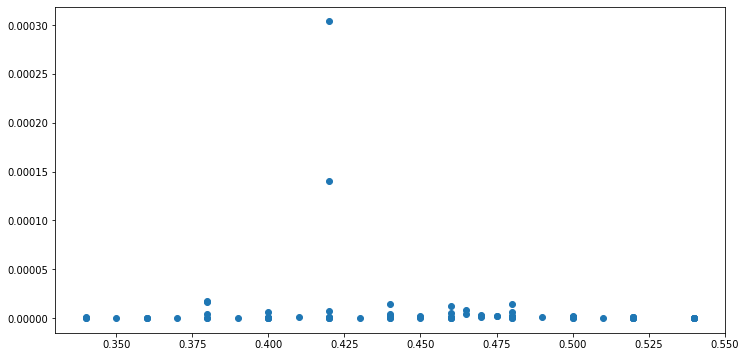

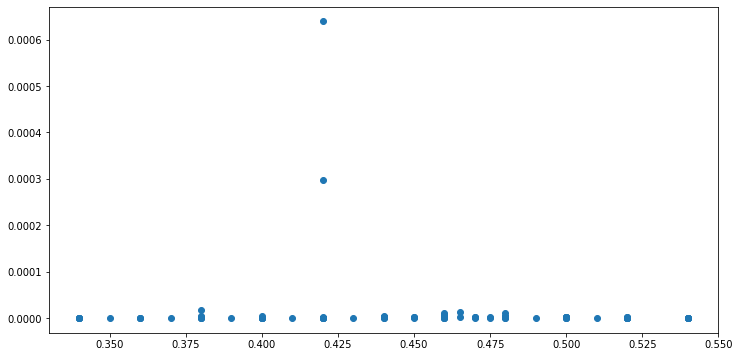

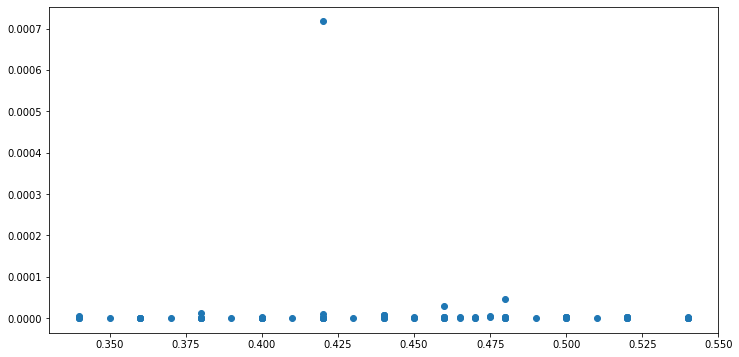

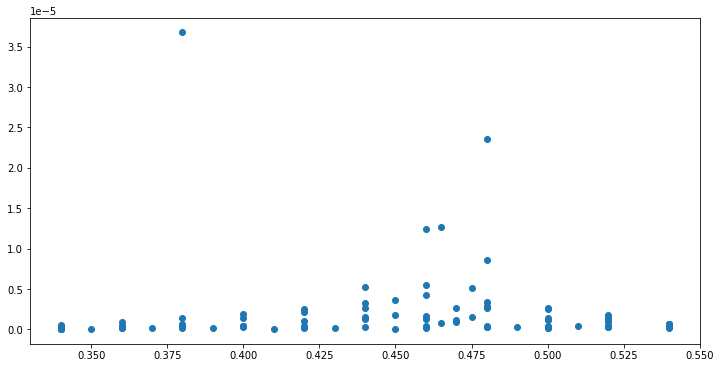

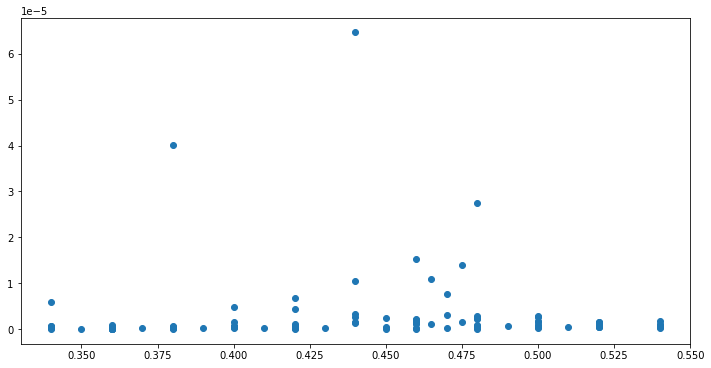

In [44]:
def to_scatter(df, x):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(df[x], df['mse'])
    plt.show()

for freq in obs_df['freq'].unique():
    data = obs_df[obs_df['freq'] == freq]
    to_scatter(data, 'E')

In [47]:
import statsmodels.api as sm

reg = obs_df.copy()
reg['strike_to_mean'] = reg['E'] / reg['S_mean']
freq_dummy = pd.get_dummies(reg['freq'],prefix='freq')

reg_df = pd.concat([reg, freq_dummy], axis=1)

X = reg_df[['strike_to_mean'] + list(freq_dummy.columns)]
y = reg_df['mse']

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    mse   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8210
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.535
Time:                        00:00:55   Log-Likelihood:                 3866.5
No. Observations:                 455   AIC:                            -7721.
Df Residuals:                     449   BIC:                            -7696.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.298e-05   1.55e-05      1.